In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import epiframework
import numpy as np
import pandas as pd
import nn_blocks, idplots, ddpm, myutils, inpaint, ground_truth

import data_utils, data_classes
from torch.utils.data import DataLoader
from torchvision import transforms
import datetime


import sys
sys.path.append('CoPaint4influpaint')
from guided_diffusion import O_DDIMSampler
from guided_diffusion import unet
from utils import config

image_size = 64
channels = 1
batch_size=512
epoch = 800
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == "cuda":
    print(myutils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(myutils.cuda_mem_info())

/nas/longleaf/home/chadi/.conda/envs/diffusion_torch6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 43.9/44.3 (free/total)
NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 43.9/44.3 (free/total)


## Prepare ground-truth for inpainting

Restored git repo Flusight/FluSight-forecast-hub/
Spatial Setup with 51 locations.
⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated
Checked out commit on 2023-11-08 19:27:01.324643 (SHA: d31f305eb0ca87a6fdaf6df3108cc7e3e826f65a, 1699487839) for repo Flusight/FluSight-forecast-hub/
⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated
Restored git repo Flusight/FluSight-forecast-hub/
Masking, >> 15 weeks already in data, inpainting the next ones


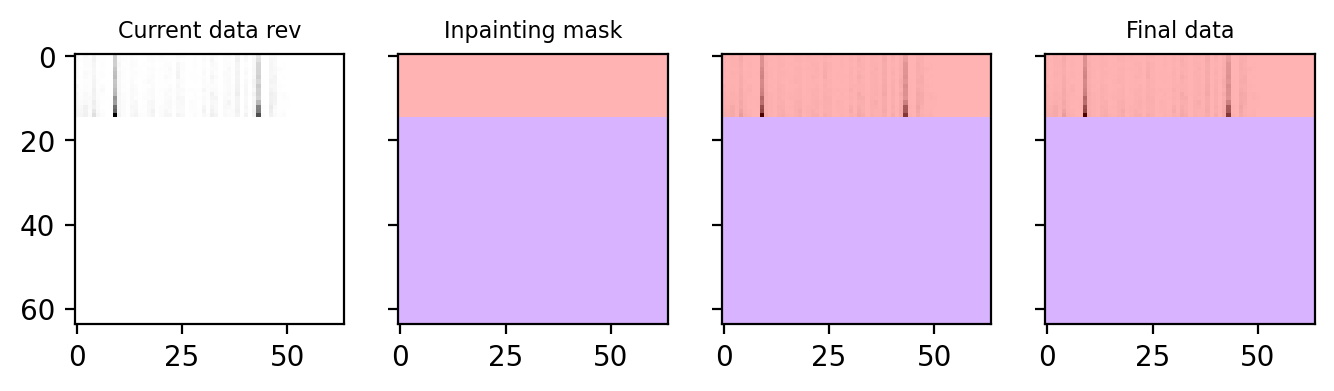

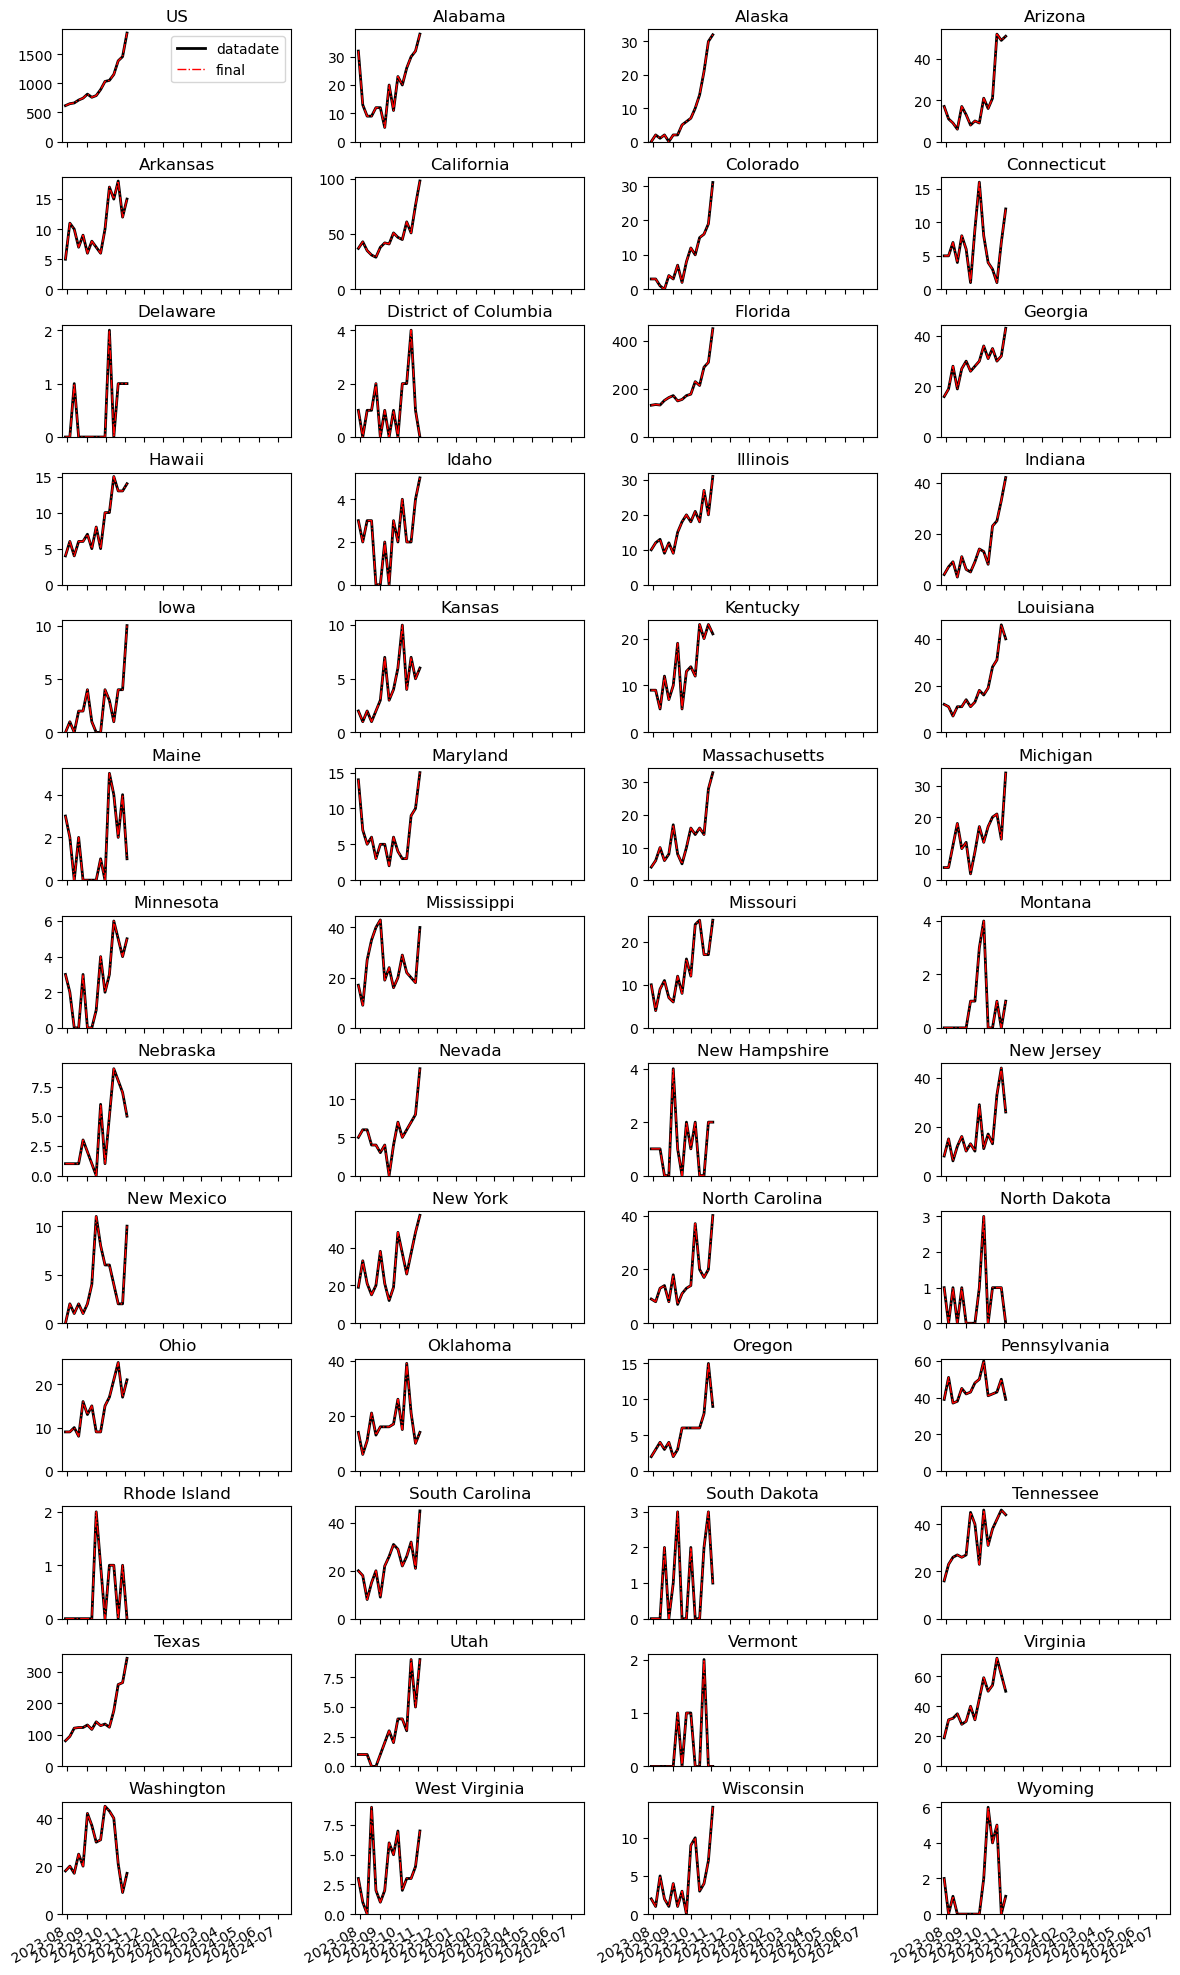

In [2]:
# if True, take a training data sample as gt:
if False: 
    inpaintfrom_idx = 19
    gt_keep_mask = np.ones((channels,image_size,image_size))
    gt_keep_mask[:,inpaintfrom_idx:,:] = 0
    # mask is ones for the known pixels, and zero for the ones to be infered
    gt = data.getitem_nocast(4)
    print(gt.shape)
    show_tensor_image(gt, place=ipl)
    plt.show()

gt1 = ground_truth.GroundTruth(season_first_year="2023", 
                               data_date=datetime.datetime.today(), #datetime.datetime(2023,10,25)
                               mask_date=datetime.datetime.today(),
                               channels=channels,
                               image_size=image_size
                               )
gt1.plot_mask()
gt1.plot()

## Define a PyTorch Dataset + DataLoader

In [ ]:
dataset = data_classes.FluDataset.from_fluview(
                                         flusetup=gt1.flusetup,
                                         download=False, 
                                         #transform=data_classes.transform_randomscale
                                         )
dataset = data_classes.FluDataset.from_SMHR1_fluview(flusetup=gt1.flusetup, download=False)
#data = data_classes.FluDataset.from_csp_SMHR1('Flusight/flu-datasets/synthetic/CSP_FluSMHR1_weekly_padded_4scn.nc', channels=channels)
dataset.test(6)

In [3]:
scaling_per_channel = np.array(np.sqrt(max(dataset.max_per_feature, gt1.gt_xarr.max(dim=["date", "place"])).data))
scaling_per_channel

NameError: name 'dataset' is not defined

In [ ]:
## define image transformations (e.g. using torchvision)

transform_enrich = transforms.Compose([
                        transforms.Lambda(lambda t: data_classes.transform_poisson(t)),
                        transforms.Lambda(lambda t: data_classes.transform_random_padintime(t, min_shift = -15, max_shift = 15)),
                        #transforms.Lambda(lambda t: data_classes.transform_randomscale(t, min=.1, max=1.9)),
        ])
#                         transforms.Lambda(lambda t: data_classes.transform_skewednoise(t, scale=.4, a=-1.8))
transform = transforms.Compose([
                        data_classes.transform_sqrt,
                        transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 1/scaling_per_channel)),
                        transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 2)),

        ])

# TODO: scaling on incident hops scale.

transform_inv = transforms.Compose([
                    data_classes.transform_sqrt_inv,
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale_inv(t, scale = 1/scaling_per_channel)),
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale_inv(t, scale = 2)),
        ][::-1])      # important reverse the sequence

In [ ]:
dataset.add_transform(transform=transform, transform_inv=transform_inv, transform_enrich=transform_enrich, bypass_test=False)

In [ ]:
sample = dataset[6]
print(f"There are {len(dataset)} samples in the dataset, and a single sample has shape {sample.shape}")

In [ ]:
# Dataset is shuffled, but the last incompleted batch is dropped
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True) 
batch = next(iter(dataloader))
print(f"batch shape {batch.shape}")

Next, we define a function which we'll apply on-the-fly on the entire dataset. We use the `with_transform` [functionality](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.with_transform) for that. The function just applies some basic image preprocessing: random horizontal flips, rescaling and finally make them have values in the $[-1,1]$ range.

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes.flat[0].hist(dataset.get_sample_raw(4).flatten(), bins=15);
axes.flat[1].hist(dataset.get_sample_transformed(4).flatten(), bins=15);
axes.flat[2].hist(dataset.get_sample_transformed_enriched(4).flatten(), bins=15);

In [ ]:
# fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=100, sharex=True, sharey=True)
# for ipl in range(51):
#     ax = axes.flat[ipl]
#     for i in range(batch_size):
#         ax.plot(batch[i][0][:,ipl], lw=0.5)

## Initialize the DDPM class

In [ ]:
model = nn_blocks.Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    use_convnext=False
)

ddpm1 = ddpm.DDPM(model=model, 
                    image_size=image_size, 
                    channels=channels, 
                    batch_size=batch_size, 
                    epochs=epoch, 
                    timesteps=200,
                    device=device)


In [ ]:
if False:
    model = unet.UNetModel(
            image_size=image_size,
            in_channels=1,
            out_channels=1,
            num_res_blocks=3,
            model_channels=3,
            attention_resolutions=2,
        )

In [ ]:
dataset
if device == "cuda":
    print(myutils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(myutils.cuda_mem_info())

## Forward diffusion sample

In [ ]:
# use seed for reproducability
torch.manual_seed(0)
x_start = next(iter(dataloader))
print(f"batch shape {batch.shape}")

def plot(imgs, row_title=None, col_title=None, with_histogram=True, plot_size=2, **imshow_kwargs): # with_orig=False,
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    
    mult_rows=1
    if with_histogram:
        mult_rows=2

    place = 4
    color="lightcoral"#'slategray'
    print(gt1.flusetup.get_location_name(gt1.flusetup.locations[place]))
    
    num_rows = len(imgs)*mult_rows
    num_cols = len(imgs[0]) #+ with_orig
    fig, axs = plt.subplots(figsize=(plot_size*num_cols,plot_size*num_rows), nrows=num_rows, ncols=num_cols, squeeze=False, dpi=100)
    for row_idx, row in enumerate(imgs):
        # row = [transform_inv(a[place,:])] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx*mult_rows, col_idx]
            ax.plot(np.arange(52), transform_inv(np.asarray(img))[0,:52,place], **imshow_kwargs, color=color, lw=3, marker='.', markersize=5, markerfacecolor='black', markeredgecolor='black')
            ax.set_xticks(np.arange(0,53,13))
            sns.despine(ax = ax,  offset = 10, trim = True)
            if col_idx>0:
                ax.set(yticklabels=[], yticks=[])
                sns.despine(ax = ax,  offset = 10, left=True, trim = True)

            
            #ax.set_ylim(0)
            #ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if with_histogram:
                ax = axs[row_idx*mult_rows+1, col_idx]
                ax.hist(np.asarray(img).flatten(), bins=20, color='slategray', alpha=0.7, lw=1, edgecolor='k', histtype='stepfilled')
                ax.set_xticks([-1,0,1])
                ax.set(yticklabels=[], yticks=[])
                sns.despine(ax = ax,  offset = 4, left=True, trim = True)
            

    #if with_orig:
    #    axs[0, 0].set(title='Original')
    #    axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    if col_title is not None:
        for col_idx in range(num_cols):
            axs[0, col_idx].set(title=col_title[col_idx])
            axs[0, col_idx].title.set_size(16)

    plt.tight_layout()

#diffused_curves = [[q_sample(x_start[7,:], torch.tensor([t])) for t in [0, 50, 100, 150, 199]] ,
#                   [q_sample(x_start[9,:], torch.tensor([t])) for t in [0, 50, 100, 150, 199]]]#
#plot(diffused_curves, with_histogram=True)

def plot_foward_diffusion(x_start, ts, with_histogram=True, plot_size=2, **imshow_kwargs):
    if not isinstance(x_start, list):
        # Make a 2d grid even if there's just 1 row
        x_start = [x_start]
    diffused_curves = [[x] + [ddpm1.q_sample(x, torch.tensor([t])) for t in ts] for x in x_start]
    col_title = ['t = 0 (original)'] + [f't = {t}/{ddpm1.timesteps-1}' for t in ts]

    plot(diffused_curves, with_histogram=with_histogram, plot_size=plot_size, col_title=col_title, **imshow_kwargs)


plot_foward_diffusion([x_start[0,:]], ts=[3,8, 50, 100, 150, 199], with_histogram=True, plot_size= 2.5)

This means that we can now define the loss function given the model as follows:

## Train the model


In [ ]:
if False:
    ddpm1.train(dataloader=dataloader)

In [ ]:
%ls /work/users/c/h/chadi/influpaint_res/3d47f4a_2023-11-07/*.pth

In [4]:
checkpoint_fn = "/work/users/c/h/chadi/influpaint_res/3d47f4a_2023-11-07/test::model_MyUnet200::dataset_R1Fv::trans_Sqrt::enrich_PoisPadScaleSmall::800.pth"


In [5]:
model_str = checkpoint_fn.split('/')[-1]
for part in model_str.split('::')[1:-1]:
    print(part)
    tp, val = part.split('_')
    if tp == 'model':
        unet_spec = epiframework.model_libary(image_size=image_size, channels=channels, epoch=epoch, device=device, batch_size=batch_size)
        ddpm1 = unet_spec[val]
    elif tp == "dataset":
        dataset_spec = epiframework.dataset_library(gt1=gt1, channels=channels)
        dataset = dataset_spec[val]
    elif tp == "trans":
        scaling_per_channel = np.array(max(dataset.max_per_feature, gt1.gt_xarr.max(dim=["date", "place"])))
        transforms_spec, transform_enrich = epiframework.transform_library(scaling_per_channel=scaling_per_channel)
        transform = transforms_spec[val]
    elif tp == "enrich":
        scaling_per_channel = np.array(max(dataset.max_per_feature, gt1.gt_xarr.max(dim=["date", "place"])))
        transforms_spec, transform_enrich = epiframework.transform_library(scaling_per_channel=scaling_per_channel)
        enrich = transform_enrich[val]
dataset.add_transform(transform=transform["reg"], transform_inv=transform["inv"], transform_enrich=enrich, bypass_test=False)

model_MyUnet200
dataset_R1Fv
After repeat, fluview data has shape (1170, 1, 64, 64) vs (1199, 1, 64, 64) from csp
created dataset with max [14603.53538403], full dataset has shape (2369, 1, 64, 64)
created dataset with max [14603.53538403], full dataset has shape (1199, 1, 64, 64)
trans_Sqrt
[14603.53538403]
enrich_PoisPadScaleSmall
[14603.53538403]
test passed: back and forth transformation are ok ✅


In [6]:
ddpm1.load_model_checkpoint(checkpoint_fn)

In [ ]:
if False:
    ddpm1.write_train_checkpoint()

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [ ]:
if device == "cuda":
    print(myutils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(myutils.cuda_mem_info())

In [ ]:
samples = ddpm1.sample()

In [ ]:
random_index = 0
fig, axes = plt.subplots(1, 1, figsize=(16,3), dpi=100)
ax = axes # es.flat[i]
idplots.show_tensor_image(dataset.apply_transform_inv(samples[-1][random_index]), ax = ax)
plt.show()
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels))
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(16,3), dpi=100)
ax = axes # es.flat[i]
for i in range(batch_size):
    idplots.show_tensor_image(dataset.apply_transform_inv(samples[-1][i]), ax = ax)
#ax.set_ylim(0,10000)

In [ ]:
#plt.hist(samples[-1].flatten(), bins = 100);
#plt.plot(transform_inv(samples[-1][:,0,:,:].sum(axis=2)).T);

In [ ]:
# histogram of peaks. In the US historically it's from 13k to 34k
plt.hist(transform_inv(samples[-1][:,0,:,:].sum(axis=2)).max(axis=1), bins=30)

In [ ]:
# fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=100)
# 
# for ipl in range(51):
#     ax = axes.flat[ipl]
#     for i in range(batch_size):
#         idplots.show_tensor_image(dataset.apply_transform_inv(samples[-1][i]), ax = ax, place=ipl, multi=True)

In [ ]:
animate = False
if animate:
    import matplotlib.animation as animation

    random_index = 53
# TODO: the reshape shuffles the information
    fig = plt.figure()
    ims = []
    for i in range(ddpm1.timesteps):
        im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), animated=True)
        ims.append([im])

    animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    animate.save('diffusion.gif')
    plt.show()
if animate:
    plt.ioff()
    for ts in tqdm(range(0, ddpm1.timesteps, 5)):
        fig, axes = plt.subplots(8, 8, figsize=(10,10))
        for ipl in range(51):
            ax = axes.flat[ipl]
            for i in range(0,batch_size, 2):
                idplots.show_tensor_image(dataset.apply_transform_inv(samples[ts][i]), ax = ax, place=ipl)
        plt.savefig(f'results/{ts}.png')
        plt.close(fig)

## Inpainting (general)

In [7]:
gt = dataset.apply_transform(gt1.gt_xarr.data) # data.apply_transform
gt_keep_mask = torch.from_numpy(gt1.gt_keep_mask).type(torch.FloatTensor).to(device)
gt = torch.from_numpy(gt).type(torch.FloatTensor).to(device)

In [ ]:
fdates = pd.date_range("2022-11-14", "2023-05-15", freq="4W-MON")
for date in fdates:
    gt1 = ground_truth.GroundTruth(season_first_year="2022", 
                                data_date=datetime.datetime.today(), 
                                mask_date=date,
                                channels=channels,
                                image_size=image_size,
                                nogit=True
                                )
    #gt1.plot_mask()
    #gt1.plot()

    gt = dataset.apply_transform(gt1.gt_xarr.data) # data.apply_transform
    print(gt.shape)
    gt_keep_mask = torch.from_numpy(gt1.gt_keep_mask).type(torch.FloatTensor).to(device)
    gt = torch.from_numpy(gt).type(torch.FloatTensor).to(device)

    resampling_steps=1

    inpaint1 = inpaint.REpaint(ddpm=ddpm1, gt=gt, gt_keep_mask=gt_keep_mask, resampling_steps=resampling_steps)
    
    n_samples = batch_size
    all_samples = []
    for i in range(max(n_samples//batch_size,1)):
        samples = inpaint1.sample_paint()
        all_samples.append(samples)
    fluforecasts = -1*np.ones((batch_size*max(n_samples//batch_size,1), 1, 64, 64))
    for i in range(max(n_samples//batch_size,1)):
        fluforecasts[i*batch_size:i*batch_size+batch_size] = all_samples[i][-1]
    
    
    fluforecasts_ti = dataset.apply_transform_inv(fluforecasts)
    # compute the national quantiles, important as sum of quantiles >> quantiles of sum
    forecasts_national = fluforecasts_ti.sum(axis=-1)

    gt1.export_forecasts(fluforecasts_ti=fluforecasts_ti,
                        forecasts_national=forecasts_national,
                        directory='output',
                        prefix=f"{model_str.split('.')[0]}::inpaint_Repaint::resamp_{resampling_steps}",
                        forecast_date=date.date(),
                        save_plot=True)


In [2]:
import numpy as np

In [3]:
flusight_quantiles = np.append(np.append([0.01,0.025],np.arange(0.05,0.95+0.05,0.050)), [0.975,0.99])
flusight_quantile_pairs = np.array([flusight_quantiles[:11],flusight_quantiles[12:][::-1]]).T

In [4]:
flusight_quantile_pairs

array([[0.01 , 0.99 ],
       [0.025, 0.975],
       [0.05 , 0.95 ],
       [0.1  , 0.9  ],
       [0.15 , 0.85 ],
       [0.2  , 0.8  ],
       [0.25 , 0.75 ],
       [0.3  , 0.7  ],
       [0.35 , 0.65 ],
       [0.4  , 0.6  ],
       [0.45 , 0.55 ]])

## Inpatinting from copaint

In [8]:
conf = config.Config(default_config_dict=
                    {
                        "respace_interpolate": False,
                            "ddim": {
                                "ddim_sigma": 0.0,
                                "schedule_params": {
                                    "ddpm_num_steps": 200,
                                    "jump_length": 10,
                                    "jump_n_sample": 2,
                                    "num_inference_steps": 200,
                                    "schedule_type": "linear",
                                    "time_travel_filter_type": "none",
                                    "use_timetravel": True
                                }
                            },
                            "optimize_xt": {
                                "coef_xt_reg": 0.0001,
                                "coef_xt_reg_decay": 1.01,
                                "filter_xT": False,
                                "lr_xt": 0.02,
                                "lr_xt_decay": 1.012,
                                "mid_interval_num": 1,
                                "num_iteration_optimize_xt": 2,
                                "optimize_before_time_travel": True,
                                "optimize_xt": True,
                                "use_adaptive_lr_xt": True,
                                "use_smart_lr_xt_decay": True
                            
                            },
                        "debug":False
                    },  use_argparse=False)

conf = epiframework.copaint_config_library(ddpm1.timesteps)["celebahq_try3"]
sampler = O_DDIMSampler(use_timesteps=np.arange(200), 
                conf=conf,
                betas=ddpm1.betas, 
                model_mean_type=None,
                model_var_type=None,
                loss_type=None)

use_timesteps: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
------------ conf

{
    "ddim": {
        "ddim_sigma": 0.0,
        "schedule_params": {
            "ddpm_num_steps": 200,
            "jump_length": 5,
            "jum

In [9]:
a = sampler.p_sample_loop(model_fn=ddpm1.model, 
                     shape=(batch_size, channels, image_size, image_size),
                     conf=conf,
                     model_kwargs={"gt": gt.repeat(batch_size, 1, 1, 1),
                                    "gt_keep_mask":gt_keep_mask.repeat(batch_size, 1, 1, 1),
                                    "mymodel":True, 
                                }
                     )
fluforecasts = np.array(a['sample'].cpu())

  0%|          | 0/589 [00:00<?, ?it/s]/nas/longleaf/home/chadi/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


step: 199 lr_xt 0.00727175


grad norm: 9.067 5.951 6.841


grad norm: 9.062 5.944 6.839


grad norm: 9.056 5.938 6.838


grad norm: 9.052 5.933 6.836


grad norm: 9.046 5.926 6.834


  0%|          | 1/589 [00:04<48:08,  4.91s/it]

Loss Change: 1937.020 -> 1933.973
Regularization Change: 0.000 -> 0.108
Learning rate of xt decay: 0.02000 -> 0.02024.
Coefficient of regularization decay: 0.00010 -> 0.00010.


step: 198 lr_xt 0.00743373


grad norm: 10.217 6.978 7.463


grad norm: 10.212 6.972 7.462


grad norm: 10.208 6.966 7.461


grad norm: 10.203 6.960 7.461


grad norm: 10.199 6.954 7.460


  0%|          | 2/589 [00:09<45:47,  4.68s/it]

Loss Change: 2084.569 -> 2080.671
Regularization Change: 0.000 -> 0.144
Learning rate of xt decay: 0.02024 -> 0.02048.
Coefficient of regularization decay: 0.00010 -> 0.00010.


step: 197 lr_xt 0.00759892


grad norm: 10.540 7.273 7.628


grad norm: 10.536 7.267 7.628


grad norm: 10.531 7.262 7.628


grad norm: 10.527 7.256 7.628


grad norm: 10.523 7.250 7.627


  1%|          | 3/589 [00:13<44:59,  4.61s/it]

Loss Change: 2136.263 -> 2132.031
Regularization Change: 0.000 -> 0.160
Learning rate of xt decay: 0.02048 -> 0.02073.
Coefficient of regularization decay: 0.00010 -> 0.00010.


step: 196 lr_xt 0.00776739


grad norm: 10.283 7.069 7.468


grad norm: 10.279 7.063 7.468


grad norm: 10.276 7.058 7.468


grad norm: 10.272 7.053 7.468


grad norm: 10.268 7.047 7.467


  1%|          | 4/589 [00:18<44:34,  4.57s/it]

Loss Change: 2108.744 -> 2104.654
Regularization Change: 0.000 -> 0.159
Learning rate of xt decay: 0.02073 -> 0.02098.
Coefficient of regularization decay: 0.00010 -> 0.00010.


step: 195 lr_xt 0.00793919


grad norm: 10.064 6.868 7.357


grad norm: 10.061 6.863 7.357


grad norm: 10.057 6.857 7.357


grad norm: 10.055 6.854 7.357


grad norm: 10.051 6.848 7.357


  1%|          | 5/589 [00:23<44:28,  4.57s/it]

Loss Change: 2094.961 -> 2090.898
Regularization Change: 0.000 -> 0.159
Learning rate of xt decay: 0.02098 -> 0.02123.
Coefficient of regularization decay: 0.00010 -> 0.00011.


step: 194 lr_xt 0.00811437


grad norm: 10.080 6.859 7.387


grad norm: 10.077 6.854 7.387


grad norm: 10.074 6.849 7.387


grad norm: 10.071 6.845 7.387


grad norm: 10.068 6.840 7.387


  1%|          | 6/589 [00:27<44:28,  4.58s/it]

Loss Change: 2117.303 -> 2113.169
Regularization Change: 0.000 -> 0.167
Learning rate of xt decay: 0.02123 -> 0.02148.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 193 lr_xt 0.00829300


grad norm: 10.094 6.868 7.398


grad norm: 10.092 6.864 7.398


grad norm: 10.089 6.860 7.398


grad norm: 10.086 6.855 7.398


grad norm: 10.084 6.851 7.399


  1%|          | 7/589 [00:32<44:39,  4.60s/it]

Loss Change: 2125.217 -> 2121.054
Regularization Change: 0.000 -> 0.175
Learning rate of xt decay: 0.02148 -> 0.02174.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 192 lr_xt 0.00847513


grad norm: 9.977 6.783 7.317


grad norm: 9.974 6.778 7.317


grad norm: 9.972 6.774 7.317


grad norm: 10.047 6.881 7.320


grad norm: 10.043 6.876 7.321


  1%|▏         | 8/589 [00:36<44:21,  4.58s/it]

Loss Change: 2099.877 -> 2095.594
Regularization Change: 0.000 -> 0.179
Learning rate of xt decay: 0.02174 -> 0.02200.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 191 lr_xt 0.00866081


grad norm: 9.836 6.728 7.175


grad norm: 9.833 6.723 7.176


grad norm: 9.830 6.718 7.176


grad norm: 9.826 6.712 7.177


grad norm: 9.823 6.707 7.177


  2%|▏         | 9/589 [00:41<44:06,  4.56s/it]

Loss Change: 2059.076 -> 2054.855
Regularization Change: 0.000 -> 0.181
Learning rate of xt decay: 0.02200 -> 0.02227.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 190 lr_xt 0.00885012


grad norm: 9.551 6.501 6.998


grad norm: 9.548 6.496 6.998


grad norm: 9.546 6.491 6.999


grad norm: 9.542 6.486 6.999


grad norm: 9.539 6.481 7.000


  2%|▏         | 10/589 [00:45<43:55,  4.55s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 2013.130 -> 2009.117
Regularization Change: 0.000 -> 0.178
Undo step: 190
Undo step: 191
Undo step: 192
Undo step: 193
Undo step: 194


step: 195 lr_xt 0.00793919


grad norm: 9.730 6.529 7.215


grad norm: 9.728 6.524 7.216


grad norm: 9.726 6.520 7.217


grad norm: 9.723 6.515 7.218


grad norm: 9.721 6.510 7.219


  3%|▎         | 15/589 [00:50<19:33,  2.04s/it]

Loss Change: 2034.811 -> 2031.036
Regularization Change: 0.000 -> 0.149
Learning rate of xt decay: 0.02098 -> 0.02123.
Coefficient of regularization decay: 0.00010 -> 0.00011.


step: 194 lr_xt 0.00811437


grad norm: 9.749 6.521 7.247


grad norm: 9.748 6.517 7.249


grad norm: 9.746 6.512 7.250


grad norm: 9.744 6.508 7.251


grad norm: 9.741 6.503 7.252


  3%|▎         | 16/589 [00:54<23:25,  2.45s/it]

Loss Change: 2056.364 -> 2052.446
Regularization Change: 0.000 -> 0.156
Learning rate of xt decay: 0.02123 -> 0.02148.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 193 lr_xt 0.00829300


grad norm: 9.765 6.530 7.260


grad norm: 9.763 6.526 7.261


grad norm: 9.761 6.521 7.262


grad norm: 9.759 6.517 7.264


grad norm: 9.757 6.513 7.265


  3%|▎         | 17/589 [00:59<27:09,  2.85s/it]

Loss Change: 2063.371 -> 2059.437
Regularization Change: 0.000 -> 0.164
Learning rate of xt decay: 0.02148 -> 0.02174.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 192 lr_xt 0.00847513


grad norm: 9.653 6.444 7.187


grad norm: 9.652 6.441 7.188


grad norm: 9.650 6.437 7.189


grad norm: 9.648 6.433 7.191


grad norm: 9.647 6.429 7.192


  3%|▎         | 18/589 [01:03<30:31,  3.21s/it]

Loss Change: 2038.173 -> 2034.278
Regularization Change: 0.000 -> 0.167
Learning rate of xt decay: 0.02174 -> 0.02200.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 191 lr_xt 0.00866081


grad norm: 9.448 6.287 7.052


grad norm: 9.446 6.284 7.053


grad norm: 9.444 6.280 7.054


grad norm: 9.443 6.276 7.056


grad norm: 9.442 6.273 7.057


  3%|▎         | 19/589 [01:08<33:31,  3.53s/it]

Loss Change: 1998.877 -> 1995.042
Regularization Change: 0.000 -> 0.167
Learning rate of xt decay: 0.02200 -> 0.02227.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 190 lr_xt 0.00885012


grad norm: 9.181 6.076 6.883


grad norm: 9.179 6.072 6.884


grad norm: 9.179 6.069 6.886


grad norm: 9.178 6.066 6.887


grad norm: 9.176 6.062 6.889


  3%|▎         | 20/589 [01:13<35:51,  3.78s/it]

Loss Change: 1955.478 -> 1951.813
Regularization Change: 0.000 -> 0.165
Learning rate of xt decay: 0.02227 -> 0.02253.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 189 lr_xt 0.00904309


grad norm: 8.905 5.838 6.724


grad norm: 8.904 5.835 6.726


grad norm: 8.903 5.832 6.727


grad norm: 8.902 5.829 6.729


grad norm: 8.902 5.826 6.730


  4%|▎         | 21/589 [01:17<37:40,  3.98s/it]

Loss Change: 1921.011 -> 1917.444
Regularization Change: 0.000 -> 0.162
Learning rate of xt decay: 0.02253 -> 0.02280.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 188 lr_xt 0.00923981


grad norm: 8.818 5.751 6.685


grad norm: 8.818 5.748 6.687


grad norm: 8.817 5.745 6.689


grad norm: 8.816 5.742 6.690


grad norm: 8.815 5.739 6.691


  4%|▎         | 22/589 [01:22<39:02,  4.13s/it]

Loss Change: 1919.399 -> 1915.807
Regularization Change: 0.000 -> 0.166
Learning rate of xt decay: 0.02280 -> 0.02308.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 187 lr_xt 0.00944033


grad norm: 8.935 5.840 6.762


grad norm: 8.934 5.837 6.763


grad norm: 8.933 5.834 6.765


grad norm: 8.932 5.831 6.766


grad norm: 8.932 5.829 6.768


  4%|▍         | 23/589 [01:26<40:03,  4.25s/it]

Loss Change: 1939.060 -> 1935.343
Regularization Change: 0.000 -> 0.178
Learning rate of xt decay: 0.02308 -> 0.02335.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 186 lr_xt 0.00964470


grad norm: 8.993 5.892 6.794


grad norm: 8.993 5.889 6.796


grad norm: 8.992 5.887 6.797


grad norm: 8.992 5.884 6.799


grad norm: 8.991 5.882 6.800


  4%|▍         | 24/589 [01:31<40:46,  4.33s/it]

Loss Change: 1943.812 -> 1939.885
Regularization Change: 0.000 -> 0.188
Learning rate of xt decay: 0.02335 -> 0.02364.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 185 lr_xt 0.00985300


grad norm: 8.866 5.792 6.712


grad norm: 8.865 5.789 6.714


grad norm: 8.865 5.787 6.715


grad norm: 8.864 5.785 6.716


grad norm: 8.864 5.782 6.718


  4%|▍         | 25/589 [01:35<41:16,  4.39s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1926.136 -> 1922.269
Regularization Change: 0.000 -> 0.191
Undo step: 185
Undo step: 186
Undo step: 187
Undo step: 188
Undo step: 189


step: 190 lr_xt 0.00885012


grad norm: 8.929 5.750 6.830


grad norm: 8.928 5.748 6.831


grad norm: 8.927 5.745 6.832


grad norm: 8.926 5.743 6.833


grad norm: 8.925 5.740 6.834


  5%|▌         | 30/589 [01:40<19:09,  2.06s/it]

Loss Change: 1907.839 -> 1904.351
Regularization Change: 0.000 -> 0.156
Learning rate of xt decay: 0.02227 -> 0.02253.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 189 lr_xt 0.00904309


grad norm: 8.669 5.524 6.681


grad norm: 8.668 5.522 6.682


grad norm: 8.667 5.520 6.682


grad norm: 8.667 5.518 6.684


grad norm: 8.666 5.516 6.685


  5%|▌         | 31/589 [01:44<22:51,  2.46s/it]

Loss Change: 1875.921 -> 1872.554
Regularization Change: 0.000 -> 0.154
Learning rate of xt decay: 0.02253 -> 0.02280.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 188 lr_xt 0.00923981


grad norm: 8.588 5.443 6.643


grad norm: 8.587 5.440 6.644


grad norm: 8.587 5.439 6.645


grad norm: 8.586 5.437 6.646


grad norm: 8.586 5.435 6.647


  5%|▌         | 32/589 [01:49<26:26,  2.85s/it]

Loss Change: 1874.658 -> 1871.241
Regularization Change: 0.000 -> 0.157
Learning rate of xt decay: 0.02280 -> 0.02308.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 187 lr_xt 0.00944033


grad norm: 8.694 5.532 6.707


grad norm: 8.693 5.529 6.708


grad norm: 8.693 5.528 6.709


grad norm: 8.693 5.526 6.711


grad norm: 8.692 5.524 6.711


  6%|▌         | 33/589 [01:54<29:42,  3.21s/it]

Loss Change: 1892.129 -> 1888.579
Regularization Change: 0.000 -> 0.168
Learning rate of xt decay: 0.02308 -> 0.02335.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 186 lr_xt 0.00964470


grad norm: 8.746 5.585 6.730


grad norm: 8.745 5.583 6.730


grad norm: 8.744 5.582 6.731


grad norm: 8.743 5.579 6.732


grad norm: 8.743 5.578 6.733


  6%|▌         | 34/589 [01:58<32:31,  3.52s/it]

Loss Change: 1895.467 -> 1891.737
Regularization Change: 0.000 -> 0.178
Learning rate of xt decay: 0.02335 -> 0.02364.
Coefficient of regularization decay: 0.00011 -> 0.00011.


step: 185 lr_xt 0.00985300


grad norm: 8.623 5.492 6.647


grad norm: 8.623 5.491 6.649


grad norm: 8.622 5.489 6.649


grad norm: 8.621 5.487 6.650


grad norm: 8.621 5.485 6.651


  6%|▌         | 35/589 [02:03<34:49,  3.77s/it]

Loss Change: 1878.810 -> 1875.161
Regularization Change: 0.000 -> 0.180
Learning rate of xt decay: 0.02364 -> 0.02392.
Coefficient of regularization decay: 0.00011 -> 0.00012.


step: 184 lr_xt 0.01006528


grad norm: 8.445 5.349 6.535


grad norm: 8.445 5.348 6.536


grad norm: 8.445 5.346 6.537


grad norm: 8.445 5.345 6.538


grad norm: 8.444 5.343 6.539


  6%|▌         | 36/589 [02:07<36:37,  3.97s/it]

Loss Change: 1859.405 -> 1855.853
Regularization Change: 0.000 -> 0.181
Learning rate of xt decay: 0.02392 -> 0.02421.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 183 lr_xt 0.01028161


grad norm: 8.391 5.322 6.487


grad norm: 8.391 5.321 6.488


grad norm: 8.391 5.320 6.489


grad norm: 8.390 5.318 6.490


grad norm: 8.390 5.317 6.491


  6%|▋         | 37/589 [02:12<37:58,  4.13s/it]

Loss Change: 1858.064 -> 1854.371
Regularization Change: 0.000 -> 0.186
Learning rate of xt decay: 0.02421 -> 0.02450.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 182 lr_xt 0.01050206


grad norm: 8.526 5.471 6.540


grad norm: 8.526 5.470 6.541


grad norm: 8.526 5.468 6.542


grad norm: 8.526 5.467 6.542


grad norm: 8.526 5.466 6.543


  6%|▋         | 38/589 [02:16<38:59,  4.25s/it]

Loss Change: 1881.063 -> 1877.250
Regularization Change: 0.000 -> 0.200
Learning rate of xt decay: 0.02450 -> 0.02479.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 181 lr_xt 0.01072668


grad norm: 8.629 5.577 6.585


grad norm: 8.629 5.575 6.586


grad norm: 8.628 5.574 6.586


grad norm: 8.628 5.572 6.587


grad norm: 8.627 5.570 6.587


  7%|▋         | 39/589 [02:21<39:41,  4.33s/it]

Loss Change: 1893.672 -> 1889.695
Regularization Change: 0.000 -> 0.214
Learning rate of xt decay: 0.02479 -> 0.02509.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 180 lr_xt 0.01095556


grad norm: 8.460 5.426 6.490


grad norm: 8.459 5.424 6.491


grad norm: 8.459 5.423 6.492


grad norm: 8.458 5.422 6.492


grad norm: 8.458 5.421 6.493


  7%|▋         | 40/589 [02:25<40:11,  4.39s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1863.326 -> 1859.337
Regularization Change: 0.000 -> 0.215
Undo step: 180
Undo step: 181
Undo step: 182
Undo step: 183
Undo step: 184


step: 185 lr_xt 0.00985300


grad norm: 8.418 5.247 6.582


grad norm: 8.418 5.246 6.584


grad norm: 8.418 5.244 6.586


grad norm: 8.418 5.242 6.587


grad norm: 8.419 5.241 6.589


  8%|▊         | 45/589 [02:30<18:32,  2.05s/it]

Loss Change: 1836.812 -> 1833.337
Regularization Change: 0.000 -> 0.172
Learning rate of xt decay: 0.02364 -> 0.02392.
Coefficient of regularization decay: 0.00011 -> 0.00012.


step: 184 lr_xt 0.01006528


grad norm: 8.254 5.113 6.479


grad norm: 8.254 5.112 6.481


grad norm: 8.255 5.111 6.482


grad norm: 8.255 5.109 6.484


grad norm: 8.256 5.108 6.486


  8%|▊         | 46/589 [02:34<22:09,  2.45s/it]

Loss Change: 1819.428 -> 1816.042
Regularization Change: 0.000 -> 0.173
Learning rate of xt decay: 0.02392 -> 0.02421.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 183 lr_xt 0.01028161


grad norm: 8.201 5.089 6.432


grad norm: 8.202 5.087 6.433


grad norm: 8.202 5.086 6.435


grad norm: 8.203 5.085 6.437


grad norm: 8.203 5.084 6.438


  8%|▊         | 47/589 [02:39<25:40,  2.84s/it]

Loss Change: 1818.320 -> 1814.828
Regularization Change: 0.000 -> 0.178
Learning rate of xt decay: 0.02421 -> 0.02450.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 182 lr_xt 0.01050206


grad norm: 8.324 5.231 6.475


grad norm: 8.324 5.230 6.476


grad norm: 8.325 5.229 6.478


grad norm: 8.325 5.227 6.479


grad norm: 8.326 5.226 6.481


  8%|▊         | 48/589 [02:44<28:52,  3.20s/it]

Loss Change: 1839.033 -> 1835.364
Regularization Change: 0.000 -> 0.191
Learning rate of xt decay: 0.02450 -> 0.02479.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 181 lr_xt 0.01072668


grad norm: 8.419 5.332 6.514


grad norm: 8.419 5.331 6.516


grad norm: 8.419 5.330 6.517


grad norm: 8.420 5.329 6.519


grad norm: 8.420 5.328 6.520


  8%|▊         | 49/589 [02:48<31:37,  3.51s/it]

Loss Change: 1849.933 -> 1846.102
Regularization Change: 0.000 -> 0.204
Learning rate of xt decay: 0.02479 -> 0.02509.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 180 lr_xt 0.01095556


grad norm: 8.261 5.189 6.428


grad norm: 8.262 5.189 6.429


grad norm: 8.263 5.188 6.431


grad norm: 8.263 5.187 6.432


grad norm: 8.263 5.186 6.433


  8%|▊         | 50/589 [02:53<34:01,  3.79s/it]

Loss Change: 1821.309 -> 1817.553
Regularization Change: 0.000 -> 0.205
Learning rate of xt decay: 0.02509 -> 0.02539.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 179 lr_xt 0.01118875


grad norm: 7.971 4.931 6.262


grad norm: 7.972 4.931 6.264


grad norm: 7.973 4.930 6.266


grad norm: 7.974 4.930 6.267


grad norm: 7.974 4.929 6.269


  9%|▊         | 51/589 [02:57<35:47,  3.99s/it]

Loss Change: 1775.988 -> 1772.406
Regularization Change: 0.000 -> 0.199
Learning rate of xt decay: 0.02539 -> 0.02569.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 178 lr_xt 0.01142631


grad norm: 7.722 4.723 6.109


grad norm: 7.723 4.723 6.111


grad norm: 7.724 4.723 6.112


grad norm: 7.725 4.722 6.114


grad norm: 7.726 4.722 6.115


  9%|▉         | 52/589 [03:02<37:05,  4.14s/it]

Loss Change: 1740.422 -> 1737.030
Regularization Change: 0.000 -> 0.195
Learning rate of xt decay: 0.02569 -> 0.02600.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 177 lr_xt 0.01166833


grad norm: 7.550 4.595 5.992


grad norm: 7.551 4.594 5.993


grad norm: 7.552 4.594 5.994


grad norm: 7.553 4.594 5.996


grad norm: 7.554 4.593 5.998


  9%|▉         | 53/589 [03:06<38:01,  4.26s/it]

Loss Change: 1719.077 -> 1715.738
Regularization Change: 0.000 -> 0.194
Learning rate of xt decay: 0.02600 -> 0.02631.
Coefficient of regularization decay: 0.00012 -> 0.00013.


step: 176 lr_xt 0.01191487


grad norm: 7.433 4.522 5.899


grad norm: 7.434 4.522 5.900


grad norm: 7.435 4.522 5.902


grad norm: 7.436 4.521 5.903


grad norm: 7.437 4.521 5.905


  9%|▉         | 54/589 [03:11<38:41,  4.34s/it]

Loss Change: 1707.268 -> 1703.976
Regularization Change: 0.000 -> 0.196
Learning rate of xt decay: 0.02631 -> 0.02663.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 175 lr_xt 0.01216600


grad norm: 7.368 4.487 5.845


grad norm: 7.369 4.487 5.846


grad norm: 7.370 4.486 5.847


grad norm: 7.371 4.486 5.849


grad norm: 7.372 4.486 5.850


  9%|▉         | 55/589 [03:15<39:09,  4.40s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1697.471 -> 1694.114
Regularization Change: 0.000 -> 0.201
Undo step: 175
Undo step: 176
Undo step: 177
Undo step: 178
Undo step: 179


step: 180 lr_xt 0.01095556


grad norm: 8.173 5.059 6.420


grad norm: 8.173 5.057 6.420


grad norm: 8.173 5.056 6.421


grad norm: 8.172 5.055 6.422


grad norm: 8.172 5.053 6.422


 10%|█         | 60/589 [03:20<18:02,  2.05s/it]

Loss Change: 1789.097 -> 1785.405
Regularization Change: 0.000 -> 0.200
Learning rate of xt decay: 0.02509 -> 0.02539.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 179 lr_xt 0.01118875


grad norm: 7.894 4.808 6.261


grad norm: 7.894 4.807 6.262


grad norm: 7.894 4.806 6.263


grad norm: 7.894 4.805 6.263


grad norm: 7.894 4.805 6.264


 10%|█         | 61/589 [03:25<21:34,  2.45s/it]

Loss Change: 1746.291 -> 1742.847
Regularization Change: 0.000 -> 0.195
Learning rate of xt decay: 0.02539 -> 0.02569.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 178 lr_xt 0.01142631


grad norm: 7.656 4.606 6.116


grad norm: 7.657 4.605 6.117


grad norm: 7.656 4.604 6.117


grad norm: 7.657 4.604 6.118


grad norm: 7.657 4.603 6.119


 11%|█         | 62/589 [03:29<24:59,  2.84s/it]

Loss Change: 1712.599 -> 1709.224
Regularization Change: 0.000 -> 0.191
Learning rate of xt decay: 0.02569 -> 0.02600.
Coefficient of regularization decay: 0.00012 -> 0.00012.


step: 177 lr_xt 0.01166833


grad norm: 7.492 4.480 6.005


grad norm: 7.493 4.480 6.006


grad norm: 7.493 4.479 6.007


grad norm: 7.493 4.478 6.007


grad norm: 7.493 4.478 6.008


 11%|█         | 63/589 [03:34<28:05,  3.21s/it]

Loss Change: 1692.239 -> 1688.951
Regularization Change: 0.000 -> 0.191
Learning rate of xt decay: 0.02600 -> 0.02631.
Coefficient of regularization decay: 0.00012 -> 0.00013.


step: 176 lr_xt 0.01191487


grad norm: 7.378 4.410 5.916


grad norm: 7.379 4.409 5.916


grad norm: 7.379 4.409 5.917


grad norm: 7.379 4.408 5.918


grad norm: 7.380 4.408 5.919


 11%|█         | 64/589 [03:38<30:46,  3.52s/it]

Loss Change: 1680.898 -> 1677.681
Regularization Change: 0.000 -> 0.193
Learning rate of xt decay: 0.02631 -> 0.02663.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 175 lr_xt 0.01216600


grad norm: 7.311 4.374 5.858


grad norm: 7.311 4.374 5.858


grad norm: 7.311 4.373 5.859


grad norm: 7.311 4.373 5.859


grad norm: 7.312 4.372 5.860


 11%|█         | 65/589 [03:43<32:57,  3.77s/it]

Loss Change: 1671.298 -> 1668.055
Regularization Change: 0.000 -> 0.198
Learning rate of xt decay: 0.02663 -> 0.02695.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 174 lr_xt 0.01242179


grad norm: 7.351 4.418 5.875


grad norm: 7.351 4.418 5.876


grad norm: 7.351 4.417 5.876


grad norm: 7.352 4.417 5.877


grad norm: 7.352 4.417 5.878


 11%|█         | 66/589 [03:47<34:39,  3.98s/it]

Loss Change: 1669.962 -> 1666.583
Regularization Change: 0.000 -> 0.208
Learning rate of xt decay: 0.02695 -> 0.02727.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 173 lr_xt 0.01268231


grad norm: 7.539 4.594 5.977


grad norm: 7.539 4.594 5.978


grad norm: 7.540 4.594 5.979


grad norm: 7.540 4.594 5.979


grad norm: 7.540 4.593 5.980


 11%|█▏        | 67/589 [03:52<36:05,  4.15s/it]

Loss Change: 1687.026 -> 1683.366
Regularization Change: 0.000 -> 0.229
Learning rate of xt decay: 0.02727 -> 0.02760.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 172 lr_xt 0.01294764


grad norm: 7.706 4.750 6.069


grad norm: 7.707 4.749 6.069


grad norm: 7.707 4.749 6.070


grad norm: 7.707 4.748 6.070


grad norm: 7.708 4.748 6.071


 12%|█▏        | 68/589 [03:57<37:03,  4.27s/it]

Loss Change: 1700.245 -> 1696.392
Regularization Change: 0.000 -> 0.249
Learning rate of xt decay: 0.02760 -> 0.02793.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 171 lr_xt 0.01321784


grad norm: 7.580 4.621 6.009


grad norm: 7.581 4.621 6.010


grad norm: 7.581 4.621 6.010


grad norm: 7.582 4.621 6.011


grad norm: 7.582 4.621 6.011


 12%|█▏        | 69/589 [04:01<37:41,  4.35s/it]

Loss Change: 1677.893 -> 1674.090
Regularization Change: 0.000 -> 0.251
Learning rate of xt decay: 0.02793 -> 0.02827.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 170 lr_xt 0.01349300


grad norm: 7.354 4.408 5.887


grad norm: 7.355 4.409 5.887


grad norm: 7.356 4.409 5.888


grad norm: 7.357 4.409 5.889


grad norm: 7.357 4.409 5.890


 12%|█▏        | 70/589 [04:06<38:07,  4.41s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1653.882 -> 1650.188
Regularization Change: 0.000 -> 0.246
Undo step: 170
Undo step: 171
Undo step: 172
Undo step: 173
Undo step: 174


step: 175 lr_xt 0.01216600


grad norm: 7.230 4.316 5.800


grad norm: 7.230 4.316 5.801


grad norm: 7.230 4.315 5.801


grad norm: 7.230 4.315 5.801


grad norm: 7.230 4.314 5.802


 13%|█▎        | 75/589 [04:10<17:33,  2.05s/it]

Loss Change: 1646.432 -> 1643.250
Regularization Change: 0.000 -> 0.193
Learning rate of xt decay: 0.02663 -> 0.02695.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 174 lr_xt 0.01242179


grad norm: 7.261 4.355 5.810


grad norm: 7.261 4.355 5.810


grad norm: 7.262 4.354 5.811


grad norm: 7.262 4.354 5.812


grad norm: 7.262 4.354 5.812


 13%|█▎        | 76/589 [04:15<20:58,  2.45s/it]

Loss Change: 1644.366 -> 1641.083
Regularization Change: 0.000 -> 0.203
Learning rate of xt decay: 0.02695 -> 0.02727.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 173 lr_xt 0.01268231


grad norm: 7.429 4.517 5.898


grad norm: 7.429 4.516 5.899


grad norm: 7.430 4.516 5.900


grad norm: 7.431 4.516 5.901


grad norm: 7.431 4.516 5.902


 13%|█▎        | 77/589 [04:19<24:18,  2.85s/it]

Loss Change: 1659.383 -> 1655.888
Regularization Change: 0.000 -> 0.222
Learning rate of xt decay: 0.02727 -> 0.02760.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 172 lr_xt 0.01294764


grad norm: 7.582 4.660 5.980


grad norm: 7.582 4.660 5.981


grad norm: 7.583 4.660 5.982


grad norm: 7.584 4.660 5.983


grad norm: 7.585 4.660 5.984


 13%|█▎        | 78/589 [04:24<27:19,  3.21s/it]

Loss Change: 1671.003 -> 1667.240
Regularization Change: 0.000 -> 0.241
Learning rate of xt decay: 0.02760 -> 0.02793.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 171 lr_xt 0.01321784


grad norm: 7.465 4.539 5.927


grad norm: 7.466 4.539 5.928


grad norm: 7.467 4.539 5.929


grad norm: 7.468 4.539 5.930


grad norm: 7.469 4.539 5.931


 13%|█▎        | 79/589 [04:28<29:54,  3.52s/it]

Loss Change: 1649.931 -> 1646.247
Regularization Change: 0.000 -> 0.244
Learning rate of xt decay: 0.02793 -> 0.02827.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 170 lr_xt 0.01349300


grad norm: 7.256 4.338 5.817


grad norm: 7.257 4.338 5.818


grad norm: 7.259 4.338 5.820


grad norm: 7.260 4.339 5.821


grad norm: 7.262 4.339 5.823


 14%|█▎        | 80/589 [04:33<32:02,  3.78s/it]

Loss Change: 1628.272 -> 1624.693
Regularization Change: 0.000 -> 0.240
Learning rate of xt decay: 0.02827 -> 0.02861.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 169 lr_xt 0.01377318


grad norm: 7.192 4.308 5.759


grad norm: 7.194 4.309 5.760


grad norm: 7.195 4.309 5.762


grad norm: 7.197 4.309 5.764


grad norm: 7.198 4.310 5.765


 14%|█▍        | 81/589 [04:38<33:42,  3.98s/it]

Loss Change: 1631.165 -> 1627.675
Regularization Change: 0.000 -> 0.246
Learning rate of xt decay: 0.02861 -> 0.02895.
Coefficient of regularization decay: 0.00013 -> 0.00014.


step: 168 lr_xt 0.01405847


grad norm: 7.226 4.365 5.758


grad norm: 7.227 4.366 5.760


grad norm: 7.229 4.366 5.762


grad norm: 7.231 4.367 5.763


grad norm: 7.232 4.367 5.765


 14%|█▍        | 82/589 [04:42<34:57,  4.14s/it]

Loss Change: 1637.095 -> 1633.421
Regularization Change: 0.000 -> 0.258
Learning rate of xt decay: 0.02895 -> 0.02930.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 167 lr_xt 0.01434894


grad norm: 7.279 4.416 5.786


grad norm: 7.280 4.416 5.788


grad norm: 7.282 4.417 5.789


grad norm: 7.283 4.417 5.791


grad norm: 7.285 4.418 5.793


 14%|█▍        | 83/589 [04:47<35:51,  4.25s/it]

Loss Change: 1634.839 -> 1630.975
Regularization Change: 0.000 -> 0.273
Learning rate of xt decay: 0.02930 -> 0.02965.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 166 lr_xt 0.01464466


grad norm: 7.333 4.475 5.809


grad norm: 7.334 4.475 5.811


grad norm: 7.336 4.476 5.813


grad norm: 7.337 4.476 5.814


grad norm: 7.339 4.477 5.815


 14%|█▍        | 84/589 [04:51<36:31,  4.34s/it]

Loss Change: 1631.549 -> 1627.659
Regularization Change: 0.000 -> 0.289
Learning rate of xt decay: 0.02965 -> 0.03000.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 165 lr_xt 0.01494572


grad norm: 7.357 4.520 5.804


grad norm: 7.358 4.521 5.805


grad norm: 7.359 4.521 5.807


grad norm: 7.361 4.522 5.808


grad norm: 7.362 4.522 5.809


 14%|█▍        | 85/589 [04:56<37:07,  4.42s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1625.682 -> 1621.619
Regularization Change: 0.000 -> 0.302
Undo step: 165
Undo step: 166
Undo step: 167
Undo step: 168
Undo step: 169


step: 170 lr_xt 0.01349300


grad norm: 7.304 4.279 5.920


grad norm: 7.305 4.279 5.921


grad norm: 7.305 4.279 5.921


grad norm: 7.305 4.279 5.921


grad norm: 7.306 4.278 5.922


 15%|█▌        | 90/589 [05:00<17:05,  2.05s/it]

Loss Change: 1609.391 -> 1605.859
Regularization Change: 0.000 -> 0.243
Learning rate of xt decay: 0.02827 -> 0.02861.
Coefficient of regularization decay: 0.00013 -> 0.00013.


step: 169 lr_xt 0.01377318


grad norm: 7.243 4.254 5.863


grad norm: 7.244 4.254 5.863


grad norm: 7.244 4.254 5.863


grad norm: 7.244 4.254 5.864


grad norm: 7.245 4.254 5.864


 15%|█▌        | 91/589 [05:05<20:24,  2.46s/it]

Loss Change: 1612.283 -> 1608.689
Regularization Change: 0.000 -> 0.249
Learning rate of xt decay: 0.02861 -> 0.02895.
Coefficient of regularization decay: 0.00013 -> 0.00014.


step: 168 lr_xt 0.01405847


grad norm: 7.265 4.306 5.851


grad norm: 7.265 4.306 5.851


grad norm: 7.266 4.307 5.852


grad norm: 7.266 4.306 5.852


grad norm: 7.266 4.306 5.852


 16%|█▌        | 92/589 [05:09<23:37,  2.85s/it]

Loss Change: 1617.080 -> 1613.443
Regularization Change: 0.000 -> 0.261
Learning rate of xt decay: 0.02895 -> 0.02930.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 167 lr_xt 0.01434894


grad norm: 7.299 4.348 5.863


grad norm: 7.299 4.348 5.863


grad norm: 7.299 4.348 5.863


grad norm: 7.300 4.348 5.864


grad norm: 7.300 4.348 5.864


 16%|█▌        | 93/589 [05:14<26:33,  3.21s/it]

Loss Change: 1613.888 -> 1610.061
Regularization Change: 0.000 -> 0.274
Learning rate of xt decay: 0.02930 -> 0.02965.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 166 lr_xt 0.01464466


grad norm: 7.333 4.396 5.869


grad norm: 7.333 4.396 5.869


grad norm: 7.333 4.396 5.870


grad norm: 7.333 4.396 5.870


grad norm: 7.333 4.396 5.870


 16%|█▌        | 94/589 [05:19<29:03,  3.52s/it]

Loss Change: 1609.679 -> 1605.722
Regularization Change: 0.000 -> 0.288
Learning rate of xt decay: 0.02965 -> 0.03000.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 165 lr_xt 0.01494572


grad norm: 7.343 4.435 5.852


grad norm: 7.343 4.435 5.852


grad norm: 7.343 4.434 5.852


grad norm: 7.342 4.434 5.852


grad norm: 7.342 4.434 5.853


 16%|█▌        | 95/589 [05:23<31:07,  3.78s/it]

Loss Change: 1603.177 -> 1599.093
Regularization Change: 0.000 -> 0.301
Learning rate of xt decay: 0.03000 -> 0.03036.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 164 lr_xt 0.01525219


grad norm: 7.316 4.427 5.825


grad norm: 7.317 4.427 5.825


grad norm: 7.316 4.427 5.825


grad norm: 7.316 4.427 5.825


grad norm: 7.316 4.427 5.825


 16%|█▋        | 96/589 [05:28<32:44,  3.99s/it]

Loss Change: 1595.664 -> 1591.597
Regularization Change: 0.000 -> 0.311
Learning rate of xt decay: 0.03036 -> 0.03073.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 163 lr_xt 0.01556416


grad norm: 7.283 4.391 5.811


grad norm: 7.283 4.391 5.811


grad norm: 7.283 4.391 5.811


grad norm: 7.282 4.391 5.810


grad norm: 7.282 4.391 5.810


 16%|█▋        | 97/589 [05:32<33:57,  4.14s/it]

Loss Change: 1592.124 -> 1588.009
Regularization Change: 0.000 -> 0.321
Learning rate of xt decay: 0.03073 -> 0.03110.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 162 lr_xt 0.01588169


grad norm: 7.224 4.321 5.789


grad norm: 7.223 4.321 5.789


grad norm: 7.223 4.321 5.788


grad norm: 7.223 4.321 5.788


grad norm: 7.222 4.321 5.787


 17%|█▋        | 98/589 [05:37<34:50,  4.26s/it]

Loss Change: 1584.669 -> 1580.586
Regularization Change: 0.000 -> 0.329
Learning rate of xt decay: 0.03110 -> 0.03147.
Coefficient of regularization decay: 0.00014 -> 0.00015.


step: 161 lr_xt 0.01620489


grad norm: 7.173 4.271 5.763


grad norm: 7.173 4.271 5.762


grad norm: 7.171 4.271 5.761


grad norm: 7.171 4.271 5.760


grad norm: 7.170 4.272 5.759


 17%|█▋        | 99/589 [05:41<35:29,  4.35s/it]

Loss Change: 1574.698 -> 1570.527
Regularization Change: 0.000 -> 0.338
Learning rate of xt decay: 0.03147 -> 0.03185.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 160 lr_xt 0.01653382


grad norm: 7.187 4.302 5.757


grad norm: 7.187 4.302 5.756


grad norm: 7.185 4.302 5.755


grad norm: 7.184 4.302 5.754


grad norm: 7.183 4.302 5.752


 17%|█▋        | 100/589 [05:46<35:54,  4.41s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1570.399 -> 1566.146
Regularization Change: 0.000 -> 0.353
Undo step: 160
Undo step: 161
Undo step: 162
Undo step: 163
Undo step: 164


step: 165 lr_xt 0.01494572


grad norm: 7.238 4.372 5.769


grad norm: 7.238 4.372 5.769


grad norm: 7.237 4.371 5.768


grad norm: 7.237 4.371 5.767


grad norm: 7.236 4.371 5.767


 18%|█▊        | 105/589 [05:50<16:32,  2.05s/it]

Loss Change: 1583.700 -> 1579.779
Regularization Change: 0.000 -> 0.292
Learning rate of xt decay: 0.03000 -> 0.03036.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 164 lr_xt 0.01525219


grad norm: 7.208 4.363 5.738


grad norm: 7.207 4.363 5.737


grad norm: 7.207 4.362 5.736


grad norm: 7.206 4.362 5.736


grad norm: 7.205 4.362 5.735


 18%|█▊        | 106/589 [05:55<19:46,  2.46s/it]

Loss Change: 1576.278 -> 1572.269
Regularization Change: 0.000 -> 0.302
Learning rate of xt decay: 0.03036 -> 0.03073.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 163 lr_xt 0.01556416


grad norm: 7.173 4.326 5.721


grad norm: 7.172 4.326 5.721


grad norm: 7.172 4.326 5.720


grad norm: 7.171 4.326 5.719


grad norm: 7.170 4.325 5.719


 18%|█▊        | 107/589 [06:00<22:53,  2.85s/it]

Loss Change: 1573.086 -> 1569.050
Regularization Change: 0.000 -> 0.311
Learning rate of xt decay: 0.03073 -> 0.03110.
Coefficient of regularization decay: 0.00014 -> 0.00014.


step: 162 lr_xt 0.01588169


grad norm: 7.115 4.258 5.700


grad norm: 7.114 4.258 5.700


grad norm: 7.114 4.258 5.699


grad norm: 7.114 4.258 5.699


grad norm: 7.113 4.258 5.698


 18%|█▊        | 108/589 [06:04<25:43,  3.21s/it]

Loss Change: 1566.351 -> 1562.313
Regularization Change: 0.000 -> 0.319
Learning rate of xt decay: 0.03110 -> 0.03147.
Coefficient of regularization decay: 0.00014 -> 0.00015.


step: 161 lr_xt 0.01620489


grad norm: 7.066 4.210 5.676


grad norm: 7.066 4.210 5.675


grad norm: 7.066 4.210 5.674


grad norm: 7.066 4.210 5.674


grad norm: 7.065 4.210 5.674


 19%|█▊        | 109/589 [06:09<28:09,  3.52s/it]

Loss Change: 1556.764 -> 1552.736
Regularization Change: 0.000 -> 0.328
Learning rate of xt decay: 0.03147 -> 0.03185.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 160 lr_xt 0.01653382


grad norm: 7.079 4.238 5.670


grad norm: 7.078 4.238 5.669


grad norm: 7.078 4.238 5.669


grad norm: 7.078 4.238 5.669


grad norm: 7.077 4.238 5.668


 19%|█▊        | 110/589 [06:13<30:09,  3.78s/it]

Loss Change: 1551.950 -> 1547.787
Regularization Change: 0.000 -> 0.342
Learning rate of xt decay: 0.03185 -> 0.03223.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 159 lr_xt 0.01686856


grad norm: 7.051 4.227 5.643


grad norm: 7.050 4.227 5.643


grad norm: 7.050 4.227 5.642


grad norm: 7.050 4.227 5.642


grad norm: 7.050 4.227 5.641


 19%|█▉        | 111/589 [06:18<31:42,  3.98s/it]

Loss Change: 1543.962 -> 1539.734
Regularization Change: 0.000 -> 0.354
Learning rate of xt decay: 0.03223 -> 0.03262.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 158 lr_xt 0.01720922


grad norm: 6.907 4.110 5.552


grad norm: 6.907 4.110 5.552


grad norm: 6.907 4.110 5.551


grad norm: 6.908 4.111 5.551


grad norm: 6.908 4.111 5.551


 19%|█▉        | 112/589 [06:22<32:52,  4.14s/it]

Loss Change: 1527.503 -> 1523.371
Regularization Change: 0.000 -> 0.353
Learning rate of xt decay: 0.03262 -> 0.03301.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 157 lr_xt 0.01755586


grad norm: 6.791 4.045 5.455


grad norm: 6.791 4.046 5.455


grad norm: 6.791 4.046 5.455


grad norm: 6.792 4.047 5.455


grad norm: 6.792 4.047 5.454


 19%|█▉        | 113/589 [06:27<33:44,  4.25s/it]

Loss Change: 1516.249 -> 1512.174
Regularization Change: 0.000 -> 0.355
Learning rate of xt decay: 0.03301 -> 0.03340.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 156 lr_xt 0.01790857


grad norm: 6.786 4.098 5.409


grad norm: 6.786 4.098 5.409


grad norm: 6.787 4.099 5.409


grad norm: 6.787 4.100 5.409


grad norm: 6.787 4.101 5.408


 19%|█▉        | 114/589 [06:31<34:20,  4.34s/it]

Loss Change: 1513.516 -> 1509.326
Regularization Change: 0.000 -> 0.369
Learning rate of xt decay: 0.03340 -> 0.03380.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 155 lr_xt 0.01826744


grad norm: 6.850 4.196 5.414


grad norm: 6.850 4.197 5.414


grad norm: 6.850 4.198 5.414


grad norm: 6.850 4.198 5.413


grad norm: 6.851 4.199 5.413


 20%|█▉        | 115/589 [06:36<35:01,  4.43s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1515.021 -> 1510.762
Regularization Change: 0.000 -> 0.391
Undo step: 155
Undo step: 156
Undo step: 157
Undo step: 158
Undo step: 159


step: 160 lr_xt 0.01653382


grad norm: 7.188 4.280 5.775


grad norm: 7.187 4.280 5.774


grad norm: 7.186 4.280 5.773


grad norm: 7.186 4.281 5.772


grad norm: 7.185 4.281 5.771


 20%|██        | 120/589 [06:41<16:05,  2.06s/it]

Loss Change: 1533.313 -> 1528.982
Regularization Change: 0.000 -> 0.353
Learning rate of xt decay: 0.03185 -> 0.03223.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 159 lr_xt 0.01686856


grad norm: 7.156 4.268 5.743


grad norm: 7.155 4.268 5.742


grad norm: 7.154 4.269 5.741


grad norm: 7.153 4.269 5.740


grad norm: 7.153 4.269 5.739


 21%|██        | 121/589 [06:45<19:12,  2.46s/it]

Loss Change: 1525.035 -> 1520.720
Regularization Change: 0.000 -> 0.364
Learning rate of xt decay: 0.03223 -> 0.03262.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 158 lr_xt 0.01720922


grad norm: 7.021 4.158 5.658


grad norm: 7.021 4.158 5.657


grad norm: 7.020 4.159 5.656


grad norm: 7.020 4.159 5.655


grad norm: 7.019 4.160 5.654


 21%|██        | 122/589 [06:50<22:14,  2.86s/it]

Loss Change: 1509.620 -> 1505.359
Regularization Change: 0.000 -> 0.365
Learning rate of xt decay: 0.03262 -> 0.03301.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 157 lr_xt 0.01755586


grad norm: 6.908 4.095 5.564


grad norm: 6.908 4.096 5.563


grad norm: 6.908 4.097 5.562


grad norm: 6.907 4.097 5.561


grad norm: 6.907 4.098 5.560


 21%|██        | 123/589 [06:54<25:04,  3.23s/it]

Loss Change: 1498.876 -> 1494.726
Regularization Change: 0.000 -> 0.368
Learning rate of xt decay: 0.03301 -> 0.03340.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 156 lr_xt 0.01790857


grad norm: 6.893 4.141 5.510


grad norm: 6.892 4.142 5.509


grad norm: 6.892 4.143 5.508


grad norm: 6.892 4.143 5.507


grad norm: 6.891 4.144 5.506


 21%|██        | 124/589 [06:59<27:25,  3.54s/it]

Loss Change: 1495.605 -> 1491.332
Regularization Change: 0.000 -> 0.381
Learning rate of xt decay: 0.03340 -> 0.03380.
Coefficient of regularization decay: 0.00015 -> 0.00015.


step: 155 lr_xt 0.01826744


grad norm: 6.942 4.230 5.504


grad norm: 6.941 4.231 5.503


grad norm: 6.940 4.231 5.501


grad norm: 6.940 4.232 5.500


grad norm: 6.939 4.232 5.499


 21%|██        | 125/589 [07:04<29:20,  3.79s/it]

Loss Change: 1496.121 -> 1491.732
Regularization Change: 0.000 -> 0.402
Learning rate of xt decay: 0.03380 -> 0.03421.
Coefficient of regularization decay: 0.00015 -> 0.00016.


step: 154 lr_xt 0.01863255


grad norm: 6.998 4.317 5.507


grad norm: 6.997 4.317 5.506


grad norm: 6.996 4.317 5.505


grad norm: 6.995 4.318 5.503


grad norm: 6.994 4.318 5.502


 21%|██▏       | 126/589 [07:08<30:48,  3.99s/it]

Loss Change: 1496.826 -> 1492.267
Regularization Change: 0.000 -> 0.425
Learning rate of xt decay: 0.03421 -> 0.03462.
Coefficient of regularization decay: 0.00016 -> 0.00016.


step: 153 lr_xt 0.01900400


grad norm: 6.957 4.307 5.463


grad norm: 6.956 4.308 5.461


grad norm: 6.954 4.308 5.460


grad norm: 6.954 4.308 5.458


grad norm: 6.953 4.308 5.457


 22%|██▏       | 127/589 [07:13<31:55,  4.15s/it]

Loss Change: 1487.196 -> 1482.622
Regularization Change: 0.000 -> 0.437
Learning rate of xt decay: 0.03462 -> 0.03504.
Coefficient of regularization decay: 0.00016 -> 0.00016.


step: 152 lr_xt 0.01938186


grad norm: 6.837 4.207 5.390


grad norm: 6.836 4.208 5.388


grad norm: 6.836 4.208 5.387


grad norm: 6.835 4.209 5.385


grad norm: 6.834 4.209 5.384


 22%|██▏       | 128/589 [07:17<32:46,  4.26s/it]

Loss Change: 1471.266 -> 1466.765
Regularization Change: 0.000 -> 0.439
Learning rate of xt decay: 0.03504 -> 0.03546.
Coefficient of regularization decay: 0.00016 -> 0.00016.


step: 151 lr_xt 0.01976624


grad norm: 6.806 4.189 5.364


grad norm: 6.805 4.190 5.362


grad norm: 6.804 4.190 5.360


grad norm: 6.803 4.191 5.359


grad norm: 6.802 4.192 5.357


 22%|██▏       | 129/589 [07:22<33:20,  4.35s/it]

Loss Change: 1467.714 -> 1463.116
Regularization Change: 0.000 -> 0.452
Learning rate of xt decay: 0.03546 -> 0.03588.
Coefficient of regularization decay: 0.00016 -> 0.00016.


step: 150 lr_xt 0.02015722


grad norm: 6.880 4.288 5.381


grad norm: 6.879 4.288 5.379


grad norm: 6.878 4.289 5.377


grad norm: 6.877 4.289 5.376


grad norm: 6.877 4.290 5.374


 22%|██▏       | 130/589 [07:26<33:43,  4.41s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1474.679 -> 1469.892
Regularization Change: 0.000 -> 0.481
Undo step: 150
Undo step: 151
Undo step: 152
Undo step: 153
Undo step: 154


step: 155 lr_xt 0.01826744


grad norm: 6.932 4.208 5.509


grad norm: 6.931 4.208 5.507


grad norm: 6.930 4.209 5.505


grad norm: 6.928 4.209 5.503


grad norm: 6.927 4.209 5.502


 23%|██▎       | 135/589 [07:31<15:31,  2.05s/it]

Loss Change: 1478.766 -> 1474.392
Regularization Change: 0.000 -> 0.401
Learning rate of xt decay: 0.03380 -> 0.03421.
Coefficient of regularization decay: 0.00015 -> 0.00016.


step: 154 lr_xt 0.01863255


grad norm: 6.977 4.287 5.504


grad norm: 6.975 4.287 5.502


grad norm: 6.974 4.288 5.501


grad norm: 6.973 4.288 5.499


grad norm: 6.972 4.288 5.497


 23%|██▎       | 136/589 [07:35<18:32,  2.46s/it]

Loss Change: 1478.749 -> 1474.218
Regularization Change: 0.000 -> 0.422
Learning rate of xt decay: 0.03421 -> 0.03462.
Coefficient of regularization decay: 0.00016 -> 0.00016.


step: 153 lr_xt 0.01900400


grad norm: 6.934 4.277 5.458


grad norm: 6.933 4.277 5.457


grad norm: 6.932 4.277 5.455


grad norm: 6.931 4.277 5.454


grad norm: 6.930 4.277 5.452


 23%|██▎       | 137/589 [07:40<21:28,  2.85s/it]

Loss Change: 1469.393 -> 1464.810
Regularization Change: 0.000 -> 0.434
Learning rate of xt decay: 0.03462 -> 0.03504.
Coefficient of regularization decay: 0.00016 -> 0.00016.


step: 152 lr_xt 0.01938186


grad norm: 6.822 4.181 5.391


grad norm: 6.821 4.181 5.389


grad norm: 6.821 4.182 5.388


grad norm: 6.820 4.182 5.387


grad norm: 6.819 4.183 5.385


 23%|██▎       | 138/589 [07:45<24:10,  3.22s/it]

Loss Change: 1454.535 -> 1450.013
Regularization Change: 0.000 -> 0.437
Learning rate of xt decay: 0.03504 -> 0.03546.
Coefficient of regularization decay: 0.00016 -> 0.00016.


step: 151 lr_xt 0.01976624


grad norm: 6.794 4.164 5.368


grad norm: 6.793 4.165 5.366


grad norm: 6.792 4.165 5.365


grad norm: 6.791 4.166 5.364


grad norm: 6.791 4.166 5.363


 24%|██▎       | 139/589 [07:49<26:26,  3.53s/it]

Loss Change: 1451.275 -> 1446.671
Regularization Change: 0.000 -> 0.451
Learning rate of xt decay: 0.03546 -> 0.03588.
Coefficient of regularization decay: 0.00016 -> 0.00016.


step: 150 lr_xt 0.02015722


grad norm: 6.863 4.258 5.382


grad norm: 6.862 4.259 5.381


grad norm: 6.862 4.259 5.380


grad norm: 6.861 4.260 5.379


grad norm: 6.861 4.261 5.377


 24%|██▍       | 140/589 [07:54<28:18,  3.78s/it]

Loss Change: 1457.471 -> 1452.726
Regularization Change: 0.000 -> 0.478
Learning rate of xt decay: 0.03588 -> 0.03631.
Coefficient of regularization decay: 0.00016 -> 0.00016.


step: 149 lr_xt 0.02055488


grad norm: 6.930 4.345 5.399


grad norm: 6.930 4.345 5.398


grad norm: 6.930 4.346 5.397


grad norm: 6.929 4.347 5.396


grad norm: 6.929 4.348 5.395


 24%|██▍       | 141/589 [07:58<29:46,  3.99s/it]

Loss Change: 1459.808 -> 1454.893
Regularization Change: 0.000 -> 0.507
Learning rate of xt decay: 0.03631 -> 0.03675.
Coefficient of regularization decay: 0.00016 -> 0.00017.


step: 148 lr_xt 0.02095933


grad norm: 6.968 4.399 5.404


grad norm: 6.968 4.400 5.403


grad norm: 6.967 4.400 5.402


grad norm: 6.967 4.401 5.400


grad norm: 6.966 4.402 5.399


 24%|██▍       | 142/589 [08:03<30:52,  4.14s/it]

Loss Change: 1456.406 -> 1451.292
Regularization Change: 0.000 -> 0.533
Learning rate of xt decay: 0.03675 -> 0.03719.
Coefficient of regularization decay: 0.00017 -> 0.00017.


step: 147 lr_xt 0.02137065


grad norm: 6.980 4.425 5.398


grad norm: 6.979 4.425 5.397


grad norm: 6.979 4.426 5.396


grad norm: 6.978 4.426 5.394


grad norm: 6.977 4.427 5.393


 24%|██▍       | 143/589 [08:07<31:39,  4.26s/it]

Loss Change: 1448.327 -> 1443.150
Regularization Change: 0.000 -> 0.556
Learning rate of xt decay: 0.03719 -> 0.03764.
Coefficient of regularization decay: 0.00017 -> 0.00017.


step: 146 lr_xt 0.02178894


grad norm: 6.911 4.356 5.365


grad norm: 6.910 4.357 5.363


grad norm: 6.909 4.357 5.362


grad norm: 6.908 4.358 5.360


grad norm: 6.907 4.358 5.359


 24%|██▍       | 144/589 [08:12<32:15,  4.35s/it]

Loss Change: 1432.621 -> 1427.379
Regularization Change: 0.000 -> 0.567
Learning rate of xt decay: 0.03764 -> 0.03809.
Coefficient of regularization decay: 0.00017 -> 0.00017.


step: 145 lr_xt 0.02221429


grad norm: 6.856 4.296 5.343


grad norm: 6.855 4.297 5.341


grad norm: 6.854 4.297 5.340


grad norm: 6.854 4.298 5.338


grad norm: 6.853 4.299 5.337


 25%|██▍       | 145/589 [08:17<32:37,  4.41s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1424.834 -> 1419.595
Regularization Change: 0.000 -> 0.580
Undo step: 145
Undo step: 146
Undo step: 147
Undo step: 148
Undo step: 149


step: 150 lr_xt 0.02015722


grad norm: 7.004 4.262 5.558


grad norm: 7.000 4.263 5.552


grad norm: 6.996 4.264 5.547


grad norm: 6.993 4.265 5.542


grad norm: 6.989 4.266 5.537


 25%|██▌       | 150/589 [08:21<15:00,  2.05s/it]

Loss Change: 1438.930 -> 1433.959
Regularization Change: 0.000 -> 0.497
Learning rate of xt decay: 0.03588 -> 0.03631.
Coefficient of regularization decay: 0.00016 -> 0.00016.


step: 149 lr_xt 0.02055488


grad norm: 7.050 4.348 5.549


grad norm: 7.046 4.349 5.544


grad norm: 7.043 4.349 5.539


grad norm: 7.040 4.350 5.535


grad norm: 7.036 4.351 5.530


 26%|██▌       | 151/589 [08:26<17:57,  2.46s/it]

Loss Change: 1440.336 -> 1435.254
Regularization Change: 0.000 -> 0.524
Learning rate of xt decay: 0.03631 -> 0.03675.
Coefficient of regularization decay: 0.00016 -> 0.00017.


step: 148 lr_xt 0.02095933


grad norm: 7.067 4.399 5.531


grad norm: 7.065 4.400 5.527


grad norm: 7.061 4.401 5.522


grad norm: 7.058 4.402 5.518


grad norm: 7.055 4.403 5.513


 26%|██▌       | 152/589 [08:30<20:46,  2.85s/it]

Loss Change: 1436.251 -> 1431.011
Regularization Change: 0.000 -> 0.548
Learning rate of xt decay: 0.03675 -> 0.03719.
Coefficient of regularization decay: 0.00017 -> 0.00017.


step: 147 lr_xt 0.02137065


grad norm: 7.064 4.423 5.508


grad norm: 7.061 4.423 5.504


grad norm: 7.059 4.424 5.500


grad norm: 7.056 4.425 5.496


grad norm: 7.053 4.425 5.492


 26%|██▌       | 153/589 [08:35<23:21,  3.21s/it]

Loss Change: 1427.644 -> 1422.361
Regularization Change: 0.000 -> 0.569
Learning rate of xt decay: 0.03719 -> 0.03764.
Coefficient of regularization decay: 0.00017 -> 0.00017.


step: 146 lr_xt 0.02178894


grad norm: 6.994 4.358 5.470


grad norm: 6.991 4.359 5.466


grad norm: 6.989 4.359 5.463


grad norm: 6.986 4.360 5.459


grad norm: 6.984 4.361 5.455


 26%|██▌       | 154/589 [08:39<25:33,  3.52s/it]

Loss Change: 1412.394 -> 1407.089
Regularization Change: 0.000 -> 0.580
Learning rate of xt decay: 0.03764 -> 0.03809.
Coefficient of regularization decay: 0.00017 -> 0.00017.


step: 145 lr_xt 0.02221429


grad norm: 6.940 4.303 5.445


grad norm: 6.937 4.304 5.441


grad norm: 6.935 4.305 5.437


grad norm: 6.933 4.306 5.433


grad norm: 6.930 4.307 5.430


 26%|██▋       | 155/589 [08:44<27:23,  3.79s/it]

Loss Change: 1405.182 -> 1399.825
Regularization Change: 0.000 -> 0.593
Learning rate of xt decay: 0.03809 -> 0.03854.
Coefficient of regularization decay: 0.00017 -> 0.00017.


step: 144 lr_xt 0.02264679


grad norm: 6.929 4.319 5.418


grad norm: 6.927 4.320 5.414


grad norm: 6.924 4.322 5.410


grad norm: 6.922 4.323 5.406


grad norm: 6.919 4.324 5.402


 26%|██▋       | 156/589 [08:48<28:47,  3.99s/it]

Loss Change: 1407.152 -> 1401.693
Regularization Change: 0.000 -> 0.615
Learning rate of xt decay: 0.03854 -> 0.03901.
Coefficient of regularization decay: 0.00017 -> 0.00017.


step: 143 lr_xt 0.02308654


grad norm: 6.866 4.292 5.359


grad norm: 6.863 4.293 5.355


grad norm: 6.861 4.294 5.351


grad norm: 6.858 4.295 5.347


grad norm: 6.856 4.296 5.343


 27%|██▋       | 157/589 [08:53<29:50,  4.14s/it]

Loss Change: 1398.639 -> 1393.190
Regularization Change: 0.000 -> 0.627
Learning rate of xt decay: 0.03901 -> 0.03947.
Coefficient of regularization decay: 0.00017 -> 0.00018.


step: 142 lr_xt 0.02353363


grad norm: 6.780 4.242 5.289


grad norm: 6.777 4.243 5.285


grad norm: 6.775 4.244 5.281


grad norm: 6.772 4.245 5.277


grad norm: 6.769 4.245 5.273


 27%|██▋       | 158/589 [08:58<30:37,  4.26s/it]

Loss Change: 1381.987 -> 1376.608
Regularization Change: 0.000 -> 0.635
Learning rate of xt decay: 0.03947 -> 0.03995.
Coefficient of regularization decay: 0.00018 -> 0.00018.


step: 141 lr_xt 0.02398817


grad norm: 6.788 4.291 5.260


grad norm: 6.785 4.291 5.256


grad norm: 6.782 4.291 5.252


grad norm: 6.779 4.292 5.248


grad norm: 6.776 4.292 5.243


 27%|██▋       | 159/589 [09:02<31:11,  4.35s/it]

Loss Change: 1374.447 -> 1368.914
Regularization Change: 0.000 -> 0.662
Learning rate of xt decay: 0.03995 -> 0.04043.
Coefficient of regularization decay: 0.00018 -> 0.00018.


step: 140 lr_xt 0.02445024


grad norm: 6.882 4.410 5.284


grad norm: 6.879 4.410 5.279


grad norm: 6.875 4.410 5.275


grad norm: 6.872 4.410 5.270


grad norm: 6.868 4.410 5.266


 27%|██▋       | 160/589 [09:07<31:32,  4.41s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1376.752 -> 1370.959
Regularization Change: 0.000 -> 0.706
Undo step: 140
Undo step: 141
Undo step: 142
Undo step: 143
Undo step: 144


step: 145 lr_xt 0.02221429


grad norm: 7.030 4.344 5.527


grad norm: 7.023 4.343 5.519


grad norm: 7.016 4.342 5.511


grad norm: 7.009 4.341 5.503


grad norm: 7.003 4.340 5.495


 28%|██▊       | 165/589 [09:11<14:30,  2.05s/it]

Loss Change: 1387.138 -> 1381.680
Regularization Change: 0.000 -> 0.607
Learning rate of xt decay: 0.03809 -> 0.03854.
Coefficient of regularization decay: 0.00017 -> 0.00017.


step: 144 lr_xt 0.02264679


grad norm: 7.000 4.350 5.485


grad norm: 6.994 4.349 5.477


grad norm: 6.987 4.349 5.469


grad norm: 6.981 4.348 5.461


grad norm: 6.975 4.348 5.454


 28%|██▊       | 166/589 [09:16<17:19,  2.46s/it]

Loss Change: 1389.004 -> 1383.453
Regularization Change: 0.000 -> 0.626
Learning rate of xt decay: 0.03854 -> 0.03901.
Coefficient of regularization decay: 0.00017 -> 0.00017.


step: 143 lr_xt 0.02308654


grad norm: 6.919 4.314 5.409


grad norm: 6.913 4.313 5.402


grad norm: 6.907 4.313 5.395


grad norm: 6.902 4.313 5.388


grad norm: 6.896 4.313 5.381


 28%|██▊       | 167/589 [09:20<20:03,  2.85s/it]

Loss Change: 1380.673 -> 1375.132
Regularization Change: 0.000 -> 0.636
Learning rate of xt decay: 0.03901 -> 0.03947.
Coefficient of regularization decay: 0.00017 -> 0.00018.


step: 142 lr_xt 0.02353363


grad norm: 6.816 4.256 5.324


grad norm: 6.811 4.256 5.317


grad norm: 6.806 4.255 5.311


grad norm: 6.801 4.255 5.305


grad norm: 6.796 4.255 5.299


 29%|██▊       | 168/589 [09:25<22:33,  3.21s/it]

Loss Change: 1364.199 -> 1358.731
Regularization Change: 0.000 -> 0.641
Learning rate of xt decay: 0.03947 -> 0.03995.
Coefficient of regularization decay: 0.00018 -> 0.00018.


step: 141 lr_xt 0.02398817


grad norm: 6.805 4.294 5.279


grad norm: 6.800 4.294 5.273


grad norm: 6.796 4.293 5.268


grad norm: 6.792 4.293 5.262


grad norm: 6.788 4.293 5.257


 29%|██▊       | 169/589 [09:30<24:41,  3.53s/it]

Loss Change: 1356.072 -> 1350.562
Regularization Change: 0.000 -> 0.664
Learning rate of xt decay: 0.03995 -> 0.04043.
Coefficient of regularization decay: 0.00018 -> 0.00018.


step: 140 lr_xt 0.02445024


grad norm: 6.883 4.403 5.290


grad norm: 6.879 4.403 5.285


grad norm: 6.875 4.402 5.280


grad norm: 6.871 4.402 5.276


grad norm: 6.867 4.402 5.271


 29%|██▉       | 170/589 [09:34<26:25,  3.78s/it]

Loss Change: 1357.540 -> 1351.739
Regularization Change: 0.000 -> 0.706
Learning rate of xt decay: 0.04043 -> 0.04091.
Coefficient of regularization decay: 0.00018 -> 0.00018.


step: 139 lr_xt 0.02491996


grad norm: 6.936 4.467 5.306


grad norm: 6.932 4.466 5.302


grad norm: 6.929 4.466 5.297


grad norm: 6.925 4.466 5.293


grad norm: 6.922 4.465 5.289


 29%|██▉       | 171/589 [09:39<27:49,  3.99s/it]

Loss Change: 1357.677 -> 1351.664
Regularization Change: 0.000 -> 0.745
Learning rate of xt decay: 0.04091 -> 0.04140.
Coefficient of regularization decay: 0.00018 -> 0.00018.


step: 138 lr_xt 0.02539740


grad norm: 6.966 4.506 5.313


grad norm: 6.963 4.506 5.309


grad norm: 6.960 4.506 5.305


grad norm: 6.957 4.505 5.302


grad norm: 6.955 4.505 5.299


 29%|██▉       | 172/589 [09:43<28:51,  4.15s/it]

Loss Change: 1357.447 -> 1351.342
Regularization Change: 0.000 -> 0.781
Learning rate of xt decay: 0.04140 -> 0.04190.
Coefficient of regularization decay: 0.00018 -> 0.00019.


step: 137 lr_xt 0.02588269


grad norm: 6.970 4.523 5.303


grad norm: 6.967 4.523 5.300


grad norm: 6.965 4.523 5.297


grad norm: 6.963 4.523 5.294


grad norm: 6.960 4.523 5.291


 29%|██▉       | 173/589 [09:48<29:41,  4.28s/it]

Loss Change: 1355.213 -> 1348.952
Regularization Change: 0.000 -> 0.812
Learning rate of xt decay: 0.04190 -> 0.04240.
Coefficient of regularization decay: 0.00019 -> 0.00019.


step: 136 lr_xt 0.02637591


grad norm: 6.925 4.493 5.270


grad norm: 6.923 4.493 5.267


grad norm: 6.921 4.493 5.264


grad norm: 6.919 4.493 5.262


grad norm: 6.917 4.493 5.259


 30%|██▉       | 174/589 [09:53<30:20,  4.39s/it]

Loss Change: 1346.602 -> 1340.267
Regularization Change: 0.000 -> 0.833
Learning rate of xt decay: 0.04240 -> 0.04291.
Coefficient of regularization decay: 0.00019 -> 0.00019.


step: 135 lr_xt 0.02687716


grad norm: 6.910 4.487 5.254


grad norm: 6.908 4.487 5.252


grad norm: 6.906 4.487 5.250


grad norm: 6.904 4.487 5.247


grad norm: 6.903 4.487 5.246


 30%|██▉       | 175/589 [09:57<30:54,  4.48s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1338.539 -> 1332.127
Regularization Change: 0.000 -> 0.861
Undo step: 135
Undo step: 136
Undo step: 137
Undo step: 138
Undo step: 139


step: 140 lr_xt 0.02445024


grad norm: 7.063 4.492 5.451


grad norm: 7.054 4.490 5.441


grad norm: 7.046 4.489 5.431


grad norm: 7.038 4.488 5.422


grad norm: 7.030 4.486 5.413


 31%|███       | 180/589 [10:02<14:08,  2.07s/it]

Loss Change: 1338.490 -> 1332.427
Regularization Change: 0.000 -> 0.742
Learning rate of xt decay: 0.04043 -> 0.04091.
Coefficient of regularization decay: 0.00018 -> 0.00018.


step: 139 lr_xt 0.02491996


grad norm: 7.090 4.548 5.439


grad norm: 7.082 4.546 5.431


grad norm: 7.075 4.545 5.422


grad norm: 7.068 4.544 5.414


grad norm: 7.061 4.543 5.406


 31%|███       | 181/589 [10:06<16:52,  2.48s/it]

Loss Change: 1337.964 -> 1331.710
Regularization Change: 0.000 -> 0.777
Learning rate of xt decay: 0.04091 -> 0.04140.
Coefficient of regularization decay: 0.00018 -> 0.00018.


step: 138 lr_xt 0.02539740


grad norm: 7.100 4.582 5.424


grad norm: 7.094 4.581 5.416


grad norm: 7.087 4.580 5.409


grad norm: 7.081 4.580 5.401


grad norm: 7.076 4.579 5.395


 31%|███       | 182/589 [10:11<19:28,  2.87s/it]

Loss Change: 1337.208 -> 1330.869
Regularization Change: 0.000 -> 0.810
Learning rate of xt decay: 0.04140 -> 0.04190.
Coefficient of regularization decay: 0.00018 -> 0.00019.


step: 137 lr_xt 0.02588269


grad norm: 7.087 4.596 5.395


grad norm: 7.082 4.595 5.388


grad norm: 7.077 4.596 5.382


grad norm: 7.072 4.595 5.376


grad norm: 7.067 4.595 5.370


 31%|███       | 183/589 [10:16<21:52,  3.23s/it]

Loss Change: 1334.567 -> 1328.099
Regularization Change: 0.000 -> 0.839
Learning rate of xt decay: 0.04190 -> 0.04240.
Coefficient of regularization decay: 0.00019 -> 0.00019.


step: 136 lr_xt 0.02637591


grad norm: 7.034 4.567 5.349


grad norm: 7.030 4.567 5.344


grad norm: 7.026 4.568 5.338


grad norm: 7.021 4.568 5.333


grad norm: 7.018 4.568 5.327


 31%|███       | 184/589 [10:20<23:55,  3.55s/it]

Loss Change: 1326.008 -> 1319.509
Regularization Change: 0.000 -> 0.858
Learning rate of xt decay: 0.04240 -> 0.04291.
Coefficient of regularization decay: 0.00019 -> 0.00019.


step: 135 lr_xt 0.02687716


grad norm: 7.009 4.562 5.321


grad norm: 7.005 4.562 5.316


grad norm: 7.001 4.562 5.310


grad norm: 6.998 4.562 5.306


grad norm: 6.994 4.563 5.301


 31%|███▏      | 185/589 [10:25<26:32,  3.94s/it]

Loss Change: 1317.760 -> 1311.141
Regularization Change: 0.000 -> 0.885
Learning rate of xt decay: 0.04291 -> 0.04343.
Coefficient of regularization decay: 0.00019 -> 0.00019.


step: 134 lr_xt 0.02738655


grad norm: 6.990 4.557 5.301


grad norm: 6.986 4.557 5.296


grad norm: 6.983 4.557 5.291


grad norm: 6.979 4.557 5.286


grad norm: 6.976 4.557 5.282


 32%|███▏      | 186/589 [10:30<27:35,  4.11s/it]

Loss Change: 1310.282 -> 1303.609
Regularization Change: 0.000 -> 0.914
Learning rate of xt decay: 0.04343 -> 0.04395.
Coefficient of regularization decay: 0.00019 -> 0.00019.


step: 133 lr_xt 0.02790418


grad norm: 6.936 4.515 5.266


grad norm: 6.933 4.515 5.262


grad norm: 6.930 4.515 5.257


grad norm: 6.926 4.515 5.253


grad norm: 6.923 4.515 5.248


 32%|███▏      | 187/589 [10:34<28:21,  4.23s/it]

Loss Change: 1300.635 -> 1293.962
Regularization Change: 0.000 -> 0.935
Learning rate of xt decay: 0.04395 -> 0.04448.
Coefficient of regularization decay: 0.00019 -> 0.00019.


step: 132 lr_xt 0.02843016


grad norm: 6.881 4.478 5.224


grad norm: 6.878 4.478 5.220


grad norm: 6.875 4.478 5.216


grad norm: 6.872 4.478 5.212


grad norm: 6.869 4.479 5.208


 32%|███▏      | 188/589 [10:39<28:55,  4.33s/it]

Loss Change: 1290.259 -> 1283.568
Regularization Change: 0.000 -> 0.955
Learning rate of xt decay: 0.04448 -> 0.04501.
Coefficient of regularization decay: 0.00019 -> 0.00020.


step: 131 lr_xt 0.02896458


grad norm: 6.826 4.436 5.188


grad norm: 6.824 4.436 5.185


grad norm: 6.821 4.437 5.181


grad norm: 6.819 4.437 5.178


grad norm: 6.817 4.438 5.174


 32%|███▏      | 189/589 [10:44<29:22,  4.41s/it]

Loss Change: 1279.094 -> 1272.336
Regularization Change: 0.000 -> 0.976
Learning rate of xt decay: 0.04501 -> 0.04555.
Coefficient of regularization decay: 0.00020 -> 0.00020.


step: 130 lr_xt 0.02950755


grad norm: 6.805 4.409 5.184


grad norm: 6.803 4.410 5.180


grad norm: 6.801 4.410 5.177


grad norm: 6.799 4.411 5.174


grad norm: 6.798 4.412 5.171


 32%|███▏      | 190/589 [10:48<29:50,  4.49s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1271.367 -> 1264.551
Regularization Change: 0.000 -> 1.007
Undo step: 130
Undo step: 131
Undo step: 132
Undo step: 133
Undo step: 134


step: 135 lr_xt 0.02687716


grad norm: 7.371 4.694 5.682


grad norm: 7.333 4.681 5.644


grad norm: 7.303 4.672 5.613


grad norm: 7.277 4.664 5.586


grad norm: 7.255 4.658 5.562


 33%|███▎      | 195/589 [10:53<13:38,  2.08s/it]

Loss Change: 1293.413 -> 1286.232
Regularization Change: 0.000 -> 0.964
Learning rate of xt decay: 0.04291 -> 0.04343.
Coefficient of regularization decay: 0.00019 -> 0.00019.


step: 134 lr_xt 0.02738655


grad norm: 7.226 4.644 5.536


grad norm: 7.211 4.641 5.519


grad norm: 7.198 4.638 5.504


grad norm: 7.186 4.637 5.490


grad norm: 7.177 4.636 5.478


 33%|███▎      | 196/589 [10:58<16:27,  2.51s/it]

Loss Change: 1285.354 -> 1278.253
Regularization Change: 0.000 -> 0.972
Learning rate of xt decay: 0.04343 -> 0.04395.
Coefficient of regularization decay: 0.00019 -> 0.00019.


step: 133 lr_xt 0.02790418


grad norm: 7.130 4.591 5.455


grad norm: 7.122 4.591 5.445


grad norm: 7.116 4.591 5.436


grad norm: 7.110 4.591 5.428


grad norm: 7.103 4.592 5.420


 33%|███▎      | 197/589 [11:02<19:03,  2.92s/it]

Loss Change: 1275.785 -> 1268.723
Regularization Change: 0.000 -> 0.986
Learning rate of xt decay: 0.04395 -> 0.04448.
Coefficient of regularization decay: 0.00019 -> 0.00019.


step: 132 lr_xt 0.02843016


grad norm: 7.057 4.553 5.392


grad norm: 7.053 4.553 5.386


grad norm: 7.048 4.554 5.379


grad norm: 7.044 4.555 5.373


grad norm: 7.040 4.556 5.367


 34%|███▎      | 198/589 [11:07<21:27,  3.29s/it]

Loss Change: 1265.435 -> 1258.362
Regularization Change: 0.000 -> 1.004
Learning rate of xt decay: 0.04448 -> 0.04501.
Coefficient of regularization decay: 0.00019 -> 0.00020.


step: 131 lr_xt 0.02896458


grad norm: 6.992 4.512 5.342


grad norm: 6.989 4.513 5.336


grad norm: 6.985 4.514 5.331


grad norm: 6.982 4.515 5.325


grad norm: 6.979 4.517 5.320


 34%|███▍      | 199/589 [11:12<23:26,  3.61s/it]

Loss Change: 1254.174 -> 1247.094
Regularization Change: 0.000 -> 1.023
Learning rate of xt decay: 0.04501 -> 0.04555.
Coefficient of regularization decay: 0.00020 -> 0.00020.


step: 130 lr_xt 0.02950755


grad norm: 6.963 4.488 5.324


grad norm: 6.961 4.489 5.320


grad norm: 6.958 4.491 5.315


grad norm: 6.955 4.492 5.310


grad norm: 6.953 4.494 5.305


 34%|███▍      | 200/589 [11:16<25:10,  3.88s/it]

Loss Change: 1246.187 -> 1239.065
Regularization Change: 0.000 -> 1.054
Learning rate of xt decay: 0.04555 -> 0.04610.
Coefficient of regularization decay: 0.00020 -> 0.00020.


step: 129 lr_xt 0.03005918


grad norm: 7.032 4.562 5.350


grad norm: 7.029 4.564 5.346


grad norm: 7.027 4.566 5.341


grad norm: 7.025 4.567 5.337


grad norm: 7.023 4.569 5.333


 34%|███▍      | 201/589 [11:21<26:30,  4.10s/it]

Loss Change: 1245.297 -> 1237.873
Regularization Change: 0.000 -> 1.115
Learning rate of xt decay: 0.04610 -> 0.04665.
Coefficient of regularization decay: 0.00020 -> 0.00020.


step: 128 lr_xt 0.03061957


grad norm: 7.141 4.671 5.402


grad norm: 7.139 4.673 5.398


grad norm: 7.138 4.675 5.394


grad norm: 7.136 4.676 5.390


grad norm: 7.134 4.678 5.386


 34%|███▍      | 202/589 [11:26<27:33,  4.27s/it]

Loss Change: 1245.928 -> 1238.114
Regularization Change: 0.000 -> 1.194
Learning rate of xt decay: 0.04665 -> 0.04721.
Coefficient of regularization decay: 0.00020 -> 0.00020.


step: 127 lr_xt 0.03118882


grad norm: 7.150 4.665 5.419


grad norm: 7.149 4.667 5.416


grad norm: 7.148 4.669 5.412


grad norm: 7.147 4.671 5.409


grad norm: 7.146 4.673 5.406


 34%|███▍      | 203/589 [11:31<28:16,  4.40s/it]

Loss Change: 1238.142 -> 1230.174
Regularization Change: 0.000 -> 1.243
Learning rate of xt decay: 0.04721 -> 0.04778.
Coefficient of regularization decay: 0.00020 -> 0.00021.


step: 126 lr_xt 0.03176705


grad norm: 7.129 4.627 5.424


grad norm: 7.129 4.629 5.422


grad norm: 7.129 4.632 5.419


grad norm: 7.129 4.634 5.417


grad norm: 7.128 4.637 5.414


 35%|███▍      | 204/589 [11:35<28:47,  4.49s/it]

Loss Change: 1230.193 -> 1222.133
Regularization Change: 0.000 -> 1.282
Learning rate of xt decay: 0.04778 -> 0.04835.
Coefficient of regularization decay: 0.00021 -> 0.00021.


step: 125 lr_xt 0.03235436


grad norm: 7.149 4.671 5.411


grad norm: 7.149 4.674 5.409


grad norm: 7.148 4.676 5.406


grad norm: 7.148 4.678 5.404


grad norm: 7.148 4.681 5.402


 35%|███▍      | 205/589 [11:40<29:15,  4.57s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1224.254 -> 1215.994
Regularization Change: 0.000 -> 1.337
Undo step: 125
Undo step: 126
Undo step: 127
Undo step: 128
Undo step: 129


step: 130 lr_xt 0.02950755


grad norm: 7.184 4.623 5.499


grad norm: 7.177 4.622 5.491


grad norm: 7.172 4.622 5.484


grad norm: 7.166 4.621 5.476


grad norm: 7.160 4.621 5.469


 36%|███▌      | 210/589 [11:45<13:23,  2.12s/it]

Loss Change: 1223.609 -> 1216.034
Regularization Change: 0.000 -> 1.119
Learning rate of xt decay: 0.04555 -> 0.04610.
Coefficient of regularization decay: 0.00020 -> 0.00020.


step: 129 lr_xt 0.03005918


grad norm: 7.224 4.683 5.501


grad norm: 7.219 4.682 5.494


grad norm: 7.213 4.682 5.487


grad norm: 7.208 4.681 5.480


grad norm: 7.202 4.681 5.474


 36%|███▌      | 211/589 [11:49<15:56,  2.53s/it]

Loss Change: 1221.536 -> 1213.718
Regularization Change: 0.000 -> 1.175
Learning rate of xt decay: 0.04610 -> 0.04665.
Coefficient of regularization decay: 0.00020 -> 0.00020.


step: 128 lr_xt 0.03061957


grad norm: 7.307 4.776 5.530


grad norm: 7.301 4.775 5.524


grad norm: 7.296 4.775 5.517


grad norm: 7.291 4.774 5.511


grad norm: 7.286 4.773 5.505


 36%|███▌      | 212/589 [11:54<18:26,  2.94s/it]

Loss Change: 1220.954 -> 1212.804
Regularization Change: 0.000 -> 1.248
Learning rate of xt decay: 0.04665 -> 0.04721.
Coefficient of regularization decay: 0.00020 -> 0.00020.


step: 127 lr_xt 0.03118882


grad norm: 7.311 4.766 5.544


grad norm: 7.306 4.765 5.538


grad norm: 7.301 4.765 5.531


grad norm: 7.295 4.764 5.525


grad norm: 7.291 4.763 5.519


 36%|███▌      | 213/589 [11:59<20:46,  3.32s/it]

Loss Change: 1213.044 -> 1204.688
Regularization Change: 0.000 -> 1.296
Learning rate of xt decay: 0.04721 -> 0.04778.
Coefficient of regularization decay: 0.00020 -> 0.00021.


step: 126 lr_xt 0.03176705


grad norm: 7.290 4.727 5.549


grad norm: 7.285 4.727 5.543


grad norm: 7.280 4.726 5.537


grad norm: 7.276 4.726 5.532


grad norm: 7.271 4.725 5.526


 36%|███▋      | 214/589 [12:04<22:47,  3.65s/it]

Loss Change: 1205.395 -> 1196.946
Regularization Change: 0.000 -> 1.337
Learning rate of xt decay: 0.04778 -> 0.04835.
Coefficient of regularization decay: 0.00021 -> 0.00021.


step: 125 lr_xt 0.03235436


grad norm: 7.288 4.759 5.520


grad norm: 7.284 4.759 5.514


grad norm: 7.280 4.758 5.509


grad norm: 7.275 4.758 5.504


grad norm: 7.271 4.757 5.499


 37%|███▋      | 215/589 [12:08<24:19,  3.90s/it]

Loss Change: 1199.008 -> 1190.432
Regularization Change: 0.000 -> 1.387
Learning rate of xt decay: 0.04835 -> 0.04893.
Coefficient of regularization decay: 0.00021 -> 0.00021.


step: 124 lr_xt 0.03295086


grad norm: 7.295 4.817 5.478


grad norm: 7.290 4.816 5.473


grad norm: 7.286 4.815 5.468


grad norm: 7.282 4.814 5.463


grad norm: 7.278 4.813 5.459


 37%|███▋      | 216/589 [12:13<25:32,  4.11s/it]

Loss Change: 1190.966 -> 1182.252
Regularization Change: 0.000 -> 1.441
Learning rate of xt decay: 0.04893 -> 0.04952.
Coefficient of regularization decay: 0.00021 -> 0.00021.


step: 123 lr_xt 0.03355666


grad norm: 7.290 4.849 5.443


grad norm: 7.286 4.848 5.438


grad norm: 7.282 4.847 5.434


grad norm: 7.277 4.845 5.430


grad norm: 7.273 4.844 5.426


 37%|███▋      | 217/589 [12:18<26:25,  4.26s/it]

Loss Change: 1181.400 -> 1172.531
Regularization Change: 0.000 -> 1.492
Learning rate of xt decay: 0.04952 -> 0.05011.
Coefficient of regularization decay: 0.00021 -> 0.00022.


step: 122 lr_xt 0.03417187


grad norm: 7.281 4.877 5.406


grad norm: 7.277 4.875 5.402


grad norm: 7.273 4.873 5.398


grad norm: 7.269 4.872 5.394


grad norm: 7.265 4.870 5.390


 37%|███▋      | 218/589 [12:22<27:04,  4.38s/it]

Loss Change: 1170.151 -> 1161.119
Regularization Change: 0.000 -> 1.544
Learning rate of xt decay: 0.05011 -> 0.05071.
Coefficient of regularization decay: 0.00022 -> 0.00022.


step: 121 lr_xt 0.03479659


grad norm: 7.243 4.875 5.357


grad norm: 7.239 4.873 5.353


grad norm: 7.235 4.871 5.349


grad norm: 7.231 4.869 5.345


grad norm: 7.226 4.868 5.341


 37%|███▋      | 219/589 [12:27<27:40,  4.49s/it]

Loss Change: 1155.088 -> 1146.013
Regularization Change: 0.000 -> 1.584
Learning rate of xt decay: 0.05071 -> 0.05132.
Coefficient of regularization decay: 0.00022 -> 0.00022.


step: 120 lr_xt 0.03543094


grad norm: 7.185 4.840 5.311


grad norm: 7.181 4.838 5.307


grad norm: 7.176 4.836 5.302


grad norm: 7.171 4.833 5.298


grad norm: 7.166 4.831 5.293


 37%|███▋      | 220/589 [12:32<28:01,  4.56s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1140.104 -> 1130.975
Regularization Change: 0.000 -> 1.616
Undo step: 120
Undo step: 121
Undo step: 122
Undo step: 123
Undo step: 124


step: 125 lr_xt 0.03235436


grad norm: 7.540 4.886 5.742


grad norm: 7.519 4.878 5.721


grad norm: 7.499 4.870 5.702


grad norm: 7.480 4.863 5.683


grad norm: 7.462 4.857 5.665


 38%|███▊      | 225/589 [12:36<12:49,  2.11s/it]

Loss Change: 1171.361 -> 1162.294
Regularization Change: 0.000 -> 1.472
Learning rate of xt decay: 0.04835 -> 0.04893.
Coefficient of regularization decay: 0.00021 -> 0.00021.


step: 124 lr_xt 0.03295086


grad norm: 7.463 4.905 5.625


grad norm: 7.447 4.898 5.609


grad norm: 7.431 4.893 5.593


grad norm: 7.416 4.887 5.578


grad norm: 7.401 4.882 5.563


 38%|███▊      | 226/589 [12:41<15:14,  2.52s/it]

Loss Change: 1162.391 -> 1153.305
Regularization Change: 0.000 -> 1.499
Learning rate of xt decay: 0.04893 -> 0.04952.
Coefficient of regularization decay: 0.00021 -> 0.00021.


step: 123 lr_xt 0.03355666


grad norm: 7.395 4.908 5.531


grad norm: 7.381 4.903 5.517


grad norm: 7.367 4.898 5.504


grad norm: 7.354 4.892 5.490


grad norm: 7.340 4.887 5.477


 39%|███▊      | 227/589 [12:46<17:39,  2.93s/it]

Loss Change: 1152.204 -> 1143.099
Regularization Change: 0.000 -> 1.528
Learning rate of xt decay: 0.04952 -> 0.05011.
Coefficient of regularization decay: 0.00021 -> 0.00022.


step: 122 lr_xt 0.03417187


grad norm: 7.332 4.912 5.443


grad norm: 7.319 4.907 5.431


grad norm: 7.306 4.901 5.418


grad norm: 7.294 4.896 5.406


grad norm: 7.281 4.891 5.393


 39%|███▊      | 228/589 [12:50<19:53,  3.30s/it]

Loss Change: 1140.511 -> 1131.401
Regularization Change: 0.000 -> 1.558
Learning rate of xt decay: 0.05011 -> 0.05071.
Coefficient of regularization decay: 0.00022 -> 0.00022.


step: 121 lr_xt 0.03479659


grad norm: 7.252 4.891 5.353


grad norm: 7.239 4.886 5.341


grad norm: 7.227 4.881 5.330


grad norm: 7.215 4.876 5.318


grad norm: 7.203 4.870 5.307


 39%|███▉      | 229/589 [12:55<21:52,  3.65s/it]

Loss Change: 1125.426 -> 1116.340
Regularization Change: 0.000 -> 1.581
Learning rate of xt decay: 0.05071 -> 0.05132.
Coefficient of regularization decay: 0.00022 -> 0.00022.


step: 120 lr_xt 0.03543094


grad norm: 7.161 4.843 5.274


grad norm: 7.149 4.838 5.263


grad norm: 7.136 4.832 5.251


grad norm: 7.125 4.827 5.241


grad norm: 7.113 4.822 5.229


 39%|███▉      | 230/589 [13:00<23:26,  3.92s/it]

Loss Change: 1110.631 -> 1101.607
Regularization Change: 0.000 -> 1.598
Learning rate of xt decay: 0.05132 -> 0.05194.
Coefficient of regularization decay: 0.00022 -> 0.00022.


step: 119 lr_xt 0.03607503


grad norm: 7.109 4.817 5.227


grad norm: 7.097 4.812 5.217


grad norm: 7.086 4.807 5.206


grad norm: 7.074 4.802 5.195


grad norm: 7.063 4.797 5.185


 39%|███▉      | 231/589 [13:05<24:26,  4.10s/it]

Loss Change: 1101.808 -> 1092.759
Regularization Change: 0.000 -> 1.633
Learning rate of xt decay: 0.05194 -> 0.05256.
Coefficient of regularization decay: 0.00022 -> 0.00022.


step: 118 lr_xt 0.03672897


grad norm: 7.093 4.813 5.210


grad norm: 7.083 4.809 5.200


grad norm: 7.072 4.804 5.190


grad norm: 7.062 4.800 5.180


grad norm: 7.052 4.796 5.170


 39%|███▉      | 232/589 [13:09<25:09,  4.23s/it]

Loss Change: 1096.376 -> 1087.218
Regularization Change: 0.000 -> 1.687
Learning rate of xt decay: 0.05256 -> 0.05319.
Coefficient of regularization decay: 0.00022 -> 0.00023.


step: 117 lr_xt 0.03739287


grad norm: 7.104 4.837 5.203


grad norm: 7.094 4.833 5.193


grad norm: 7.085 4.829 5.184


grad norm: 7.075 4.826 5.174


grad norm: 7.066 4.823 5.165


 40%|███▉      | 233/589 [13:14<25:48,  4.35s/it]

Loss Change: 1091.672 -> 1082.311
Regularization Change: 0.000 -> 1.754
Learning rate of xt decay: 0.05319 -> 0.05383.
Coefficient of regularization decay: 0.00023 -> 0.00023.


step: 116 lr_xt 0.03806685


grad norm: 7.117 4.881 5.180


grad norm: 7.108 4.878 5.171


grad norm: 7.100 4.875 5.161


grad norm: 7.092 4.873 5.153


grad norm: 7.084 4.870 5.144


 40%|███▉      | 234/589 [13:18<26:05,  4.41s/it]

Loss Change: 1085.083 -> 1075.470
Regularization Change: 0.000 -> 1.826
Learning rate of xt decay: 0.05383 -> 0.05447.
Coefficient of regularization decay: 0.00023 -> 0.00023.


step: 115 lr_xt 0.03875101


grad norm: 7.122 4.922 5.148


grad norm: 7.114 4.920 5.139


grad norm: 7.106 4.917 5.130


grad norm: 7.099 4.915 5.122


grad norm: 7.092 4.913 5.114


 40%|███▉      | 235/589 [13:23<26:16,  4.45s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 1076.296 -> 1066.521
Regularization Change: 0.000 -> 1.896
Undo step: 115
Undo step: 116
Undo step: 117
Undo step: 118
Undo step: 119


step: 120 lr_xt 0.03543094


grad norm: 7.725 5.125 5.780


grad norm: 7.674 5.105 5.729


grad norm: 7.626 5.086 5.683


grad norm: 7.583 5.068 5.640


grad norm: 7.543 5.052 5.601


 41%|████      | 240/589 [13:27<12:02,  2.07s/it]

Loss Change: 1081.144 -> 1070.868
Regularization Change: 0.000 -> 1.826
Learning rate of xt decay: 0.05132 -> 0.05194.
Coefficient of regularization decay: 0.00022 -> 0.00022.


step: 119 lr_xt 0.03607503


grad norm: 7.517 5.040 5.577


grad norm: 7.481 5.026 5.542


grad norm: 7.447 5.012 5.509


grad norm: 7.416 4.999 5.477


grad norm: 7.386 4.987 5.448


 41%|████      | 241/589 [13:32<14:19,  2.47s/it]

Loss Change: 1071.043 -> 1061.049
Regularization Change: 0.000 -> 1.805
Learning rate of xt decay: 0.05194 -> 0.05256.
Coefficient of regularization decay: 0.00022 -> 0.00022.


step: 118 lr_xt 0.03672897


grad norm: 7.400 4.999 5.457


grad norm: 7.373 4.988 5.430


grad norm: 7.348 4.978 5.404


grad norm: 7.324 4.969 5.381


grad norm: 7.301 4.960 5.358


 41%|████      | 242/589 [13:37<16:33,  2.86s/it]

Loss Change: 1064.499 -> 1054.591
Regularization Change: 0.000 -> 1.821
Learning rate of xt decay: 0.05256 -> 0.05319.
Coefficient of regularization decay: 0.00022 -> 0.00023.


step: 117 lr_xt 0.03739287


grad norm: 7.341 4.997 5.378


grad norm: 7.320 4.989 5.357


grad norm: 7.301 4.982 5.337


grad norm: 7.282 4.975 5.318


grad norm: 7.264 4.968 5.300


 41%|████▏     | 243/589 [13:41<18:35,  3.22s/it]

Loss Change: 1058.856 -> 1048.916
Regularization Change: 0.000 -> 1.863
Learning rate of xt decay: 0.05319 -> 0.05383.
Coefficient of regularization decay: 0.00023 -> 0.00023.


step: 116 lr_xt 0.03806685


grad norm: 7.297 5.016 5.300


grad norm: 7.281 5.010 5.283


grad norm: 7.265 5.004 5.266


grad norm: 7.250 4.999 5.250


grad norm: 7.235 4.994 5.234


 41%|████▏     | 244/589 [13:46<20:19,  3.53s/it]

Loss Change: 1051.313 -> 1041.265
Regularization Change: 0.000 -> 1.912
Learning rate of xt decay: 0.05383 -> 0.05447.
Coefficient of regularization decay: 0.00023 -> 0.00023.


step: 115 lr_xt 0.03875101


grad norm: 7.256 5.035 5.225


grad norm: 7.242 5.030 5.210


grad norm: 7.228 5.026 5.196


grad norm: 7.215 5.021 5.181


grad norm: 7.202 5.017 5.167


 42%|████▏     | 245/589 [13:50<21:44,  3.79s/it]

Loss Change: 1041.761 -> 1031.648
Regularization Change: 0.000 -> 1.961
Learning rate of xt decay: 0.05447 -> 0.05513.
Coefficient of regularization decay: 0.00023 -> 0.00023.


step: 114 lr_xt 0.03944548


grad norm: 7.207 5.030 5.162


grad norm: 7.194 5.026 5.148


grad norm: 7.182 5.021 5.134


grad norm: 7.169 5.017 5.121


grad norm: 7.158 5.014 5.108


 42%|████▏     | 246/589 [13:55<22:50,  3.99s/it]

Loss Change: 1030.833 -> 1020.691
Regularization Change: 0.000 -> 2.006
Learning rate of xt decay: 0.05513 -> 0.05579.
Coefficient of regularization decay: 0.00023 -> 0.00024.


step: 113 lr_xt 0.04015035


grad norm: 7.139 4.996 5.100


grad norm: 7.127 4.992 5.087


grad norm: 7.115 4.988 5.075


grad norm: 7.104 4.984 5.062


grad norm: 7.092 4.980 5.049


 42%|████▏     | 247/589 [13:59<23:37,  4.15s/it]

Loss Change: 1019.672 -> 1009.529
Regularization Change: 0.000 -> 2.040
Learning rate of xt decay: 0.05579 -> 0.05646.
Coefficient of regularization decay: 0.00024 -> 0.00024.


step: 112 lr_xt 0.04086576


grad norm: 7.070 4.948 5.050


grad norm: 7.058 4.944 5.037


grad norm: 7.047 4.941 5.024


grad norm: 7.036 4.938 5.012


grad norm: 7.024 4.934 4.999


 42%|████▏     | 248/589 [14:04<24:12,  4.26s/it]

Loss Change: 1009.949 -> 999.800
Regularization Change: 0.000 -> 2.073
Learning rate of xt decay: 0.05646 -> 0.05714.
Coefficient of regularization decay: 0.00024 -> 0.00024.


step: 111 lr_xt 0.04159181


grad norm: 7.032 4.922 5.022


grad norm: 7.021 4.919 5.009


grad norm: 7.009 4.916 4.997


grad norm: 6.998 4.913 4.984


grad norm: 6.987 4.909 4.972


 42%|████▏     | 249/589 [14:09<24:36,  4.34s/it]

Loss Change: 1001.275 -> 991.046
Regularization Change: 0.000 -> 2.125
Learning rate of xt decay: 0.05714 -> 0.05782.
Coefficient of regularization decay: 0.00024 -> 0.00024.


step: 110 lr_xt 0.04232862


grad norm: 7.008 4.923 4.988


grad norm: 6.997 4.920 4.975


grad norm: 6.986 4.917 4.962


grad norm: 6.975 4.914 4.950


grad norm: 6.964 4.911 4.938


 42%|████▏     | 250/589 [14:13<24:52,  4.40s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 990.585 -> 980.275
Regularization Change: 0.000 -> 2.186
Undo step: 110
Undo step: 111
Undo step: 112
Undo step: 113
Undo step: 114


step: 115 lr_xt 0.03875101


grad norm: 8.256 5.718 5.955


grad norm: 8.009 5.533 5.790


grad norm: 7.865 5.437 5.684


grad norm: 7.764 5.376 5.602


grad norm: 7.686 5.332 5.535


 43%|████▎     | 255/589 [14:18<11:23,  2.05s/it]

Loss Change: 1012.367 -> 1000.346
Regularization Change: 0.000 -> 2.340
Learning rate of xt decay: 0.05447 -> 0.05513.
Coefficient of regularization decay: 0.00023 -> 0.00023.


step: 114 lr_xt 0.03944548


grad norm: 7.634 5.312 5.483


grad norm: 7.576 5.283 5.430


grad norm: 7.523 5.257 5.381


grad norm: 7.475 5.233 5.337


grad norm: 7.429 5.212 5.294


 43%|████▎     | 256/589 [14:22<13:36,  2.45s/it]

Loss Change: 999.547 -> 988.408
Regularization Change: 0.000 -> 2.202
Learning rate of xt decay: 0.05513 -> 0.05579.
Coefficient of regularization decay: 0.00023 -> 0.00024.


step: 113 lr_xt 0.04015035


grad norm: 7.383 5.181 5.259


grad norm: 7.342 5.162 5.222


grad norm: 7.303 5.143 5.185


grad norm: 7.267 5.125 5.152


grad norm: 7.232 5.108 5.119


 44%|████▎     | 257/589 [14:27<15:44,  2.85s/it]

Loss Change: 987.510 -> 976.813
Regularization Change: 0.000 -> 2.150
Learning rate of xt decay: 0.05579 -> 0.05646.
Coefficient of regularization decay: 0.00024 -> 0.00024.


step: 112 lr_xt 0.04086576


grad norm: 7.188 5.066 5.099


grad norm: 7.156 5.051 5.070


grad norm: 7.126 5.036 5.042


grad norm: 7.098 5.022 5.017


grad norm: 7.071 5.008 4.992


 44%|████▍     | 258/589 [14:31<17:40,  3.21s/it]

Loss Change: 977.413 -> 967.035
Regularization Change: 0.000 -> 2.120
Learning rate of xt decay: 0.05646 -> 0.05714.
Coefficient of regularization decay: 0.00024 -> 0.00024.


step: 111 lr_xt 0.04159181


grad norm: 7.063 4.988 5.000


grad norm: 7.039 4.976 4.978


grad norm: 7.016 4.965 4.957


grad norm: 6.994 4.954 4.937


grad norm: 6.973 4.944 4.918


 44%|████▍     | 259/589 [14:36<19:20,  3.52s/it]

Loss Change: 968.542 -> 958.326
Regularization Change: 0.000 -> 2.129
Learning rate of xt decay: 0.05714 -> 0.05782.
Coefficient of regularization decay: 0.00024 -> 0.00024.


step: 110 lr_xt 0.04232862


grad norm: 6.981 4.948 4.924


grad norm: 6.962 4.939 4.906


grad norm: 6.944 4.931 4.889


grad norm: 6.926 4.922 4.873


grad norm: 6.909 4.914 4.856


 44%|████▍     | 260/589 [14:40<20:41,  3.77s/it]

Loss Change: 957.729 -> 947.526
Regularization Change: 0.000 -> 2.159
Learning rate of xt decay: 0.05782 -> 0.05852.
Coefficient of regularization decay: 0.00024 -> 0.00024.


step: 109 lr_xt 0.04307630


grad norm: 6.915 4.924 4.856


grad norm: 6.899 4.916 4.841


grad norm: 6.883 4.909 4.825


grad norm: 6.867 4.901 4.810


grad norm: 6.851 4.894 4.795


 44%|████▍     | 261/589 [14:45<21:44,  3.98s/it]

Loss Change: 946.084 -> 935.880
Regularization Change: 0.000 -> 2.197
Learning rate of xt decay: 0.05852 -> 0.05922.
Coefficient of regularization decay: 0.00024 -> 0.00025.


step: 108 lr_xt 0.04383498


grad norm: 6.858 4.907 4.791


grad norm: 6.842 4.899 4.776


grad norm: 6.826 4.891 4.761


grad norm: 6.811 4.884 4.747


grad norm: 6.795 4.876 4.732


 44%|████▍     | 262/589 [14:49<22:31,  4.13s/it]

Loss Change: 935.260 -> 925.037
Regularization Change: 0.000 -> 2.238
Learning rate of xt decay: 0.05922 -> 0.05993.
Coefficient of regularization decay: 0.00025 -> 0.00025.


step: 107 lr_xt 0.04460476


grad norm: 6.795 4.884 4.724


grad norm: 6.780 4.877 4.709


grad norm: 6.765 4.870 4.695


grad norm: 6.750 4.863 4.680


grad norm: 6.735 4.856 4.666


 45%|████▍     | 263/589 [14:54<23:09,  4.26s/it]

Loss Change: 923.809 -> 913.608
Regularization Change: 0.000 -> 2.276
Learning rate of xt decay: 0.05993 -> 0.06065.
Coefficient of regularization decay: 0.00025 -> 0.00025.


step: 106 lr_xt 0.04538577


grad norm: 6.752 4.867 4.679


grad norm: 6.736 4.862 4.662


grad norm: 6.721 4.857 4.646


grad norm: 6.706 4.851 4.630


grad norm: 6.691 4.845 4.614


 45%|████▍     | 264/589 [14:59<23:33,  4.35s/it]

Loss Change: 912.465 -> 902.213
Regularization Change: 0.000 -> 2.326
Learning rate of xt decay: 0.06065 -> 0.06138.
Coefficient of regularization decay: 0.00025 -> 0.00025.


step: 105 lr_xt 0.04617811


grad norm: 6.732 4.873 4.645


grad norm: 6.715 4.867 4.626


grad norm: 6.697 4.861 4.607


grad norm: 6.679 4.855 4.588


grad norm: 6.661 4.848 4.568


 45%|████▍     | 265/589 [15:03<23:52,  4.42s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 903.148 -> 892.833
Regularization Change: 0.000 -> 2.390
Undo step: 105
Undo step: 106
Undo step: 107
Undo step: 108
Undo step: 109


step: 110 lr_xt 0.04232862


grad norm: 7.931 5.489 5.725


grad norm: 7.806 5.428 5.610


grad norm: 7.700 5.377 5.512


grad norm: 7.606 5.332 5.425


grad norm: 7.520 5.289 5.345


 46%|████▌     | 270/589 [15:08<10:56,  2.06s/it]

Loss Change: 929.806 -> 917.299
Regularization Change: 0.000 -> 2.659
Learning rate of xt decay: 0.05782 -> 0.05852.
Coefficient of regularization decay: 0.00024 -> 0.00024.


step: 109 lr_xt 0.04307630


grad norm: 7.457 5.267 5.279


grad norm: 7.381 5.228 5.210


grad norm: 7.308 5.191 5.144


grad norm: 7.239 5.155 5.082


grad norm: 7.173 5.120 5.024


 46%|████▌     | 271/589 [15:12<13:02,  2.46s/it]

Loss Change: 915.714 -> 904.266
Regularization Change: 0.000 -> 2.477
Learning rate of xt decay: 0.05852 -> 0.05922.
Coefficient of regularization decay: 0.00024 -> 0.00025.


step: 108 lr_xt 0.04383498


grad norm: 7.135 5.111 4.979


grad norm: 7.075 5.078 4.927


grad norm: 7.018 5.046 4.877


grad norm: 6.964 5.016 4.831


grad norm: 6.914 4.988 4.788


 46%|████▌     | 272/589 [15:17<15:03,  2.85s/it]

Loss Change: 903.599 -> 892.815
Regularization Change: 0.000 -> 2.366
Learning rate of xt decay: 0.05922 -> 0.05993.
Coefficient of regularization decay: 0.00025 -> 0.00025.


step: 107 lr_xt 0.04460476


grad norm: 6.869 4.969 4.743


grad norm: 6.826 4.945 4.705


grad norm: 6.785 4.922 4.671


grad norm: 6.748 4.901 4.638


grad norm: 6.713 4.881 4.609


 46%|████▋     | 273/589 [15:21<16:54,  3.21s/it]

Loss Change: 891.437 -> 881.196
Regularization Change: 0.000 -> 2.290
Learning rate of xt decay: 0.05993 -> 0.06065.
Coefficient of regularization decay: 0.00025 -> 0.00025.


step: 106 lr_xt 0.04538577


grad norm: 6.687 4.862 4.590


grad norm: 6.659 4.848 4.564


grad norm: 6.632 4.835 4.540


grad norm: 6.608 4.823 4.517


grad norm: 6.584 4.811 4.495


 47%|████▋     | 274/589 [15:26<18:28,  3.52s/it]

Loss Change: 879.754 -> 869.791
Regularization Change: 0.000 -> 2.265
Learning rate of xt decay: 0.06065 -> 0.06138.
Coefficient of regularization decay: 0.00025 -> 0.00025.


step: 105 lr_xt 0.04617811


grad norm: 6.608 4.824 4.516


grad norm: 6.587 4.815 4.495


grad norm: 6.567 4.807 4.475


grad norm: 6.548 4.798 4.456


grad norm: 6.530 4.791 4.438


 47%|████▋     | 275/589 [15:31<19:45,  3.78s/it]

Loss Change: 870.468 -> 860.534
Regularization Change: 0.000 -> 2.299
Learning rate of xt decay: 0.06138 -> 0.06211.
Coefficient of regularization decay: 0.00025 -> 0.00026.


step: 104 lr_xt 0.04698192


grad norm: 6.547 4.810 4.442


grad norm: 6.531 4.803 4.426


grad norm: 6.515 4.795 4.410


grad norm: 6.499 4.788 4.394


grad norm: 6.485 4.782 4.380


 47%|████▋     | 276/589 [15:35<20:45,  3.98s/it]

Loss Change: 861.668 -> 851.710
Regularization Change: 0.000 -> 2.342
Learning rate of xt decay: 0.06211 -> 0.06286.
Coefficient of regularization decay: 0.00026 -> 0.00026.


step: 103 lr_xt 0.04779730


grad norm: 6.474 4.792 4.353


grad norm: 6.456 4.781 4.339


grad norm: 6.441 4.771 4.326


grad norm: 6.425 4.762 4.314


grad norm: 6.411 4.753 4.302


 47%|████▋     | 277/589 [15:40<21:30,  4.13s/it]

Loss Change: 850.219 -> 840.315
Regularization Change: 0.000 -> 2.369
Learning rate of xt decay: 0.06286 -> 0.06361.
Coefficient of regularization decay: 0.00026 -> 0.00026.


step: 102 lr_xt 0.04862437


grad norm: 6.421 4.773 4.295


grad norm: 6.400 4.757 4.281


grad norm: 6.381 4.743 4.268


grad norm: 6.363 4.730 4.257


grad norm: 6.348 4.718 4.246


 47%|████▋     | 278/589 [15:44<22:10,  4.28s/it]

Loss Change: 837.040 -> 827.157
Regularization Change: 0.000 -> 2.407
Learning rate of xt decay: 0.06361 -> 0.06438.
Coefficient of regularization decay: 0.00026 -> 0.00027.


step: 101 lr_xt 0.04946326


grad norm: 6.371 4.723 4.275


grad norm: 6.355 4.711 4.265


grad norm: 6.340 4.700 4.256


grad norm: 6.327 4.689 4.247


grad norm: 6.315 4.680 4.240


 47%|████▋     | 279/589 [15:49<22:31,  4.36s/it]

Loss Change: 825.265 -> 815.312
Regularization Change: 0.000 -> 2.459
Learning rate of xt decay: 0.06438 -> 0.06515.
Coefficient of regularization decay: 0.00027 -> 0.00027.


step: 100 lr_xt 0.05031408


grad norm: 6.353 4.682 4.294


grad norm: 6.343 4.676 4.286


grad norm: 6.333 4.670 4.279


grad norm: 6.325 4.665 4.272


grad norm: 6.318 4.660 4.267


 48%|████▊     | 280/589 [15:53<22:48,  4.43s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 815.068 -> 804.975
Regularization Change: 0.000 -> 2.539
Undo step: 100
Undo step: 101
Undo step: 102
Undo step: 103
Undo step: 104


step: 105 lr_xt 0.04617811


grad norm: 8.654 6.095 6.144


grad norm: 8.380 5.947 5.904


grad norm: 8.164 5.834 5.710


grad norm: 7.979 5.738 5.544


grad norm: 7.815 5.653 5.396


 48%|████▊     | 285/589 [15:58<10:28,  2.07s/it]

Loss Change: 848.995 -> 833.655
Regularization Change: 0.000 -> 3.566
Learning rate of xt decay: 0.06138 -> 0.06211.
Coefficient of regularization decay: 0.00025 -> 0.00026.


step: 104 lr_xt 0.04698192


grad norm: 7.677 5.584 5.268


grad norm: 7.542 5.512 5.148


grad norm: 7.417 5.443 5.038


grad norm: 7.303 5.380 4.939


grad norm: 7.197 5.320 4.847


 49%|████▊     | 286/589 [16:03<12:28,  2.47s/it]

Loss Change: 834.580 -> 821.685
Regularization Change: 0.000 -> 3.038
Learning rate of xt decay: 0.06211 -> 0.06286.
Coefficient of regularization decay: 0.00026 -> 0.00026.


step: 103 lr_xt 0.04779730


grad norm: 7.152 5.305 4.797


grad norm: 7.056 5.247 4.717


grad norm: 6.967 5.194 4.643


grad norm: 6.886 5.145 4.577


grad norm: 6.813 5.101 4.516


 49%|████▊     | 287/589 [16:07<14:25,  2.87s/it]

Loss Change: 820.601 -> 809.046
Regularization Change: 0.000 -> 2.774
Learning rate of xt decay: 0.06286 -> 0.06361.
Coefficient of regularization decay: 0.00026 -> 0.00026.


step: 102 lr_xt 0.04862437


grad norm: 6.846 5.135 4.528


grad norm: 6.767 5.085 4.466


grad norm: 6.696 5.038 4.410


grad norm: 6.631 4.997 4.360


grad norm: 6.573 4.959 4.315


 49%|████▉     | 288/589 [16:12<16:20,  3.26s/it]

Loss Change: 806.422 -> 795.559
Regularization Change: 0.000 -> 2.652
Learning rate of xt decay: 0.06361 -> 0.06438.
Coefficient of regularization decay: 0.00026 -> 0.00027.


step: 101 lr_xt 0.04946326


grad norm: 6.582 4.960 4.327


grad norm: 6.527 4.923 4.286


grad norm: 6.477 4.889 4.248


grad norm: 6.431 4.858 4.214


grad norm: 6.390 4.830 4.183


 49%|████▉     | 289/589 [16:17<17:51,  3.57s/it]

Loss Change: 793.857 -> 783.475
Regularization Change: 0.000 -> 2.567
Learning rate of xt decay: 0.06438 -> 0.06515.
Coefficient of regularization decay: 0.00027 -> 0.00027.


step: 100 lr_xt 0.05031408


grad norm: 6.394 4.811 4.211


grad norm: 6.359 4.789 4.184


grad norm: 6.327 4.768 4.159


grad norm: 6.297 4.749 4.136


grad norm: 6.271 4.732 4.115


 49%|████▉     | 290/589 [16:21<19:04,  3.83s/it]

Loss Change: 783.202 -> 773.141
Regularization Change: 0.000 -> 2.534
Learning rate of xt decay: 0.06515 -> 0.06593.
Coefficient of regularization decay: 0.00027 -> 0.00027.


step: 99 lr_xt 0.05117695


grad norm: 6.325 4.784 4.137


grad norm: 6.296 4.762 4.118


grad norm: 6.270 4.743 4.100


grad norm: 6.246 4.726 4.084


grad norm: 6.225 4.710 4.070


 49%|████▉     | 291/589 [16:26<19:58,  4.02s/it]

Loss Change: 774.933 -> 764.882
Regularization Change: 0.000 -> 2.574
Learning rate of xt decay: 0.06593 -> 0.06672.
Coefficient of regularization decay: 0.00027 -> 0.00027.


step: 98 lr_xt 0.05205199


grad norm: 6.305 4.791 4.098


grad norm: 6.277 4.768 4.083


grad norm: 6.253 4.747 4.070


grad norm: 6.231 4.730 4.057


grad norm: 6.212 4.714 4.045


 50%|████▉     | 292/589 [16:30<20:37,  4.17s/it]

Loss Change: 766.652 -> 756.507
Regularization Change: 0.000 -> 2.649
Learning rate of xt decay: 0.06672 -> 0.06752.
Coefficient of regularization decay: 0.00027 -> 0.00028.


step: 97 lr_xt 0.05293931


grad norm: 6.204 4.696 4.056


grad norm: 6.187 4.686 4.040


grad norm: 6.169 4.677 4.022


grad norm: 6.149 4.668 4.002


grad norm: 6.127 4.658 3.981


 50%|████▉     | 293/589 [16:35<21:05,  4.27s/it]

Loss Change: 753.429 -> 743.382
Regularization Change: 0.000 -> 2.664
Learning rate of xt decay: 0.06752 -> 0.06833.
Coefficient of regularization decay: 0.00028 -> 0.00028.


step: 96 lr_xt 0.05383904


grad norm: 6.141 4.646 4.017


grad norm: 6.116 4.639 3.986


grad norm: 6.093 4.633 3.958


grad norm: 6.073 4.628 3.933


grad norm: 6.056 4.624 3.910


 50%|████▉     | 294/589 [16:39<21:25,  4.36s/it]

Loss Change: 739.121 -> 729.116
Regularization Change: 0.000 -> 2.691
Learning rate of xt decay: 0.06833 -> 0.06915.
Coefficient of regularization decay: 0.00028 -> 0.00028.


step: 95 lr_xt 0.05475130


grad norm: 6.076 4.641 3.921


grad norm: 6.062 4.638 3.903


grad norm: 6.049 4.635 3.886


grad norm: 6.037 4.633 3.871


grad norm: 6.026 4.631 3.855


 50%|█████     | 295/589 [16:44<21:38,  4.42s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 727.307 -> 717.301
Regularization Change: 0.000 -> 2.742
Undo step: 95
Undo step: 96
Undo step: 97
Undo step: 98
Undo step: 99


step: 100 lr_xt 0.05031408


grad norm: 8.698 6.358 5.937


grad norm: 8.324 6.117 5.644


grad norm: 8.045 5.946 5.419


grad norm: 7.814 5.807 5.229


grad norm: 7.610 5.685 5.058


 51%|█████     | 300/589 [16:49<09:53,  2.05s/it]

Loss Change: 761.457 -> 745.195
Regularization Change: 0.000 -> 4.121
Learning rate of xt decay: 0.06515 -> 0.06593.
Coefficient of regularization decay: 0.00027 -> 0.00027.


step: 99 lr_xt 0.05117695


grad norm: 7.533 5.659 4.971


grad norm: 7.362 5.556 4.830


grad norm: 7.204 5.459 4.701


grad norm: 7.057 5.366 4.583


grad norm: 6.921 5.279 4.475


 51%|█████     | 301/589 [16:53<11:48,  2.46s/it]

Loss Change: 747.202 -> 734.033
Regularization Change: 0.000 -> 3.399
Learning rate of xt decay: 0.06593 -> 0.06672.
Coefficient of regularization decay: 0.00027 -> 0.00027.


step: 98 lr_xt 0.05205199


grad norm: 6.946 5.325 4.460


grad norm: 6.816 5.237 4.362


grad norm: 6.697 5.156 4.274


grad norm: 6.589 5.081 4.195


grad norm: 6.492 5.013 4.124


 51%|█████▏    | 302/589 [16:58<13:41,  2.86s/it]

Loss Change: 736.024 -> 724.404
Regularization Change: 0.000 -> 3.040
Learning rate of xt decay: 0.06672 -> 0.06752.
Coefficient of regularization decay: 0.00027 -> 0.00028.


step: 97 lr_xt 0.05293931


grad norm: 6.369 4.923 4.042


grad norm: 6.298 4.873 3.989


grad norm: 6.233 4.828 3.941


grad norm: 6.173 4.787 3.897


grad norm: 6.117 4.748 3.857


 51%|█████▏    | 303/589 [17:02<15:24,  3.23s/it]

Loss Change: 720.966 -> 710.712
Regularization Change: 0.000 -> 2.723
Learning rate of xt decay: 0.06752 -> 0.06833.
Coefficient of regularization decay: 0.00028 -> 0.00028.


step: 96 lr_xt 0.05383904


grad norm: 6.061 4.681 3.851


grad norm: 6.014 4.651 3.812


grad norm: 5.971 4.625 3.778


grad norm: 5.931 4.599 3.746


grad norm: 5.894 4.574 3.717


 52%|█████▏    | 304/589 [17:07<16:49,  3.54s/it]

Loss Change: 706.155 -> 696.592
Regularization Change: 0.000 -> 2.584
Learning rate of xt decay: 0.06833 -> 0.06915.
Coefficient of regularization decay: 0.00028 -> 0.00028.


step: 95 lr_xt 0.05475130


grad norm: 5.901 4.579 3.722


grad norm: 5.866 4.555 3.696


grad norm: 5.833 4.532 3.672


grad norm: 5.801 4.511 3.648


grad norm: 5.771 4.490 3.627


 52%|█████▏    | 305/589 [17:11<17:58,  3.80s/it]

Loss Change: 694.654 -> 685.373
Regularization Change: 0.000 -> 2.549
Learning rate of xt decay: 0.06915 -> 0.06998.
Coefficient of regularization decay: 0.00028 -> 0.00028.


step: 94 lr_xt 0.05567621


grad norm: 5.797 4.512 3.640


grad norm: 5.766 4.488 3.619


grad norm: 5.736 4.466 3.599


grad norm: 5.707 4.444 3.580


grad norm: 5.679 4.423 3.562


 52%|█████▏    | 306/589 [17:16<18:56,  4.02s/it]

Loss Change: 686.234 -> 677.107
Regularization Change: 0.000 -> 2.549
Learning rate of xt decay: 0.06998 -> 0.07082.
Coefficient of regularization decay: 0.00028 -> 0.00029.


step: 93 lr_xt 0.05661388


grad norm: 5.697 4.423 3.591


grad norm: 5.670 4.405 3.570


grad norm: 5.644 4.388 3.550


grad norm: 5.619 4.371 3.530


grad norm: 5.594 4.355 3.510


 52%|█████▏    | 307/589 [17:21<19:35,  4.17s/it]

Loss Change: 678.199 -> 669.205
Regularization Change: 0.000 -> 2.552
Learning rate of xt decay: 0.07082 -> 0.07167.
Coefficient of regularization decay: 0.00029 -> 0.00029.


step: 92 lr_xt 0.05756444


grad norm: 5.631 4.359 3.566


grad norm: 5.601 4.345 3.534


grad norm: 5.573 4.332 3.506


grad norm: 5.547 4.320 3.480


grad norm: 5.523 4.307 3.456


 52%|█████▏    | 308/589 [17:25<20:01,  4.28s/it]

Loss Change: 668.564 -> 659.656
Regularization Change: 0.000 -> 2.573
Learning rate of xt decay: 0.07167 -> 0.07253.
Coefficient of regularization decay: 0.00029 -> 0.00029.


step: 91 lr_xt 0.05852800


grad norm: 5.552 4.305 3.506


grad norm: 5.519 4.292 3.469


grad norm: 5.490 4.281 3.437


grad norm: 5.465 4.271 3.409


grad norm: 5.441 4.262 3.382


 52%|█████▏    | 309/589 [17:30<20:22,  4.37s/it]

Loss Change: 657.547 -> 648.742
Regularization Change: 0.000 -> 2.582
Learning rate of xt decay: 0.07253 -> 0.07340.
Coefficient of regularization decay: 0.00029 -> 0.00030.


step: 90 lr_xt 0.05950469


grad norm: 5.424 4.241 3.381


grad norm: 5.401 4.233 3.355


grad norm: 5.380 4.225 3.331


grad norm: 5.360 4.217 3.308


grad norm: 5.340 4.209 3.287


 53%|█████▎    | 310/589 [17:34<20:34,  4.42s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 646.200 -> 637.605
Regularization Change: 0.000 -> 2.562
Undo step: 90
Undo step: 91
Undo step: 92
Undo step: 93
Undo step: 94


step: 95 lr_xt 0.05475130


grad norm: 9.245 6.806 6.257


grad norm: 8.780 6.532 5.867


grad norm: 8.417 6.317 5.563


grad norm: 8.102 6.127 5.302


grad norm: 7.818 5.951 5.070


 53%|█████▎    | 315/589 [17:39<09:24,  2.06s/it]

Loss Change: 686.906 -> 667.609
Regularization Change: 0.000 -> 5.337
Learning rate of xt decay: 0.06915 -> 0.06998.
Coefficient of regularization decay: 0.00028 -> 0.00028.


step: 94 lr_xt 0.05567621


grad norm: 7.668 5.870 4.933


grad norm: 7.416 5.708 4.734


grad norm: 7.181 5.556 4.550


grad norm: 6.964 5.412 4.382


grad norm: 6.764 5.279 4.228


 54%|█████▎    | 316/589 [17:43<11:12,  2.46s/it]

Loss Change: 668.870 -> 654.640
Regularization Change: 0.000 -> 3.998
Learning rate of xt decay: 0.06998 -> 0.07082.
Coefficient of regularization decay: 0.00028 -> 0.00029.


step: 93 lr_xt 0.05661388


grad norm: 6.596 5.166 4.101


grad norm: 6.433 5.055 3.980


grad norm: 6.289 4.955 3.874


grad norm: 6.163 4.866 3.782


grad norm: 6.052 4.787 3.702


 54%|█████▍    | 317/589 [17:48<12:58,  2.86s/it]

Loss Change: 655.518 -> 644.360
Regularization Change: 0.000 -> 3.175
Learning rate of xt decay: 0.07082 -> 0.07167.
Coefficient of regularization decay: 0.00029 -> 0.00029.


step: 92 lr_xt 0.05756444


grad norm: 5.937 4.686 3.646


grad norm: 5.856 4.631 3.584


grad norm: 5.785 4.582 3.532


grad norm: 5.721 4.537 3.485


grad norm: 5.662 4.496 3.442


 54%|█████▍    | 318/589 [17:53<14:32,  3.22s/it]

Loss Change: 643.255 -> 633.655
Regularization Change: 0.000 -> 2.774
Learning rate of xt decay: 0.07167 -> 0.07253.
Coefficient of regularization decay: 0.00029 -> 0.00029.


step: 91 lr_xt 0.05852800


grad norm: 5.605 4.424 3.441


grad norm: 5.552 4.392 3.395


grad norm: 5.502 4.362 3.354


grad norm: 5.456 4.334 3.315


grad norm: 5.412 4.306 3.279


 54%|█████▍    | 319/589 [17:57<15:55,  3.54s/it]

Loss Change: 631.267 -> 622.426
Regularization Change: 0.000 -> 2.593
Learning rate of xt decay: 0.07253 -> 0.07340.
Coefficient of regularization decay: 0.00029 -> 0.00030.


step: 90 lr_xt 0.05950469


grad norm: 5.362 4.257 3.260


grad norm: 5.321 4.232 3.225


grad norm: 5.282 4.208 3.191


grad norm: 5.244 4.185 3.161


grad norm: 5.209 4.163 3.132


 54%|█████▍    | 320/589 [18:02<17:03,  3.80s/it]

Loss Change: 619.900 -> 611.623
Regularization Change: 0.000 -> 2.469
Learning rate of xt decay: 0.07340 -> 0.07428.
Coefficient of regularization decay: 0.00030 -> 0.00030.


step: 89 lr_xt 0.06049463


grad norm: 5.181 4.159 3.090


grad norm: 5.145 4.133 3.065


grad norm: 5.113 4.109 3.043


grad norm: 5.082 4.087 3.021


grad norm: 5.053 4.065 3.000


 54%|█████▍    | 321/589 [18:06<17:52,  4.00s/it]

Loss Change: 608.705 -> 600.817
Regularization Change: 0.000 -> 2.391
Learning rate of xt decay: 0.07428 -> 0.07517.
Coefficient of regularization decay: 0.00030 -> 0.00030.


step: 88 lr_xt 0.06149793


grad norm: 5.036 4.060 2.980


grad norm: 5.006 4.036 2.960


grad norm: 4.976 4.014 2.941


grad norm: 4.949 3.993 2.923


grad norm: 4.922 3.973 2.905


 55%|█████▍    | 322/589 [18:11<18:29,  4.16s/it]

Loss Change: 598.620 -> 591.018
Regularization Change: 0.000 -> 2.341
Learning rate of xt decay: 0.07517 -> 0.07608.
Coefficient of regularization decay: 0.00030 -> 0.00030.


step: 87 lr_xt 0.06251472


grad norm: 4.930 3.953 2.945


grad norm: 4.902 3.936 2.922


grad norm: 4.875 3.918 2.900


grad norm: 4.848 3.901 2.879


grad norm: 4.822 3.884 2.859


 55%|█████▍    | 323/589 [18:16<18:56,  4.27s/it]

Loss Change: 590.651 -> 583.247
Regularization Change: 0.000 -> 2.321
Learning rate of xt decay: 0.07608 -> 0.07699.
Coefficient of regularization decay: 0.00030 -> 0.00031.


step: 86 lr_xt 0.06354511


grad norm: 4.883 3.875 2.971


grad norm: 4.848 3.859 2.934


grad norm: 4.815 3.844 2.900


grad norm: 4.785 3.828 2.870


grad norm: 4.755 3.812 2.841


 55%|█████▌    | 324/589 [18:20<19:13,  4.35s/it]

Loss Change: 583.110 -> 575.755
Regularization Change: 0.000 -> 2.340
Learning rate of xt decay: 0.07699 -> 0.07791.
Coefficient of regularization decay: 0.00031 -> 0.00031.


step: 85 lr_xt 0.06458923


grad norm: 4.840 3.807 2.989


grad norm: 4.788 3.786 2.930


grad norm: 4.744 3.770 2.881


grad norm: 4.706 3.754 2.837


grad norm: 4.671 3.739 2.799


 55%|█████▌    | 325/589 [18:25<19:24,  4.41s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 573.625 -> 566.368
Regularization Change: 0.000 -> 2.349
Undo step: 85
Undo step: 86
Undo step: 87
Undo step: 88
Undo step: 89


step: 90 lr_xt 0.05950469


grad norm: 9.332 7.023 6.145


grad norm: 8.644 6.569 5.619


grad norm: 8.150 6.252 5.228


grad norm: 7.739 5.989 4.901


grad norm: 7.375 5.755 4.611


 56%|█████▌    | 330/589 [18:29<08:52,  2.05s/it]

Loss Change: 617.338 -> 597.564
Regularization Change: 0.000 -> 5.947
Learning rate of xt decay: 0.07340 -> 0.07428.
Coefficient of regularization decay: 0.00030 -> 0.00030.


step: 89 lr_xt 0.06049463


grad norm: 7.104 5.590 4.383


grad norm: 6.797 5.388 4.143


grad norm: 6.518 5.202 3.926


grad norm: 6.266 5.033 3.733


grad norm: 6.042 4.880 3.563


 56%|█████▌    | 331/589 [18:34<10:35,  2.46s/it]

Loss Change: 595.086 -> 582.340
Regularization Change: 0.000 -> 3.898
Learning rate of xt decay: 0.07428 -> 0.07517.
Coefficient of regularization decay: 0.00030 -> 0.00030.


step: 88 lr_xt 0.06149793


grad norm: 5.886 4.781 3.434


grad norm: 5.703 4.651 3.300


grad norm: 5.540 4.534 3.184


grad norm: 5.398 4.431 3.083


grad norm: 5.271 4.337 2.995


 56%|█████▋    | 332/589 [18:38<12:14,  2.86s/it]

Loss Change: 580.364 -> 570.982
Regularization Change: 0.000 -> 2.911
Learning rate of xt decay: 0.07517 -> 0.07608.
Coefficient of regularization decay: 0.00030 -> 0.00030.


step: 87 lr_xt 0.06251472


grad norm: 5.164 4.243 2.943


grad norm: 5.065 4.170 2.874


grad norm: 4.977 4.105 2.814


grad norm: 4.897 4.045 2.760


grad norm: 4.825 3.991 2.712


 57%|█████▋    | 333/589 [18:43<13:45,  3.22s/it]

Loss Change: 570.531 -> 562.804
Regularization Change: 0.000 -> 2.423
Learning rate of xt decay: 0.07608 -> 0.07699.
Coefficient of regularization decay: 0.00030 -> 0.00031.


step: 86 lr_xt 0.06354511


grad norm: 4.808 3.929 2.770


grad norm: 4.744 3.888 2.719


grad norm: 4.688 3.850 2.674


grad norm: 4.637 3.815 2.635


grad norm: 4.590 3.783 2.599


 57%|█████▋    | 334/589 [18:48<15:01,  3.54s/it]

Loss Change: 562.475 -> 555.520
Regularization Change: 0.000 -> 2.220
Learning rate of xt decay: 0.07699 -> 0.07791.
Coefficient of regularization decay: 0.00031 -> 0.00031.


step: 85 lr_xt 0.06458923


grad norm: 4.630 3.737 2.734


grad norm: 4.570 3.707 2.673


grad norm: 4.521 3.682 2.624


grad norm: 4.479 3.660 2.582


grad norm: 4.441 3.639 2.546


 57%|█████▋    | 335/589 [18:52<16:04,  3.80s/it]

Loss Change: 553.121 -> 546.527
Regularization Change: 0.000 -> 2.135
Learning rate of xt decay: 0.07791 -> 0.07885.
Coefficient of regularization decay: 0.00031 -> 0.00031.


step: 84 lr_xt 0.06564719


grad norm: 4.507 3.627 2.676


grad norm: 4.451 3.603 2.614


grad norm: 4.407 3.584 2.566


grad norm: 4.371 3.567 2.525


grad norm: 4.339 3.553 2.491


 57%|█████▋    | 336/589 [18:57<16:50,  3.99s/it]

Loss Change: 543.684 -> 537.322
Regularization Change: 0.000 -> 2.096
Learning rate of xt decay: 0.07885 -> 0.07979.
Coefficient of regularization decay: 0.00031 -> 0.00032.


step: 83 lr_xt 0.06671912


grad norm: 4.413 3.574 2.589


grad norm: 4.372 3.559 2.540


grad norm: 4.339 3.545 2.501


grad norm: 4.310 3.533 2.468


grad norm: 4.284 3.522 2.439


 57%|█████▋    | 337/589 [19:01<17:24,  4.14s/it]

Loss Change: 535.715 -> 529.432
Regularization Change: 0.000 -> 2.097
Learning rate of xt decay: 0.07979 -> 0.08075.
Coefficient of regularization decay: 0.00032 -> 0.00032.


step: 82 lr_xt 0.06780513


grad norm: 4.395 3.551 2.590


grad norm: 4.350 3.534 2.536


grad norm: 4.315 3.522 2.492


grad norm: 4.286 3.512 2.456


grad norm: 4.261 3.503 2.426


 57%|█████▋    | 338/589 [19:06<17:48,  4.26s/it]

Loss Change: 528.473 -> 522.165
Regularization Change: 0.000 -> 2.143
Learning rate of xt decay: 0.08075 -> 0.08172.
Coefficient of regularization decay: 0.00032 -> 0.00032.


step: 81 lr_xt 0.06890535


grad norm: 4.376 3.526 2.592


grad norm: 4.322 3.505 2.528


grad norm: 4.282 3.492 2.478


grad norm: 4.250 3.481 2.437


grad norm: 4.223 3.472 2.403


 58%|█████▊    | 339/589 [19:10<18:04,  4.34s/it]

Loss Change: 521.302 -> 514.969
Regularization Change: 0.000 -> 2.180
Learning rate of xt decay: 0.08172 -> 0.08270.
Coefficient of regularization decay: 0.00032 -> 0.00033.


step: 80 lr_xt 0.07001988


grad norm: 4.253 3.476 2.451


grad norm: 4.224 3.467 2.412


grad norm: 4.199 3.459 2.381


grad norm: 4.177 3.451 2.353


grad norm: 4.156 3.443 2.328


 58%|█████▊    | 340/589 [19:15<18:15,  4.40s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 515.084 -> 508.921
Regularization Change: 0.000 -> 2.162
Undo step: 80
Undo step: 81
Undo step: 82
Undo step: 83
Undo step: 84


step: 85 lr_xt 0.06458923


grad norm: 10.098 7.764 6.456


grad norm: 9.253 7.198 5.814


grad norm: 8.634 6.790 5.333


grad norm: 8.096 6.429 4.921


grad norm: 7.609 6.097 4.553


 59%|█████▊    | 345/589 [19:19<08:19,  2.05s/it]

Loss Change: 565.199 -> 541.181
Regularization Change: 0.000 -> 7.852
Learning rate of xt decay: 0.07791 -> 0.07885.
Coefficient of regularization decay: 0.00031 -> 0.00031.


step: 84 lr_xt 0.06564719


grad norm: 7.009 5.670 4.121


grad norm: 6.611 5.390 3.829


grad norm: 6.253 5.134 3.569


grad norm: 5.932 4.903 3.340


grad norm: 5.646 4.694 3.138


 59%|█████▊    | 346/589 [19:24<09:55,  2.45s/it]

Loss Change: 537.169 -> 524.428
Regularization Change: 0.000 -> 4.232
Learning rate of xt decay: 0.07885 -> 0.07979.
Coefficient of regularization decay: 0.00031 -> 0.00032.


step: 83 lr_xt 0.06671912


grad norm: 5.376 4.485 2.964


grad norm: 5.163 4.327 2.817


grad norm: 4.983 4.191 2.696


grad norm: 4.830 4.074 2.596


grad norm: 4.703 3.974 2.515


 59%|█████▉    | 347/589 [19:29<11:28,  2.84s/it]

Loss Change: 522.406 -> 514.160
Regularization Change: 0.000 -> 2.777
Learning rate of xt decay: 0.07979 -> 0.08075.
Coefficient of regularization decay: 0.00032 -> 0.00032.


step: 82 lr_xt 0.06780513


grad norm: 4.621 3.864 2.534


grad norm: 4.532 3.800 2.469


grad norm: 4.460 3.748 2.419


grad norm: 4.401 3.703 2.379


grad norm: 4.351 3.664 2.346


 59%|█████▉    | 348/589 [19:33<12:52,  3.20s/it]

Loss Change: 512.793 -> 506.059
Regularization Change: 0.000 -> 2.292
Learning rate of xt decay: 0.08075 -> 0.08172.
Coefficient of regularization decay: 0.00032 -> 0.00032.


step: 81 lr_xt 0.06890535


grad norm: 4.377 3.613 2.471


grad norm: 4.318 3.580 2.413


grad norm: 4.273 3.556 2.369


grad norm: 4.236 3.536 2.333


grad norm: 4.203 3.517 2.302


 59%|█████▉    | 349/589 [19:38<14:03,  3.52s/it]

Loss Change: 504.831 -> 498.545
Regularization Change: 0.000 -> 2.171
Learning rate of xt decay: 0.08172 -> 0.08270.
Coefficient of regularization decay: 0.00032 -> 0.00033.


step: 80 lr_xt 0.07001988


grad norm: 4.215 3.502 2.346


grad norm: 4.181 3.485 2.309


grad norm: 4.150 3.470 2.277


grad norm: 4.121 3.454 2.249


grad norm: 4.094 3.438 2.223


 59%|█████▉    | 350/589 [19:42<15:01,  3.77s/it]

Loss Change: 498.524 -> 492.527
Regularization Change: 0.000 -> 2.111
Learning rate of xt decay: 0.08270 -> 0.08369.
Coefficient of regularization decay: 0.00033 -> 0.00033.


step: 79 lr_xt 0.07114886


grad norm: 4.104 3.462 2.203


grad norm: 4.073 3.440 2.181


grad norm: 4.044 3.419 2.160


grad norm: 4.016 3.399 2.140


grad norm: 3.989 3.378 2.120


 60%|█████▉    | 351/589 [19:47<15:45,  3.97s/it]

Loss Change: 492.851 -> 487.049
Regularization Change: 0.000 -> 2.070
Learning rate of xt decay: 0.08369 -> 0.08470.
Coefficient of regularization decay: 0.00033 -> 0.00033.


step: 78 lr_xt 0.07229240


grad norm: 4.028 3.440 2.095


grad norm: 3.991 3.408 2.078


grad norm: 3.959 3.380 2.061


grad norm: 3.929 3.354 2.046


grad norm: 3.901 3.331 2.031


 60%|█████▉    | 352/589 [19:51<16:18,  4.13s/it]

Loss Change: 487.129 -> 481.484
Regularization Change: 0.000 -> 2.048
Learning rate of xt decay: 0.08470 -> 0.08571.
Coefficient of regularization decay: 0.00033 -> 0.00034.


step: 77 lr_xt 0.07345061


grad norm: 3.947 3.391 2.019


grad norm: 3.913 3.360 2.005


grad norm: 3.884 3.334 1.993


grad norm: 3.857 3.310 1.981


grad norm: 3.833 3.288 1.970


 60%|█████▉    | 353/589 [19:56<16:50,  4.28s/it]

Loss Change: 480.699 -> 475.168
Regularization Change: 0.000 -> 2.036
Learning rate of xt decay: 0.08571 -> 0.08674.
Coefficient of regularization decay: 0.00034 -> 0.00034.


step: 76 lr_xt 0.07462362


grad norm: 3.861 3.272 2.050


grad norm: 3.834 3.255 2.025


grad norm: 3.810 3.241 2.004


grad norm: 3.789 3.226 1.986


grad norm: 3.769 3.213 1.970


 60%|██████    | 354/589 [20:00<17:05,  4.36s/it]

Loss Change: 473.513 -> 468.092
Regularization Change: 0.000 -> 2.022
Learning rate of xt decay: 0.08674 -> 0.08778.
Coefficient of regularization decay: 0.00034 -> 0.00034.


step: 75 lr_xt 0.07581154


grad norm: 3.840 3.197 2.127


grad norm: 3.801 3.180 2.082


grad norm: 3.773 3.168 2.050


grad norm: 3.750 3.157 2.023


grad norm: 3.730 3.147 2.001


 60%|██████    | 355/589 [20:05<17:19,  4.44s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 467.691 -> 462.291
Regularization Change: 0.000 -> 2.048
Undo step: 75
Undo step: 76
Undo step: 77
Undo step: 78
Undo step: 79


step: 80 lr_xt 0.07001988


grad norm: 10.611 8.387 6.501


grad norm: 9.260 7.377 5.597


grad norm: 8.375 6.737 4.976


grad norm: 7.651 6.214 4.464


grad norm: 7.024 5.760 4.021


 61%|██████    | 360/589 [20:10<07:54,  2.07s/it]

Loss Change: 512.870 -> 487.896
Regularization Change: 0.000 -> 8.829
Learning rate of xt decay: 0.08270 -> 0.08369.
Coefficient of regularization decay: 0.00033 -> 0.00033.


step: 79 lr_xt 0.07114886


grad norm: 6.566 5.441 3.675


grad norm: 6.083 5.083 3.340


grad norm: 5.670 4.775 3.057


grad norm: 5.321 4.512 2.821


grad norm: 5.030 4.290 2.627


 61%|██████▏   | 361/589 [20:14<09:23,  2.47s/it]

Loss Change: 488.515 -> 477.098
Regularization Change: 0.000 -> 4.114
Learning rate of xt decay: 0.08369 -> 0.08470.
Coefficient of regularization decay: 0.00033 -> 0.00033.


step: 78 lr_xt 0.07229240


grad norm: 4.932 4.238 2.522


grad norm: 4.704 4.058 2.380


grad norm: 4.518 3.908 2.267


grad norm: 4.367 3.785 2.179


grad norm: 4.243 3.682 2.109


 61%|██████▏   | 362/589 [20:19<10:49,  2.86s/it]

Loss Change: 477.364 -> 469.996
Regularization Change: 0.000 -> 2.687
Learning rate of xt decay: 0.08470 -> 0.08571.
Coefficient of regularization decay: 0.00033 -> 0.00034.


step: 77 lr_xt 0.07345061


grad norm: 4.251 3.707 2.080


grad norm: 4.148 3.617 2.030


grad norm: 4.064 3.543 1.991


grad norm: 3.994 3.480 1.960


grad norm: 3.936 3.427 1.936


 62%|██████▏   | 363/589 [20:23<12:06,  3.22s/it]

Loss Change: 469.302 -> 463.249
Regularization Change: 0.000 -> 2.235
Learning rate of xt decay: 0.08571 -> 0.08674.
Coefficient of regularization decay: 0.00034 -> 0.00034.


step: 76 lr_xt 0.07462362


grad norm: 3.926 3.378 2.000


grad norm: 3.881 3.343 1.973


grad norm: 3.844 3.312 1.951


grad norm: 3.810 3.284 1.933


grad norm: 3.781 3.259 1.917


 62%|██████▏   | 364/589 [20:28<13:12,  3.52s/it]

Loss Change: 461.668 -> 456.160
Regularization Change: 0.000 -> 2.059
Learning rate of xt decay: 0.08674 -> 0.08778.
Coefficient of regularization decay: 0.00034 -> 0.00034.


step: 75 lr_xt 0.07581154


grad norm: 3.837 3.223 2.081


grad norm: 3.793 3.199 2.037


grad norm: 3.760 3.181 2.005


grad norm: 3.733 3.165 1.980


grad norm: 3.710 3.150 1.959


 62%|██████▏   | 365/589 [20:32<14:06,  3.78s/it]

Loss Change: 455.786 -> 450.431
Regularization Change: 0.000 -> 2.035
Learning rate of xt decay: 0.08778 -> 0.08884.
Coefficient of regularization decay: 0.00034 -> 0.00035.


step: 74 lr_xt 0.07701450


grad norm: 3.726 3.165 1.966


grad norm: 3.704 3.151 1.948


grad norm: 3.684 3.136 1.932


grad norm: 3.665 3.122 1.919


grad norm: 3.647 3.109 1.906


 62%|██████▏   | 366/589 [20:37<14:47,  3.98s/it]

Loss Change: 449.779 -> 444.565
Regularization Change: 0.000 -> 2.013
Learning rate of xt decay: 0.08884 -> 0.08990.
Coefficient of regularization decay: 0.00035 -> 0.00035.


step: 73 lr_xt 0.07823259


grad norm: 3.659 3.123 1.908


grad norm: 3.640 3.111 1.889


grad norm: 3.621 3.099 1.873


grad norm: 3.604 3.088 1.859


grad norm: 3.588 3.076 1.847


 62%|██████▏   | 367/589 [20:42<15:17,  4.13s/it]

Loss Change: 442.070 -> 436.945
Regularization Change: 0.000 -> 2.007
Learning rate of xt decay: 0.08990 -> 0.09098.
Coefficient of regularization decay: 0.00035 -> 0.00035.


step: 72 lr_xt 0.07946595


grad norm: 3.777 3.114 2.137


grad norm: 3.688 3.072 2.040


grad norm: 3.633 3.050 1.974


grad norm: 3.595 3.036 1.925


grad norm: 3.568 3.027 1.888


 62%|██████▏   | 368/589 [20:46<15:39,  4.25s/it]

Loss Change: 433.035 -> 427.779
Regularization Change: 0.000 -> 2.095
Learning rate of xt decay: 0.09098 -> 0.09207.
Coefficient of regularization decay: 0.00035 -> 0.00036.


step: 71 lr_xt 0.08071469


grad norm: 3.867 3.163 2.224


grad norm: 3.736 3.091 2.098


grad norm: 3.656 3.053 2.012


grad norm: 3.604 3.031 1.949


grad norm: 3.568 3.018 1.903


 63%|██████▎   | 369/589 [20:51<15:53,  4.34s/it]

Loss Change: 424.521 -> 419.085
Regularization Change: 0.000 -> 2.195
Learning rate of xt decay: 0.09207 -> 0.09318.
Coefficient of regularization decay: 0.00036 -> 0.00036.


step: 70 lr_xt 0.08197893


grad norm: 3.630 3.035 1.990


grad norm: 3.587 3.021 1.934


grad norm: 3.556 3.011 1.892


grad norm: 3.533 3.004 1.860


grad norm: 3.514 2.998 1.833


 63%|██████▎   | 370/589 [20:55<16:13,  4.44s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 417.251 -> 412.072
Regularization Change: 0.000 -> 2.130
Undo step: 70
Undo step: 71
Undo step: 72
Undo step: 73
Undo step: 74


step: 75 lr_xt 0.07581154


grad norm: 11.621 9.268 7.012


grad norm: 10.582 8.524 6.270


grad norm: 9.616 7.826 5.588


grad norm: 8.706 7.159 4.954


grad norm: 7.865 6.534 4.377


 64%|██████▎   | 375/589 [21:00<07:26,  2.09s/it]

Loss Change: 485.068 -> 450.589
Regularization Change: 0.000 -> 13.281
Learning rate of xt decay: 0.08778 -> 0.08884.
Coefficient of regularization decay: 0.00034 -> 0.00035.


step: 74 lr_xt 0.07701450


grad norm: 7.140 6.001 3.869


grad norm: 6.484 5.499 3.436


grad norm: 5.932 5.070 3.079


grad norm: 5.475 4.710 2.791


grad norm: 5.099 4.410 2.560


 64%|██████▍   | 376/589 [21:05<08:51,  2.49s/it]

Loss Change: 449.976 -> 436.372
Regularization Change: 0.000 -> 5.302
Learning rate of xt decay: 0.08884 -> 0.08990.
Coefficient of regularization decay: 0.00035 -> 0.00035.


step: 73 lr_xt 0.07823259


grad norm: 4.796 4.175 2.360


grad norm: 4.549 3.971 2.219


grad norm: 4.348 3.802 2.110


grad norm: 4.185 3.662 2.026


grad norm: 4.053 3.546 1.962


 64%|██████▍   | 377/589 [21:09<10:10,  2.88s/it]

Loss Change: 433.916 -> 426.522
Regularization Change: 0.000 -> 2.917
Learning rate of xt decay: 0.08990 -> 0.09098.
Coefficient of regularization decay: 0.00035 -> 0.00035.


step: 72 lr_xt 0.07946595


grad norm: 3.960 3.359 2.099


grad norm: 3.852 3.286 2.010


grad norm: 3.780 3.238 1.951


grad norm: 3.728 3.201 1.911


grad norm: 3.687 3.171 1.881


 64%|██████▍   | 378/589 [21:14<11:21,  3.23s/it]

Loss Change: 422.194 -> 416.499
Regularization Change: 0.000 -> 2.268
Learning rate of xt decay: 0.09098 -> 0.09207.
Coefficient of regularization decay: 0.00035 -> 0.00036.


step: 71 lr_xt 0.08071469


grad norm: 3.911 3.231 2.204


grad norm: 3.781 3.155 2.084


grad norm: 3.705 3.115 2.006


grad norm: 3.656 3.091 1.953


grad norm: 3.621 3.074 1.914


 64%|██████▍   | 379/589 [21:18<12:22,  3.54s/it]

Loss Change: 413.019 -> 407.436
Regularization Change: 0.000 -> 2.254
Learning rate of xt decay: 0.09207 -> 0.09318.
Coefficient of regularization decay: 0.00036 -> 0.00036.


step: 70 lr_xt 0.08197893


grad norm: 3.685 3.090 2.007


grad norm: 3.641 3.071 1.955


grad norm: 3.609 3.058 1.917


grad norm: 3.585 3.047 1.888


grad norm: 3.564 3.037 1.865


 65%|██████▍   | 380/589 [21:23<13:11,  3.79s/it]

Loss Change: 405.596 -> 400.254
Regularization Change: 0.000 -> 2.193
Learning rate of xt decay: 0.09318 -> 0.09430.
Coefficient of regularization decay: 0.00036 -> 0.00036.


step: 69 lr_xt 0.08325877


grad norm: 3.628 3.082 1.914


grad norm: 3.605 3.068 1.893


grad norm: 3.584 3.054 1.876


grad norm: 3.565 3.041 1.859


grad norm: 3.546 3.028 1.844


 65%|██████▍   | 381/589 [21:27<13:49,  3.99s/it]

Loss Change: 401.547 -> 396.217
Regularization Change: 0.000 -> 2.227
Learning rate of xt decay: 0.09430 -> 0.09543.
Coefficient of regularization decay: 0.00036 -> 0.00037.


step: 68 lr_xt 0.08455434


grad norm: 3.618 3.053 1.942


grad norm: 3.591 3.040 1.913


grad norm: 3.568 3.027 1.888


grad norm: 3.546 3.015 1.865


grad norm: 3.524 3.003 1.845


 65%|██████▍   | 382/589 [21:32<14:16,  4.14s/it]

Loss Change: 397.936 -> 392.565
Regularization Change: 0.000 -> 2.276
Learning rate of xt decay: 0.09543 -> 0.09657.
Coefficient of regularization decay: 0.00037 -> 0.00037.


step: 67 lr_xt 0.08586574


grad norm: 3.637 3.019 2.029


grad norm: 3.586 2.998 1.969


grad norm: 3.551 2.985 1.925


grad norm: 3.524 2.973 1.891


grad norm: 3.499 2.963 1.862


 65%|██████▌   | 383/589 [21:37<14:36,  4.25s/it]

Loss Change: 392.932 -> 387.517
Regularization Change: 0.000 -> 2.330
Learning rate of xt decay: 0.09657 -> 0.09773.
Coefficient of regularization decay: 0.00037 -> 0.00038.


step: 66 lr_xt 0.08719309


grad norm: 3.635 2.999 2.055


grad norm: 3.566 2.967 1.978


grad norm: 3.522 2.950 1.924


grad norm: 3.491 2.938 1.885


grad norm: 3.465 2.928 1.854


 65%|██████▌   | 384/589 [21:41<14:49,  4.34s/it]

Loss Change: 385.977 -> 380.561
Regularization Change: 0.000 -> 2.367
Learning rate of xt decay: 0.09773 -> 0.09891.
Coefficient of regularization decay: 0.00038 -> 0.00038.


step: 65 lr_xt 0.08853650


grad norm: 3.538 2.962 1.936


grad norm: 3.484 2.939 1.871


grad norm: 3.447 2.924 1.825


grad norm: 3.420 2.914 1.791


grad norm: 3.397 2.904 1.763


 65%|██████▌   | 385/589 [21:46<14:57,  4.40s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 376.752 -> 371.482
Regularization Change: 0.000 -> 2.335
Undo step: 65
Undo step: 66
Undo step: 67
Undo step: 68
Undo step: 69


step: 70 lr_xt 0.08197893


grad norm: 11.128 9.056 6.467


grad norm: 9.839 8.088 5.603


grad norm: 8.694 7.223 4.838


grad norm: 7.684 6.454 4.172


grad norm: 6.810 5.779 3.602


 66%|██████▌   | 390/589 [21:50<06:47,  2.05s/it]

Loss Change: 426.057 -> 395.059
Regularization Change: 0.000 -> 12.859
Learning rate of xt decay: 0.09318 -> 0.09430.
Coefficient of regularization decay: 0.00036 -> 0.00036.


step: 69 lr_xt 0.08325877


grad norm: 6.270 5.383 3.214


grad norm: 5.614 4.864 2.802


grad norm: 5.091 4.447 2.479


grad norm: 4.684 4.118 2.234


grad norm: 4.372 3.860 2.052


 66%|██████▋   | 391/589 [21:55<08:09,  2.47s/it]

Loss Change: 396.643 -> 385.672
Regularization Change: 0.000 -> 4.603
Learning rate of xt decay: 0.09430 -> 0.09543.
Coefficient of regularization decay: 0.00036 -> 0.00037.


step: 68 lr_xt 0.08455434


grad norm: 4.185 3.685 1.983


grad norm: 4.003 3.530 1.887


grad norm: 3.864 3.408 1.820


grad norm: 3.756 3.311 1.772


grad norm: 3.672 3.235 1.738


 67%|██████▋   | 392/589 [22:00<09:26,  2.88s/it]

Loss Change: 387.185 -> 380.866
Regularization Change: 0.000 -> 2.690
Learning rate of xt decay: 0.09543 -> 0.09657.
Coefficient of regularization decay: 0.00037 -> 0.00037.


step: 67 lr_xt 0.08586574


grad norm: 3.685 3.163 1.890


grad norm: 3.616 3.114 1.838


grad norm: 3.567 3.078 1.803


grad norm: 3.529 3.049 1.777


grad norm: 3.497 3.023 1.757


 67%|██████▋   | 393/589 [22:04<10:35,  3.24s/it]

Loss Change: 380.938 -> 375.473
Regularization Change: 0.000 -> 2.353
Learning rate of xt decay: 0.09657 -> 0.09773.
Coefficient of regularization decay: 0.00037 -> 0.00038.


step: 66 lr_xt 0.08719309


grad norm: 3.612 3.033 1.961


grad norm: 3.537 2.992 1.886


grad norm: 3.491 2.968 1.838


grad norm: 3.458 2.950 1.803


grad norm: 3.430 2.935 1.776


 67%|██████▋   | 394/589 [22:09<11:31,  3.55s/it]

Loss Change: 373.751 -> 368.431
Regularization Change: 0.000 -> 2.326
Learning rate of xt decay: 0.09773 -> 0.09891.
Coefficient of regularization decay: 0.00038 -> 0.00038.


step: 65 lr_xt 0.08853650


grad norm: 3.503 2.962 1.871


grad norm: 3.443 2.932 1.805


grad norm: 3.404 2.914 1.759


grad norm: 3.375 2.900 1.726


grad norm: 3.350 2.887 1.699


 67%|██████▋   | 395/589 [22:13<12:16,  3.80s/it]

Loss Change: 364.576 -> 359.447
Regularization Change: 0.000 -> 2.278
Learning rate of xt decay: 0.09891 -> 0.10009.
Coefficient of regularization decay: 0.00038 -> 0.00038.


step: 64 lr_xt 0.08989609


grad norm: 3.408 2.922 1.753


grad norm: 3.362 2.900 1.701


grad norm: 3.331 2.885 1.665


grad norm: 3.306 2.872 1.637


grad norm: 3.284 2.860 1.614


 67%|██████▋   | 396/589 [22:18<12:50,  3.99s/it]

Loss Change: 355.708 -> 350.728
Regularization Change: 0.000 -> 2.246
Learning rate of xt decay: 0.10009 -> 0.10129.
Coefficient of regularization decay: 0.00038 -> 0.00039.


step: 63 lr_xt 0.09127196


grad norm: 3.392 2.910 1.743


grad norm: 3.332 2.877 1.681


grad norm: 3.295 2.858 1.639


grad norm: 3.268 2.845 1.610


grad norm: 3.246 2.832 1.587


 67%|██████▋   | 397/589 [22:22<13:15,  4.14s/it]

Loss Change: 348.461 -> 343.498
Regularization Change: 0.000 -> 2.269
Learning rate of xt decay: 0.10129 -> 0.10251.
Coefficient of regularization decay: 0.00039 -> 0.00039.


step: 62 lr_xt 0.09266422


grad norm: 3.411 2.916 1.770


grad norm: 3.326 2.865 1.689


grad norm: 3.278 2.839 1.638


grad norm: 3.246 2.823 1.602


grad norm: 3.221 2.809 1.576


 68%|██████▊   | 398/589 [22:27<13:32,  4.26s/it]

Loss Change: 342.295 -> 337.292
Regularization Change: 0.000 -> 2.319
Learning rate of xt decay: 0.10251 -> 0.10374.
Coefficient of regularization decay: 0.00039 -> 0.00039.


step: 61 lr_xt 0.09407299


grad norm: 3.468 2.952 1.820


grad norm: 3.342 2.872 1.708


grad norm: 3.275 2.834 1.640


grad norm: 3.233 2.812 1.595


grad norm: 3.204 2.797 1.562


 68%|██████▊   | 399/589 [22:31<13:44,  4.34s/it]

Loss Change: 336.163 -> 331.076
Regularization Change: 0.000 -> 2.394
Learning rate of xt decay: 0.10374 -> 0.10498.
Coefficient of regularization decay: 0.00039 -> 0.00040.


step: 60 lr_xt 0.09549837


grad norm: 3.532 3.007 1.853


grad norm: 3.363 2.893 1.714


grad norm: 3.275 2.840 1.633


grad norm: 3.223 2.810 1.579


grad norm: 3.188 2.790 1.542


 68%|██████▊   | 400/589 [22:36<13:51,  4.40s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 329.793 -> 324.595
Regularization Change: 0.000 -> 2.477
Undo step: 60
Undo step: 61
Undo step: 62
Undo step: 63
Undo step: 64


step: 65 lr_xt 0.08853650


grad norm: 12.169 10.022 6.903


grad norm: 10.757 8.939 5.984


grad norm: 9.439 7.915 5.143


grad norm: 8.230 6.965 4.384


grad norm: 7.161 6.118 3.722


 69%|██████▉   | 405/589 [22:41<06:16,  2.05s/it]

Loss Change: 397.333 -> 358.131
Regularization Change: 0.000 -> 17.548
Learning rate of xt decay: 0.09891 -> 0.10009.
Coefficient of regularization decay: 0.00038 -> 0.00038.


step: 64 lr_xt 0.08989609


grad norm: 6.082 5.260 3.053


grad norm: 5.402 4.712 2.640


grad norm: 4.869 4.279 2.323


grad norm: 4.461 3.943 2.086


grad norm: 4.152 3.684 1.914


 69%|██████▉   | 406/589 [22:45<07:35,  2.49s/it]

Loss Change: 353.642 -> 342.757
Regularization Change: 0.000 -> 4.925
Learning rate of xt decay: 0.10009 -> 0.10129.
Coefficient of regularization decay: 0.00038 -> 0.00039.


step: 63 lr_xt 0.09127196


grad norm: 3.870 3.419 1.813


grad norm: 3.713 3.288 1.725


grad norm: 3.597 3.188 1.666


grad norm: 3.508 3.110 1.623


grad norm: 3.438 3.047 1.592


 69%|██████▉   | 407/589 [22:50<08:47,  2.90s/it]

Loss Change: 340.091 -> 334.172
Regularization Change: 0.000 -> 2.715
Learning rate of xt decay: 0.10129 -> 0.10251.
Coefficient of regularization decay: 0.00039 -> 0.00039.


step: 62 lr_xt 0.09266422


grad norm: 3.488 3.028 1.732


grad norm: 3.398 2.964 1.661


grad norm: 3.342 2.925 1.617


grad norm: 3.302 2.895 1.588


grad norm: 3.269 2.870 1.565


 69%|██████▉   | 408/589 [22:55<09:50,  3.26s/it]

Loss Change: 332.758 -> 327.563
Regularization Change: 0.000 -> 2.410
Learning rate of xt decay: 0.10251 -> 0.10374.
Coefficient of regularization decay: 0.00039 -> 0.00039.


step: 61 lr_xt 0.09407299


grad norm: 3.485 2.979 1.810


grad norm: 3.354 2.893 1.697


grad norm: 3.284 2.851 1.631


grad norm: 3.239 2.824 1.587


grad norm: 3.206 2.804 1.555


 69%|██████▉   | 409/589 [22:59<10:42,  3.57s/it]

Loss Change: 326.375 -> 321.261
Regularization Change: 0.000 -> 2.408
Learning rate of xt decay: 0.10374 -> 0.10498.
Coefficient of regularization decay: 0.00039 -> 0.00040.


step: 60 lr_xt 0.09549837


grad norm: 3.531 3.003 1.858


grad norm: 3.351 2.881 1.713


grad norm: 3.258 2.822 1.628


grad norm: 3.202 2.789 1.572


grad norm: 3.162 2.766 1.533


 70%|██████▉   | 410/589 [23:04<11:22,  3.82s/it]

Loss Change: 319.963 -> 314.828
Regularization Change: 0.000 -> 2.452
Learning rate of xt decay: 0.10498 -> 0.10624.
Coefficient of regularization decay: 0.00040 -> 0.00040.


step: 59 lr_xt 0.09694047


grad norm: 3.375 2.898 1.729


grad norm: 3.258 2.820 1.631


grad norm: 3.192 2.779 1.571


grad norm: 3.149 2.752 1.530


grad norm: 3.117 2.733 1.499


 70%|██████▉   | 411/589 [23:08<11:55,  4.02s/it]

Loss Change: 314.249 -> 309.275
Regularization Change: 0.000 -> 2.413
Learning rate of xt decay: 0.10624 -> 0.10752.
Coefficient of regularization decay: 0.00040 -> 0.00041.


step: 58 lr_xt 0.09839940


grad norm: 3.165 2.763 1.544


grad norm: 3.124 2.737 1.505


grad norm: 3.094 2.718 1.478


grad norm: 3.069 2.701 1.457


grad norm: 3.048 2.686 1.440


 70%|██████▉   | 412/589 [23:13<12:19,  4.18s/it]

Loss Change: 308.248 -> 303.536
Regularization Change: 0.000 -> 2.322
Learning rate of xt decay: 0.10752 -> 0.10881.
Coefficient of regularization decay: 0.00041 -> 0.00041.


step: 57 lr_xt 0.09987526


grad norm: 3.074 2.708 1.455


grad norm: 3.042 2.684 1.431


grad norm: 3.017 2.666 1.413


grad norm: 2.996 2.650 1.399


grad norm: 2.977 2.634 1.387


 70%|███████   | 413/589 [23:18<12:36,  4.30s/it]

Loss Change: 301.903 -> 297.364
Regularization Change: 0.000 -> 2.273
Learning rate of xt decay: 0.10881 -> 0.11011.
Coefficient of regularization decay: 0.00041 -> 0.00041.


step: 56 lr_xt 0.10136816


grad norm: 3.023 2.672 1.414


grad norm: 2.989 2.645 1.393


grad norm: 2.965 2.626 1.379


grad norm: 2.945 2.608 1.367


grad norm: 2.926 2.592 1.356


 70%|███████   | 414/589 [23:22<12:45,  4.37s/it]

Loss Change: 296.338 -> 291.888
Regularization Change: 0.000 -> 2.262
Learning rate of xt decay: 0.11011 -> 0.11144.
Coefficient of regularization decay: 0.00041 -> 0.00042.


step: 55 lr_xt 0.10287820


grad norm: 2.975 2.642 1.369


grad norm: 2.951 2.619 1.359


grad norm: 2.929 2.599 1.350


grad norm: 2.909 2.581 1.342


grad norm: 2.890 2.563 1.334


 70%|███████   | 415/589 [23:27<12:52,  4.44s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 291.673 -> 287.264
Regularization Change: 0.000 -> 2.271
Undo step: 55
Undo step: 56
Undo step: 57
Undo step: 58
Undo step: 59


step: 60 lr_xt 0.09549837


grad norm: 11.299 9.389 6.285


grad norm: 9.578 8.035 5.212


grad norm: 8.126 6.890 4.307


grad norm: 6.913 5.927 3.559


grad norm: 5.945 5.152 2.968


 71%|███████▏  | 420/589 [23:31<05:48,  2.06s/it]

Loss Change: 345.494 -> 312.946
Regularization Change: 0.000 -> 15.531
Learning rate of xt decay: 0.10498 -> 0.10624.
Coefficient of regularization decay: 0.00040 -> 0.00040.


step: 59 lr_xt 0.09694047


grad norm: 4.950 4.326 2.407


grad norm: 4.464 3.929 2.119


grad norm: 4.109 3.635 1.915


grad norm: 3.848 3.416 1.771


grad norm: 3.656 3.252 1.671


 71%|███████▏  | 421/589 [23:36<06:54,  2.47s/it]

Loss Change: 311.073 -> 302.724
Regularization Change: 0.000 -> 4.068
Learning rate of xt decay: 0.10624 -> 0.10752.
Coefficient of regularization decay: 0.00040 -> 0.00041.


step: 58 lr_xt 0.09839940


grad norm: 3.546 3.142 1.644


grad norm: 3.436 3.049 1.585


grad norm: 3.353 2.976 1.544


grad norm: 3.287 2.919 1.513


grad norm: 3.234 2.870 1.489


 72%|███████▏  | 422/589 [23:40<07:59,  2.87s/it]

Loss Change: 301.609 -> 296.069
Regularization Change: 0.000 -> 2.736
Learning rate of xt decay: 0.10752 -> 0.10881.
Coefficient of regularization decay: 0.00041 -> 0.00041.


step: 57 lr_xt 0.09987526


grad norm: 3.232 2.859 1.507


grad norm: 3.180 2.816 1.478


grad norm: 3.140 2.782 1.456


grad norm: 3.105 2.752 1.438


grad norm: 3.073 2.724 1.422


 72%|███████▏  | 423/589 [23:45<08:56,  3.23s/it]

Loss Change: 294.464 -> 289.554
Regularization Change: 0.000 -> 2.463
Learning rate of xt decay: 0.10881 -> 0.11011.
Coefficient of regularization decay: 0.00041 -> 0.00041.


step: 56 lr_xt 0.10136816


grad norm: 3.102 2.739 1.455


grad norm: 3.058 2.705 1.427


grad norm: 3.025 2.678 1.408


grad norm: 2.997 2.654 1.392


grad norm: 2.970 2.631 1.378


 72%|███████▏  | 424/589 [23:50<09:44,  3.54s/it]

Loss Change: 288.435 -> 283.800
Regularization Change: 0.000 -> 2.355
Learning rate of xt decay: 0.11011 -> 0.11144.
Coefficient of regularization decay: 0.00041 -> 0.00042.


step: 55 lr_xt 0.10287820


grad norm: 3.016 2.675 1.394


grad norm: 2.984 2.646 1.379


grad norm: 2.956 2.621 1.366


grad norm: 2.929 2.597 1.355


grad norm: 2.904 2.575 1.344


 72%|███████▏  | 425/589 [23:54<10:23,  3.80s/it]

Loss Change: 283.636 -> 279.153
Regularization Change: 0.000 -> 2.313
Learning rate of xt decay: 0.11144 -> 0.11277.
Coefficient of regularization decay: 0.00042 -> 0.00042.


step: 54 lr_xt 0.10440548


grad norm: 2.959 2.616 1.383


grad norm: 2.926 2.589 1.363


grad norm: 2.898 2.565 1.348


grad norm: 2.873 2.544 1.336


grad norm: 2.849 2.523 1.324


 72%|███████▏  | 426/589 [23:59<10:51,  4.00s/it]

Loss Change: 278.326 -> 273.955
Regularization Change: 0.000 -> 2.291
Learning rate of xt decay: 0.11277 -> 0.11413.
Coefficient of regularization decay: 0.00042 -> 0.00043.


step: 53 lr_xt 0.10595011


grad norm: 2.982 2.607 1.449


grad norm: 2.892 2.539 1.384


grad norm: 2.844 2.504 1.348


grad norm: 2.812 2.480 1.325


grad norm: 2.786 2.460 1.307


 72%|███████▏  | 427/589 [24:03<11:11,  4.15s/it]

Loss Change: 271.477 -> 267.171
Regularization Change: 0.000 -> 2.285
Learning rate of xt decay: 0.11413 -> 0.11550.
Coefficient of regularization decay: 0.00043 -> 0.00043.


step: 52 lr_xt 0.10751219


grad norm: 2.979 2.596 1.461


grad norm: 2.853 2.499 1.377


grad norm: 2.791 2.452 1.333


grad norm: 2.753 2.424 1.306


grad norm: 2.725 2.402 1.287


 73%|███████▎  | 428/589 [24:08<11:25,  4.26s/it]

Loss Change: 264.891 -> 260.655
Regularization Change: 0.000 -> 2.274
Learning rate of xt decay: 0.11550 -> 0.11688.
Coefficient of regularization decay: 0.00043 -> 0.00044.


step: 51 lr_xt 0.10909182


grad norm: 2.854 2.489 1.397


grad norm: 2.771 2.425 1.340


grad norm: 2.727 2.392 1.310


grad norm: 2.698 2.369 1.290


grad norm: 2.674 2.350 1.275


 73%|███████▎  | 429/589 [24:12<11:34,  4.34s/it]

Loss Change: 260.063 -> 255.985
Regularization Change: 0.000 -> 2.226
Learning rate of xt decay: 0.11688 -> 0.11828.
Coefficient of regularization decay: 0.00044 -> 0.00044.


step: 50 lr_xt 0.11068908


grad norm: 2.761 2.412 1.344


grad norm: 2.708 2.371 1.309


grad norm: 2.677 2.346 1.288


grad norm: 2.653 2.327 1.273


grad norm: 2.632 2.310 1.261


 73%|███████▎  | 430/589 [24:17<11:39,  4.40s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 256.396 -> 252.423
Regularization Change: 0.000 -> 2.202
Undo step: 50
Undo step: 51
Undo step: 52
Undo step: 53
Undo step: 54


step: 55 lr_xt 0.10287820


grad norm: 12.497 10.364 6.983


grad norm: 10.357 8.681 5.648


grad norm: 8.557 7.252 4.543


grad norm: 7.098 6.081 3.663


grad norm: 5.957 5.156 2.984


 74%|███████▍  | 435/589 [24:21<05:15,  2.05s/it]

Loss Change: 318.738 -> 278.982
Regularization Change: 0.000 -> 20.275
Learning rate of xt decay: 0.11144 -> 0.11277.
Coefficient of regularization decay: 0.00042 -> 0.00042.


step: 54 lr_xt 0.10440548


grad norm: 5.108 4.479 2.457


grad norm: 4.478 3.955 2.100


grad norm: 4.015 3.566 1.846


grad norm: 3.682 3.281 1.671


grad norm: 3.445 3.075 1.552


 74%|███████▍  | 436/589 [24:26<06:14,  2.45s/it]

Loss Change: 278.159 -> 269.451
Regularization Change: 0.000 -> 4.557
Learning rate of xt decay: 0.11277 -> 0.11413.
Coefficient of regularization decay: 0.00042 -> 0.00043.


step: 53 lr_xt 0.10595011


grad norm: 3.277 2.902 1.522


grad norm: 3.145 2.792 1.450


grad norm: 3.061 2.719 1.407


grad norm: 2.999 2.664 1.377


grad norm: 2.948 2.618 1.355


 74%|███████▍  | 437/589 [24:31<07:12,  2.84s/it]

Loss Change: 266.634 -> 261.648
Regularization Change: 0.000 -> 2.651
Learning rate of xt decay: 0.11413 -> 0.11550.
Coefficient of regularization decay: 0.00043 -> 0.00043.


step: 52 lr_xt 0.10751219


grad norm: 3.083 2.695 1.497


grad norm: 2.951 2.592 1.411


grad norm: 2.884 2.540 1.366


grad norm: 2.839 2.504 1.338


grad norm: 2.804 2.475 1.317


 74%|███████▍  | 438/589 [24:35<08:03,  3.20s/it]

Loss Change: 259.240 -> 254.730
Regularization Change: 0.000 -> 2.426
Learning rate of xt decay: 0.11550 -> 0.11688.
Coefficient of regularization decay: 0.00043 -> 0.00044.


step: 51 lr_xt 0.10909182


grad norm: 2.927 2.552 1.435


grad norm: 2.834 2.480 1.371


grad norm: 2.783 2.441 1.337


grad norm: 2.747 2.412 1.313


grad norm: 2.717 2.388 1.296


 75%|███████▍  | 439/589 [24:40<08:48,  3.53s/it]

Loss Change: 254.156 -> 249.914
Regularization Change: 0.000 -> 2.319
Learning rate of xt decay: 0.11688 -> 0.11828.
Coefficient of regularization decay: 0.00044 -> 0.00044.


step: 50 lr_xt 0.11068908


grad norm: 2.800 2.442 1.370


grad norm: 2.739 2.395 1.328


grad norm: 2.701 2.366 1.304


grad norm: 2.672 2.342 1.286


grad norm: 2.646 2.321 1.271


 75%|███████▍  | 440/589 [24:44<09:27,  3.81s/it]

Loss Change: 250.293 -> 246.251
Regularization Change: 0.000 -> 2.243
Learning rate of xt decay: 0.11828 -> 0.11970.
Coefficient of regularization decay: 0.00044 -> 0.00044.


step: 49 lr_xt 0.11230409


grad norm: 2.723 2.380 1.322


grad norm: 2.667 2.337 1.286


grad norm: 2.634 2.310 1.265


grad norm: 2.608 2.289 1.249


grad norm: 2.585 2.269 1.237


 75%|███████▍  | 441/589 [24:49<09:59,  4.05s/it]

Loss Change: 246.323 -> 242.422
Regularization Change: 0.000 -> 2.195
Learning rate of xt decay: 0.11970 -> 0.12114.
Coefficient of regularization decay: 0.00044 -> 0.00045.


step: 48 lr_xt 0.11393694


grad norm: 2.756 2.408 1.341


grad norm: 2.647 2.321 1.274


grad norm: 2.595 2.279 1.241


grad norm: 2.562 2.252 1.221


grad norm: 2.537 2.232 1.207


 75%|███████▌  | 442/589 [24:54<10:16,  4.19s/it]

Loss Change: 241.725 -> 237.853
Regularization Change: 0.000 -> 2.205
Learning rate of xt decay: 0.12114 -> 0.12259.
Coefficient of regularization decay: 0.00045 -> 0.00045.


step: 47 lr_xt 0.11558772


grad norm: 2.955 2.583 1.435


grad norm: 2.708 2.376 1.299


grad norm: 2.600 2.286 1.239


grad norm: 2.544 2.238 1.209


grad norm: 2.509 2.208 1.190


 75%|███████▌  | 443/589 [24:58<10:27,  4.30s/it]

Loss Change: 236.504 -> 232.477
Regularization Change: 0.000 -> 2.313
Learning rate of xt decay: 0.12259 -> 0.12406.
Coefficient of regularization decay: 0.00045 -> 0.00046.


step: 46 lr_xt 0.11725653


grad norm: 2.910 2.562 1.381


grad norm: 2.685 2.367 1.269


grad norm: 2.584 2.277 1.221


grad norm: 2.529 2.228 1.197


grad norm: 2.495 2.198 1.182


 75%|███████▌  | 444/589 [25:03<10:36,  4.39s/it]

Loss Change: 231.214 -> 227.196
Regularization Change: 0.000 -> 2.346
Learning rate of xt decay: 0.12406 -> 0.12555.
Coefficient of regularization decay: 0.00046 -> 0.00046.


step: 45 lr_xt 0.11894346


grad norm: 2.676 2.363 1.255


grad norm: 2.577 2.274 1.213


grad norm: 2.529 2.229 1.194


grad norm: 2.500 2.202 1.184


grad norm: 2.478 2.181 1.176


 76%|███████▌  | 445/589 [25:07<10:41,  4.45s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 226.343 -> 222.510
Regularization Change: 0.000 -> 2.282
Undo step: 45
Undo step: 46
Undo step: 47
Undo step: 48
Undo step: 49


step: 50 lr_xt 0.11068908


grad norm: 13.112 10.882 7.316


grad norm: 10.799 9.068 5.865


grad norm: 8.742 7.420 4.622


grad norm: 7.066 6.061 3.632


grad norm: 5.791 5.019 2.888


 76%|███████▋  | 450/589 [25:12<04:46,  2.06s/it]

Loss Change: 294.305 -> 249.212
Regularization Change: 0.000 -> 24.597
Learning rate of xt decay: 0.11828 -> 0.11970.
Coefficient of regularization decay: 0.00044 -> 0.00044.


step: 49 lr_xt 0.11230409


grad norm: 4.719 4.147 2.253


grad norm: 4.116 3.641 1.918


grad norm: 3.694 3.283 1.694


grad norm: 3.403 3.031 1.548


grad norm: 3.202 2.853 1.454


 77%|███████▋  | 451/589 [25:17<05:40,  2.47s/it]

Loss Change: 248.757 -> 240.774
Regularization Change: 0.000 -> 4.483
Learning rate of xt decay: 0.11970 -> 0.12114.
Coefficient of regularization decay: 0.00044 -> 0.00045.


step: 48 lr_xt 0.11393694


grad norm: 3.101 2.743 1.446


grad norm: 2.977 2.638 1.379


grad norm: 2.900 2.571 1.341


grad norm: 2.843 2.520 1.316


grad norm: 2.796 2.478 1.296


 77%|███████▋  | 452/589 [25:21<06:31,  2.86s/it]

Loss Change: 239.786 -> 234.975
Regularization Change: 0.000 -> 2.751
Learning rate of xt decay: 0.12114 -> 0.12259.
Coefficient of regularization decay: 0.00045 -> 0.00045.


step: 47 lr_xt 0.11558772


grad norm: 3.109 2.710 1.523


grad norm: 2.876 2.523 1.382


grad norm: 2.770 2.437 1.316


grad norm: 2.708 2.387 1.278


grad norm: 2.665 2.352 1.253


 77%|███████▋  | 453/589 [25:26<07:21,  3.25s/it]

Loss Change: 233.348 -> 228.811
Regularization Change: 0.000 -> 2.614
Learning rate of xt decay: 0.12259 -> 0.12406.
Coefficient of regularization decay: 0.00045 -> 0.00046.


step: 46 lr_xt 0.11725653


grad norm: 3.021 2.645 1.460


grad norm: 2.795 2.456 1.334


grad norm: 2.689 2.368 1.274


grad norm: 2.628 2.317 1.241


grad norm: 2.588 2.282 1.220


 77%|███████▋  | 454/589 [25:30<07:59,  3.55s/it]

Loss Change: 227.275 -> 222.933
Regularization Change: 0.000 -> 2.537
Learning rate of xt decay: 0.12406 -> 0.12555.
Coefficient of regularization decay: 0.00046 -> 0.00046.


step: 45 lr_xt 0.11894346


grad norm: 2.749 2.422 1.302


grad norm: 2.645 2.332 1.248


grad norm: 2.591 2.285 1.222


grad norm: 2.556 2.254 1.205


grad norm: 2.529 2.230 1.193


 77%|███████▋  | 455/589 [25:35<08:30,  3.81s/it]

Loss Change: 221.956 -> 217.931
Regularization Change: 0.000 -> 2.395
Learning rate of xt decay: 0.12555 -> 0.12706.
Coefficient of regularization decay: 0.00046 -> 0.00047.


step: 44 lr_xt 0.12064859


grad norm: 2.666 2.359 1.242


grad norm: 2.561 2.267 1.192


grad norm: 2.510 2.221 1.170


grad norm: 2.479 2.192 1.157


grad norm: 2.455 2.170 1.147


 77%|███████▋  | 456/589 [25:40<08:53,  4.01s/it]

Loss Change: 216.832 -> 212.992
Regularization Change: 0.000 -> 2.314
Learning rate of xt decay: 0.12706 -> 0.12858.
Coefficient of regularization decay: 0.00047 -> 0.00047.


step: 43 lr_xt 0.12237202


grad norm: 2.751 2.426 1.298


grad norm: 2.560 2.257 1.208


grad norm: 2.477 2.182 1.172


grad norm: 2.433 2.141 1.155


grad norm: 2.405 2.115 1.145


 78%|███████▊  | 457/589 [25:44<09:10,  4.17s/it]

Loss Change: 212.649 -> 208.808
Regularization Change: 0.000 -> 2.341
Learning rate of xt decay: 0.12858 -> 0.13013.
Coefficient of regularization decay: 0.00047 -> 0.00048.


step: 42 lr_xt 0.12411384


grad norm: 2.657 2.324 1.287


grad norm: 2.509 2.192 1.220


grad norm: 2.442 2.131 1.193


grad norm: 2.406 2.098 1.179


grad norm: 2.382 2.075 1.170


 78%|███████▊  | 458/589 [25:49<09:20,  4.28s/it]

Loss Change: 209.094 -> 205.328
Regularization Change: 0.000 -> 2.331
Learning rate of xt decay: 0.13013 -> 0.13169.
Coefficient of regularization decay: 0.00048 -> 0.00048.


step: 41 lr_xt 0.12587412


grad norm: 2.478 2.171 1.193


grad norm: 2.413 2.113 1.166


grad norm: 2.380 2.082 1.153


grad norm: 2.359 2.062 1.145


grad norm: 2.342 2.046 1.139


 78%|███████▊  | 459/589 [25:53<09:27,  4.36s/it]

Loss Change: 204.627 -> 201.044
Regularization Change: 0.000 -> 2.257
Learning rate of xt decay: 0.13169 -> 0.13327.
Coefficient of regularization decay: 0.00048 -> 0.00049.


step: 40 lr_xt 0.12765296


grad norm: 2.421 2.130 1.150


grad norm: 2.372 2.084 1.132


grad norm: 2.345 2.058 1.123


grad norm: 2.326 2.040 1.117


grad norm: 2.311 2.026 1.112


 78%|███████▊  | 460/589 [25:58<09:32,  4.44s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 199.833 -> 196.315
Regularization Change: 0.000 -> 2.249
Undo step: 40
Undo step: 41
Undo step: 42
Undo step: 43
Undo step: 44


step: 45 lr_xt 0.11894346


grad norm: 12.202 10.166 6.749


grad norm: 9.773 8.253 5.234


grad norm: 7.754 6.628 4.025


grad norm: 6.213 5.371 3.124


grad norm: 5.094 4.450 2.479


 79%|███████▉  | 465/589 [26:03<04:16,  2.07s/it]

Loss Change: 260.078 -> 220.526
Regularization Change: 0.000 -> 22.962
Learning rate of xt decay: 0.12555 -> 0.12706.
Coefficient of regularization decay: 0.00046 -> 0.00047.


step: 44 lr_xt 0.12064859


grad norm: 4.086 3.623 1.888


grad norm: 3.644 3.247 1.654


grad norm: 3.351 2.994 1.507


grad norm: 3.154 2.820 1.413


grad norm: 3.018 2.697 1.353


 79%|███████▉  | 466/589 [26:07<05:06,  2.49s/it]

Loss Change: 218.730 -> 211.737
Regularization Change: 0.000 -> 4.222
Learning rate of xt decay: 0.12706 -> 0.12858.
Coefficient of regularization decay: 0.00047 -> 0.00047.


step: 43 lr_xt 0.12237202


grad norm: 3.056 2.698 1.435


grad norm: 2.893 2.559 1.351


grad norm: 2.810 2.486 1.310


grad norm: 2.753 2.436 1.284


grad norm: 2.708 2.395 1.263


 79%|███████▉  | 467/589 [26:12<05:53,  2.90s/it]

Loss Change: 211.150 -> 206.268
Regularization Change: 0.000 -> 2.991
Learning rate of xt decay: 0.12858 -> 0.13013.
Coefficient of regularization decay: 0.00047 -> 0.00048.


step: 42 lr_xt 0.12411384


grad norm: 2.909 2.536 1.427


grad norm: 2.760 2.411 1.344


grad norm: 2.685 2.348 1.302


grad norm: 2.636 2.307 1.276


grad norm: 2.598 2.274 1.256


 79%|███████▉  | 468/589 [26:17<06:34,  3.26s/it]

Loss Change: 206.588 -> 202.063
Regularization Change: 0.000 -> 2.809
Learning rate of xt decay: 0.13013 -> 0.13169.
Coefficient of regularization decay: 0.00048 -> 0.00048.


step: 41 lr_xt 0.12587412


grad norm: 2.687 2.351 1.299


grad norm: 2.609 2.287 1.255


grad norm: 2.563 2.249 1.230


grad norm: 2.529 2.220 1.211


grad norm: 2.500 2.195 1.197


 80%|███████▉  | 469/589 [26:21<07:08,  3.57s/it]

Loss Change: 201.429 -> 197.285
Regularization Change: 0.000 -> 2.617
Learning rate of xt decay: 0.13169 -> 0.13327.
Coefficient of regularization decay: 0.00048 -> 0.00049.


step: 40 lr_xt 0.12765296


grad norm: 2.569 2.260 1.221


grad norm: 2.508 2.208 1.189


grad norm: 2.471 2.176 1.170


grad norm: 2.443 2.152 1.157


grad norm: 2.419 2.131 1.145


 80%|███████▉  | 470/589 [26:26<07:34,  3.82s/it]

Loss Change: 196.031 -> 192.125
Regularization Change: 0.000 -> 2.498
Learning rate of xt decay: 0.13327 -> 0.13487.
Coefficient of regularization decay: 0.00049 -> 0.00049.


step: 39 lr_xt 0.12945045


grad norm: 2.523 2.227 1.187


grad norm: 2.447 2.159 1.151


grad norm: 2.407 2.123 1.134


grad norm: 2.380 2.098 1.123


grad norm: 2.358 2.078 1.114


 80%|███████▉  | 471/589 [26:30<07:55,  4.03s/it]

Loss Change: 190.480 -> 186.706
Regularization Change: 0.000 -> 2.442
Learning rate of xt decay: 0.13487 -> 0.13649.
Coefficient of regularization decay: 0.00049 -> 0.00050.


step: 38 lr_xt 0.13126665


grad norm: 2.517 2.229 1.167


grad norm: 2.417 2.138 1.126


grad norm: 2.369 2.093 1.109


grad norm: 2.339 2.065 1.100


grad norm: 2.318 2.044 1.093


 80%|████████  | 472/589 [26:35<08:10,  4.19s/it]

Loss Change: 185.345 -> 181.624
Regularization Change: 0.000 -> 2.439
Learning rate of xt decay: 0.13649 -> 0.13813.
Coefficient of regularization decay: 0.00050 -> 0.00050.


step: 37 lr_xt 0.13310165


grad norm: 2.509 2.230 1.149


grad norm: 2.399 2.128 1.107


grad norm: 2.348 2.078 1.091


grad norm: 2.318 2.049 1.084


grad norm: 2.297 2.027 1.079


 80%|████████  | 473/589 [26:40<08:18,  4.30s/it]

Loss Change: 180.827 -> 177.110
Regularization Change: 0.000 -> 2.467
Learning rate of xt decay: 0.13813 -> 0.13978.
Coefficient of regularization decay: 0.00050 -> 0.00051.


step: 36 lr_xt 0.13495553


grad norm: 2.500 2.227 1.137


grad norm: 2.388 2.122 1.095


grad norm: 2.336 2.072 1.081


grad norm: 2.307 2.042 1.074


grad norm: 2.286 2.020 1.070


 80%|████████  | 474/589 [26:44<08:28,  4.42s/it]

Loss Change: 176.515 -> 172.781
Regularization Change: 0.000 -> 2.514
Learning rate of xt decay: 0.13978 -> 0.14146.
Coefficient of regularization decay: 0.00051 -> 0.00051.


step: 35 lr_xt 0.13682836


grad norm: 2.502 2.233 1.128


grad norm: 2.384 2.122 1.087


grad norm: 2.329 2.067 1.073


grad norm: 2.298 2.035 1.067


grad norm: 2.277 2.013 1.064


 81%|████████  | 475/589 [26:49<08:30,  4.48s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 172.166 -> 168.401
Regularization Change: 0.000 -> 2.570
Undo step: 35
Undo step: 36
Undo step: 37
Undo step: 38
Undo step: 39


step: 40 lr_xt 0.12765296


grad norm: 12.403 10.488 6.621


grad norm: 9.717 8.339 4.988


grad norm: 7.649 6.648 3.782


grad norm: 6.098 5.361 2.907


grad norm: 4.990 4.427 2.301


 81%|████████▏ | 480/589 [26:53<03:45,  2.07s/it]

Loss Change: 237.709 -> 195.562
Regularization Change: 0.000 -> 26.179
Learning rate of xt decay: 0.13327 -> 0.13487.
Coefficient of regularization decay: 0.00049 -> 0.00049.


step: 39 lr_xt 0.12945045


grad norm: 4.022 3.600 1.795


grad norm: 3.599 3.229 1.589


grad norm: 3.316 2.977 1.460


grad norm: 3.123 2.802 1.378


grad norm: 2.987 2.677 1.325


 82%|████████▏ | 481/589 [26:58<04:26,  2.47s/it]

Loss Change: 193.132 -> 185.805
Regularization Change: 0.000 -> 4.752
Learning rate of xt decay: 0.13487 -> 0.13649.
Coefficient of regularization decay: 0.00049 -> 0.00050.


step: 38 lr_xt 0.13126665


grad norm: 2.932 2.608 1.341


grad norm: 2.828 2.517 1.289


grad norm: 2.759 2.456 1.257


grad norm: 2.704 2.406 1.233


grad norm: 2.656 2.363 1.213


 82%|████████▏ | 482/589 [27:03<05:06,  2.86s/it]

Loss Change: 184.081 -> 179.078
Regularization Change: 0.000 -> 3.299
Learning rate of xt decay: 0.13649 -> 0.13813.
Coefficient of regularization decay: 0.00050 -> 0.00050.


step: 37 lr_xt 0.13310165


grad norm: 2.772 2.453 1.291


grad norm: 2.660 2.359 1.230


grad norm: 2.596 2.304 1.197


grad norm: 2.551 2.265 1.174


grad norm: 2.514 2.232 1.157


 82%|████████▏ | 483/589 [27:07<05:41,  3.22s/it]

Loss Change: 178.118 -> 173.606
Regularization Change: 0.000 -> 3.011
Learning rate of xt decay: 0.13813 -> 0.13978.
Coefficient of regularization decay: 0.00050 -> 0.00051.


step: 36 lr_xt 0.13495553


grad norm: 2.680 2.374 1.245


grad norm: 2.565 2.275 1.184


grad norm: 2.503 2.222 1.152


grad norm: 2.462 2.186 1.132


grad norm: 2.430 2.157 1.118


 82%|████████▏ | 484/589 [27:12<06:10,  3.53s/it]

Loss Change: 172.948 -> 168.682
Regularization Change: 0.000 -> 2.880
Learning rate of xt decay: 0.13978 -> 0.14146.
Coefficient of regularization decay: 0.00051 -> 0.00051.


step: 35 lr_xt 0.13682836


grad norm: 2.618 2.325 1.205


grad norm: 2.498 2.220 1.146


grad norm: 2.436 2.165 1.117


grad norm: 2.396 2.129 1.100


grad norm: 2.367 2.102 1.089


 82%|████████▏ | 485/589 [27:16<06:33,  3.78s/it]

Loss Change: 167.999 -> 163.892
Regularization Change: 0.000 -> 2.808
Learning rate of xt decay: 0.14146 -> 0.14316.
Coefficient of regularization decay: 0.00051 -> 0.00052.


step: 34 lr_xt 0.13872022


grad norm: 2.534 2.261 1.145


grad norm: 2.431 2.167 1.101


grad norm: 2.377 2.116 1.081


grad norm: 2.342 2.083 1.070


grad norm: 2.316 2.059 1.062


 83%|████████▎ | 486/589 [27:21<06:50,  3.98s/it]

Loss Change: 163.266 -> 159.314
Regularization Change: 0.000 -> 2.744
Learning rate of xt decay: 0.14316 -> 0.14488.
Coefficient of regularization decay: 0.00052 -> 0.00052.


step: 33 lr_xt 0.14063119


grad norm: 2.450 2.190 1.098


grad norm: 2.374 2.119 1.071


grad norm: 2.333 2.078 1.059


grad norm: 2.304 2.050 1.052


grad norm: 2.282 2.028 1.047


 83%|████████▎ | 487/589 [27:25<07:03,  4.15s/it]

Loss Change: 158.987 -> 155.138
Regularization Change: 0.000 -> 2.708
Learning rate of xt decay: 0.14488 -> 0.14661.
Coefficient of regularization decay: 0.00052 -> 0.00053.


step: 32 lr_xt 0.14256132


grad norm: 2.398 2.142 1.078


grad norm: 2.338 2.084 1.059


grad norm: 2.303 2.049 1.051


grad norm: 2.278 2.024 1.046


grad norm: 2.258 2.003 1.042


 83%|████████▎ | 488/589 [27:30<07:13,  4.29s/it]

Loss Change: 155.025 -> 151.233
Regularization Change: 0.000 -> 2.709
Learning rate of xt decay: 0.14661 -> 0.14837.
Coefficient of regularization decay: 0.00053 -> 0.00053.


step: 31 lr_xt 0.14451070


grad norm: 2.365 2.108 1.072


grad norm: 2.316 2.059 1.060


grad norm: 2.285 2.028 1.054


grad norm: 2.263 2.004 1.050


grad norm: 2.243 1.984 1.047


 83%|████████▎ | 489/589 [27:35<07:18,  4.38s/it]

Loss Change: 151.296 -> 147.514
Regularization Change: 0.000 -> 2.737
Learning rate of xt decay: 0.14837 -> 0.15015.
Coefficient of regularization decay: 0.00053 -> 0.00054.


step: 30 lr_xt 0.14647938


grad norm: 2.342 2.087 1.063


grad norm: 2.297 2.041 1.053


grad norm: 2.268 2.011 1.048


grad norm: 2.246 1.988 1.044


grad norm: 2.227 1.968 1.041


 83%|████████▎ | 490/589 [27:39<07:26,  4.51s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 147.206 -> 143.434
Regularization Change: 0.000 -> 2.768
Undo step: 30
Undo step: 31
Undo step: 32
Undo step: 33
Undo step: 34


step: 35 lr_xt 0.13682836


grad norm: 10.796 9.236 5.590


grad norm: 8.365 7.275 4.130


grad norm: 6.556 5.774 3.105


grad norm: 5.273 4.691 2.409


grad norm: 4.397 3.940 1.953


 84%|████████▍ | 495/589 [27:44<03:16,  2.09s/it]

Loss Change: 201.461 -> 167.596
Regularization Change: 0.000 -> 22.505
Learning rate of xt decay: 0.14146 -> 0.14316.
Coefficient of regularization decay: 0.00051 -> 0.00052.


step: 34 lr_xt 0.13872022


grad norm: 3.615 3.255 1.573


grad norm: 3.326 2.996 1.444


grad norm: 3.129 2.816 1.363


grad norm: 2.988 2.686 1.309


grad norm: 2.882 2.587 1.270


 84%|████████▍ | 496/589 [27:49<03:51,  2.49s/it]

Loss Change: 166.081 -> 159.183
Regularization Change: 0.000 -> 4.807
Learning rate of xt decay: 0.14316 -> 0.14488.
Coefficient of regularization decay: 0.00052 -> 0.00052.


step: 33 lr_xt 0.14063119


grad norm: 2.864 2.558 1.288


grad norm: 2.773 2.478 1.245


grad norm: 2.705 2.417 1.215


grad norm: 2.649 2.366 1.192


grad norm: 2.600 2.321 1.171


 84%|████████▍ | 497/589 [27:53<04:24,  2.88s/it]

Loss Change: 158.595 -> 153.455
Regularization Change: 0.000 -> 3.637
Learning rate of xt decay: 0.14488 -> 0.14661.
Coefficient of regularization decay: 0.00052 -> 0.00053.


step: 32 lr_xt 0.14256132


grad norm: 2.661 2.368 1.214


grad norm: 2.586 2.303 1.177


grad norm: 2.534 2.257 1.152


grad norm: 2.492 2.219 1.134


grad norm: 2.455 2.185 1.118


 85%|████████▍ | 498/589 [27:58<04:56,  3.26s/it]

Loss Change: 153.224 -> 148.649
Regularization Change: 0.000 -> 3.277
Learning rate of xt decay: 0.14661 -> 0.14837.
Coefficient of regularization decay: 0.00053 -> 0.00053.


step: 31 lr_xt 0.14451070


grad norm: 2.526 2.246 1.157


grad norm: 2.467 2.193 1.130


grad norm: 2.425 2.155 1.112


grad norm: 2.391 2.124 1.099


grad norm: 2.362 2.096 1.087


 85%|████████▍ | 499/589 [28:02<05:22,  3.58s/it]

Loss Change: 148.578 -> 144.329
Regularization Change: 0.000 -> 3.082
Learning rate of xt decay: 0.14837 -> 0.15015.
Coefficient of regularization decay: 0.00053 -> 0.00054.


step: 30 lr_xt 0.14647938


grad norm: 2.441 2.173 1.112


grad norm: 2.388 2.125 1.090


grad norm: 2.351 2.091 1.076


grad norm: 2.322 2.063 1.066


grad norm: 2.296 2.038 1.057


 85%|████████▍ | 500/589 [28:07<05:40,  3.82s/it]

Loss Change: 143.922 -> 139.873
Regularization Change: 0.000 -> 2.976
Learning rate of xt decay: 0.15015 -> 0.15196.
Coefficient of regularization decay: 0.00054 -> 0.00054.


step: 29 lr_xt 0.14846744


grad norm: 2.433 2.171 1.100


grad norm: 2.349 2.093 1.066


grad norm: 2.300 2.047 1.049


grad norm: 2.267 2.014 1.039


grad norm: 2.240 1.988 1.031


 85%|████████▌ | 501/589 [28:12<05:56,  4.05s/it]

Loss Change: 138.810 -> 134.859
Regularization Change: 0.000 -> 2.938
Learning rate of xt decay: 0.15196 -> 0.15378.
Coefficient of regularization decay: 0.00054 -> 0.00055.


step: 28 lr_xt 0.15047493


grad norm: 2.500 2.239 1.113


grad norm: 2.354 2.101 1.060


grad norm: 2.276 2.026 1.037


grad norm: 2.229 1.979 1.025


grad norm: 2.197 1.947 1.018


 85%|████████▌ | 502/589 [28:16<06:05,  4.20s/it]

Loss Change: 133.652 -> 129.687
Regularization Change: 0.000 -> 2.979
Learning rate of xt decay: 0.15378 -> 0.15562.
Coefficient of regularization decay: 0.00055 -> 0.00055.


step: 27 lr_xt 0.15250191


grad norm: 2.456 2.202 1.088


grad norm: 2.321 2.072 1.047


grad norm: 2.248 1.999 1.029


grad norm: 2.204 1.953 1.020


grad norm: 2.172 1.921 1.015


 85%|████████▌ | 503/589 [28:21<06:12,  4.33s/it]

Loss Change: 129.238 -> 125.325
Regularization Change: 0.000 -> 2.982
Learning rate of xt decay: 0.15562 -> 0.15749.
Coefficient of regularization decay: 0.00055 -> 0.00056.


step: 26 lr_xt 0.15454846


grad norm: 2.363 2.110 1.065


grad norm: 2.269 2.017 1.039


grad norm: 2.216 1.964 1.028


grad norm: 2.181 1.928 1.021


grad norm: 2.155 1.900 1.015


 86%|████████▌ | 504/589 [28:26<06:14,  4.40s/it]

Loss Change: 125.616 -> 121.789
Regularization Change: 0.000 -> 2.961
Learning rate of xt decay: 0.15749 -> 0.15938.
Coefficient of regularization decay: 0.00056 -> 0.00056.


step: 25 lr_xt 0.15661461


grad norm: 2.315 2.069 1.039


grad norm: 2.227 1.982 1.015


grad norm: 2.176 1.930 1.004


grad norm: 2.142 1.895 0.998


grad norm: 2.115 1.868 0.993


 86%|████████▌ | 505/589 [28:30<06:13,  4.45s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 121.653 -> 117.917
Regularization Change: 0.000 -> 2.929
Undo step: 25
Undo step: 26
Undo step: 27
Undo step: 28
Undo step: 29


step: 30 lr_xt 0.14647938


grad norm: 10.816 9.442 5.276


grad norm: 8.428 7.466 3.910


grad norm: 6.643 5.954 2.946


grad norm: 5.363 4.850 2.289


grad norm: 4.479 4.075 1.860


 87%|████████▋ | 510/589 [28:35<02:44,  2.08s/it]

Loss Change: 182.190 -> 145.281
Regularization Change: 0.000 -> 26.408
Learning rate of xt decay: 0.15015 -> 0.15196.
Coefficient of regularization decay: 0.00054 -> 0.00054.


step: 29 lr_xt 0.14846744


grad norm: 3.710 3.386 1.516


grad norm: 3.403 3.101 1.399


grad norm: 3.186 2.898 1.325


grad norm: 3.027 2.746 1.275


grad norm: 2.905 2.628 1.237


 87%|████████▋ | 511/589 [28:39<03:13,  2.48s/it]

Loss Change: 143.407 -> 135.762
Regularization Change: 0.000 -> 5.713
Learning rate of xt decay: 0.15196 -> 0.15378.
Coefficient of regularization decay: 0.00054 -> 0.00055.


step: 28 lr_xt 0.15047493


grad norm: 2.900 2.593 1.298


grad norm: 2.766 2.477 1.231


grad norm: 2.674 2.395 1.188


grad norm: 2.601 2.330 1.157


grad norm: 2.540 2.274 1.132


 87%|████████▋ | 512/589 [28:44<03:42,  2.89s/it]

Loss Change: 133.982 -> 128.588
Regularization Change: 0.000 -> 4.083
Learning rate of xt decay: 0.15378 -> 0.15562.
Coefficient of regularization decay: 0.00055 -> 0.00055.


step: 27 lr_xt 0.15250191


grad norm: 2.688 2.398 1.215


grad norm: 2.552 2.278 1.150


grad norm: 2.468 2.203 1.112


grad norm: 2.407 2.149 1.086


grad norm: 2.360 2.105 1.067


 87%|████████▋ | 513/589 [28:49<04:07,  3.25s/it]

Loss Change: 127.792 -> 123.111
Regularization Change: 0.000 -> 3.582
Learning rate of xt decay: 0.15562 -> 0.15749.
Coefficient of regularization decay: 0.00055 -> 0.00056.


step: 26 lr_xt 0.15454846


grad norm: 2.510 2.238 1.136


grad norm: 2.409 2.148 1.092


grad norm: 2.345 2.089 1.066


grad norm: 2.299 2.046 1.048


grad norm: 2.261 2.010 1.034


 87%|████████▋ | 514/589 [28:53<04:27,  3.57s/it]

Loss Change: 123.281 -> 119.009
Regularization Change: 0.000 -> 3.313
Learning rate of xt decay: 0.15749 -> 0.15938.
Coefficient of regularization decay: 0.00056 -> 0.00056.


step: 25 lr_xt 0.15661461


grad norm: 2.401 2.144 1.081


grad norm: 2.307 2.058 1.043


grad norm: 2.248 2.002 1.022


grad norm: 2.206 1.962 1.008


grad norm: 2.171 1.929 0.997


 87%|████████▋ | 515/589 [28:58<04:42,  3.82s/it]

Loss Change: 118.822 -> 114.845
Regularization Change: 0.000 -> 3.125
Learning rate of xt decay: 0.15938 -> 0.16129.
Coefficient of regularization decay: 0.00056 -> 0.00057.


step: 24 lr_xt 0.15870043


grad norm: 2.333 2.081 1.056


grad norm: 2.235 1.989 1.020


grad norm: 2.175 1.931 1.000


grad norm: 2.132 1.889 0.988


grad norm: 2.098 1.855 0.979


 88%|████████▊ | 516/589 [29:03<04:59,  4.11s/it]

Loss Change: 114.403 -> 110.626
Regularization Change: 0.000 -> 3.005
Learning rate of xt decay: 0.16129 -> 0.16323.
Coefficient of regularization decay: 0.00057 -> 0.00058.


step: 23 lr_xt 0.16080597


grad norm: 2.276 2.018 1.053


grad norm: 2.180 1.927 1.020


grad norm: 2.121 1.870 1.002


grad norm: 2.080 1.828 0.991


grad norm: 2.046 1.795 0.982


 88%|████████▊ | 517/589 [29:07<05:04,  4.24s/it]

Loss Change: 110.407 -> 106.764
Regularization Change: 0.000 -> 2.936
Learning rate of xt decay: 0.16323 -> 0.16519.
Coefficient of regularization decay: 0.00058 -> 0.00058.


step: 22 lr_xt 0.16293128


grad norm: 2.227 1.970 1.038


grad norm: 2.124 1.872 1.005


grad norm: 2.063 1.811 0.987


grad norm: 2.020 1.769 0.976


grad norm: 1.988 1.737 0.968


 88%|████████▊ | 518/589 [29:12<05:08,  4.34s/it]

Loss Change: 106.369 -> 102.872
Regularization Change: 0.000 -> 2.854
Learning rate of xt decay: 0.16519 -> 0.16717.
Coefficient of regularization decay: 0.00058 -> 0.00059.


step: 21 lr_xt 0.16507640


grad norm: 2.182 1.929 1.020


grad norm: 2.075 1.824 0.989


grad norm: 2.011 1.760 0.972


grad norm: 1.968 1.717 0.962


grad norm: 1.935 1.684 0.954


 88%|████████▊ | 519/589 [29:17<05:09,  4.42s/it]

Loss Change: 102.375 -> 99.004
Regularization Change: 0.000 -> 2.788
Learning rate of xt decay: 0.16717 -> 0.16918.
Coefficient of regularization decay: 0.00059 -> 0.00059.


step: 20 lr_xt 0.16724138


grad norm: 2.099 1.851 0.990


grad norm: 2.011 1.763 0.968


grad norm: 1.957 1.707 0.956


grad norm: 1.918 1.667 0.948


grad norm: 1.887 1.636 0.941


 88%|████████▊ | 520/589 [29:21<05:08,  4.47s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 98.492 -> 95.267
Regularization Change: 0.000 -> 2.702
Undo step: 20
Undo step: 21
Undo step: 22
Undo step: 23
Undo step: 24


step: 25 lr_xt 0.15661461


grad norm: 10.053 9.005 4.470


grad norm: 7.888 7.138 3.355


grad norm: 6.266 5.717 2.563


grad norm: 5.107 4.687 2.029


grad norm: 4.308 3.964 1.688


 89%|████████▉ | 525/589 [29:26<02:12,  2.07s/it]

Loss Change: 158.055 -> 123.198
Regularization Change: 0.000 -> 26.785
Learning rate of xt decay: 0.15938 -> 0.16129.
Coefficient of regularization decay: 0.00056 -> 0.00057.


step: 24 lr_xt 0.15870043


grad norm: 3.622 3.323 1.442


grad norm: 3.335 3.049 1.351


grad norm: 3.125 2.847 1.289


grad norm: 2.964 2.691 1.243


grad norm: 2.834 2.564 1.207


 89%|████████▉ | 526/589 [29:30<02:36,  2.48s/it]

Loss Change: 121.981 -> 114.155
Regularization Change: 0.000 -> 6.264
Learning rate of xt decay: 0.16129 -> 0.16323.
Coefficient of regularization decay: 0.00057 -> 0.00058.


step: 23 lr_xt 0.16080597


grad norm: 2.825 2.522 1.272


grad norm: 2.710 2.420 1.219


grad norm: 2.617 2.336 1.180


grad norm: 2.537 2.262 1.148


grad norm: 2.466 2.196 1.121


 89%|████████▉ | 527/589 [29:35<02:58,  2.87s/it]

Loss Change: 113.674 -> 108.187
Regularization Change: 0.000 -> 4.455
Learning rate of xt decay: 0.16323 -> 0.16519.
Coefficient of regularization decay: 0.00058 -> 0.00058.


step: 22 lr_xt 0.16293128


grad norm: 2.560 2.267 1.190


grad norm: 2.445 2.166 1.134


grad norm: 2.363 2.093 1.097


grad norm: 2.298 2.034 1.070


grad norm: 2.243 1.983 1.049


 90%|████████▉ | 528/589 [29:39<03:17,  3.24s/it]

Loss Change: 107.615 -> 103.058
Regularization Change: 0.000 -> 3.739
Learning rate of xt decay: 0.16519 -> 0.16717.
Coefficient of regularization decay: 0.00058 -> 0.00059.


step: 21 lr_xt 0.16507640


grad norm: 2.376 2.101 1.111


grad norm: 2.263 1.998 1.064


grad norm: 2.188 1.928 1.034


grad norm: 2.131 1.875 1.013


grad norm: 2.085 1.832 0.996


 90%|████████▉ | 529/589 [29:44<03:33,  3.55s/it]

Loss Change: 102.381 -> 98.410
Regularization Change: 0.000 -> 3.294
Learning rate of xt decay: 0.16717 -> 0.16918.
Coefficient of regularization decay: 0.00059 -> 0.00059.


step: 20 lr_xt 0.16724138


grad norm: 2.211 1.952 1.038


grad norm: 2.119 1.865 1.006


grad norm: 2.057 1.805 0.986


grad norm: 2.010 1.759 0.972


grad norm: 1.971 1.721 0.960


 90%|████████▉ | 530/589 [29:49<03:44,  3.80s/it]

Loss Change: 97.742 -> 94.191
Regularization Change: 0.000 -> 2.983
Learning rate of xt decay: 0.16918 -> 0.17121.
Coefficient of regularization decay: 0.00059 -> 0.00060.


step: 19 lr_xt 0.16942627


grad norm: 2.099 1.847 0.998


grad norm: 2.020 1.769 0.975


grad norm: 1.966 1.716 0.960


grad norm: 1.925 1.674 0.949


grad norm: 1.890 1.640 0.940


 90%|█████████ | 531/589 [29:53<03:52,  4.00s/it]

Loss Change: 93.910 -> 90.626
Regularization Change: 0.000 -> 2.795
Learning rate of xt decay: 0.17121 -> 0.17326.
Coefficient of regularization decay: 0.00060 -> 0.00061.


step: 18 lr_xt 0.17163110


grad norm: 2.049 1.796 0.986


grad norm: 1.965 1.712 0.964


grad norm: 1.909 1.656 0.950


grad norm: 1.868 1.614 0.939


grad norm: 1.834 1.580 0.930


 90%|█████████ | 532/589 [29:58<03:57,  4.16s/it]

Loss Change: 90.649 -> 87.507
Regularization Change: 0.000 -> 2.708
Learning rate of xt decay: 0.17326 -> 0.17534.
Coefficient of regularization decay: 0.00061 -> 0.00061.


step: 17 lr_xt 0.17385592


grad norm: 2.016 1.767 0.970


grad norm: 1.921 1.672 0.945


grad norm: 1.861 1.611 0.931


grad norm: 1.818 1.568 0.920


grad norm: 1.784 1.533 0.911


 90%|█████████ | 533/589 [30:02<03:59,  4.28s/it]

Loss Change: 87.449 -> 84.416
Regularization Change: 0.000 -> 2.645
Learning rate of xt decay: 0.17534 -> 0.17745.
Coefficient of regularization decay: 0.00061 -> 0.00062.


step: 16 lr_xt 0.17610075


grad norm: 1.980 1.746 0.933


grad norm: 1.876 1.641 0.908


grad norm: 1.812 1.576 0.894


grad norm: 1.769 1.532 0.884


grad norm: 1.735 1.498 0.875


 91%|█████████ | 534/589 [30:07<04:00,  4.38s/it]

Loss Change: 84.295 -> 81.373
Regularization Change: 0.000 -> 2.579
Learning rate of xt decay: 0.17745 -> 0.17957.
Coefficient of regularization decay: 0.00062 -> 0.00062.


step: 15 lr_xt 0.17836563


grad norm: 1.971 1.746 0.916


grad norm: 1.860 1.632 0.892


grad norm: 1.793 1.563 0.878


grad norm: 1.748 1.517 0.867


grad norm: 1.714 1.483 0.858


 91%|█████████ | 535/589 [30:12<04:00,  4.46s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 81.585 -> 78.685
Regularization Change: 0.000 -> 2.593
Undo step: 15
Undo step: 16
Undo step: 17
Undo step: 18
Undo step: 19


step: 20 lr_xt 0.16724138


grad norm: 9.137 8.398 3.600


grad norm: 7.253 6.708 2.756


grad norm: 5.862 5.442 2.179


grad norm: 4.876 4.529 1.808


grad norm: 4.191 3.882 1.578


 92%|█████████▏| 540/589 [30:16<01:41,  2.07s/it]

Loss Change: 137.805 -> 105.675
Regularization Change: 0.000 -> 26.483
Learning rate of xt decay: 0.16918 -> 0.17121.
Coefficient of regularization decay: 0.00059 -> 0.00060.


step: 19 lr_xt 0.16942627


grad norm: 3.650 3.356 1.437


grad norm: 3.360 3.072 1.362


grad norm: 3.138 2.854 1.305


grad norm: 2.960 2.679 1.259


grad norm: 2.813 2.535 1.219


 92%|█████████▏| 541/589 [30:21<01:59,  2.48s/it]

Loss Change: 104.589 -> 96.197
Regularization Change: 0.000 -> 7.189
Learning rate of xt decay: 0.17121 -> 0.17326.
Coefficient of regularization decay: 0.00060 -> 0.00061.


step: 18 lr_xt 0.17163110


grad norm: 2.775 2.478 1.250


grad norm: 2.652 2.364 1.202


grad norm: 2.547 2.266 1.163


grad norm: 2.455 2.179 1.130


grad norm: 2.372 2.101 1.101


 92%|█████████▏| 542/589 [30:25<02:15,  2.87s/it]

Loss Change: 95.836 -> 90.300
Regularization Change: 0.000 -> 4.808
Learning rate of xt decay: 0.17326 -> 0.17534.
Coefficient of regularization decay: 0.00061 -> 0.00061.


step: 17 lr_xt 0.17385592


grad norm: 2.454 2.171 1.143


grad norm: 2.340 2.067 1.097


grad norm: 2.252 1.985 1.064


grad norm: 2.180 1.917 1.038


grad norm: 2.117 1.858 1.016


 92%|█████████▏| 543/589 [30:30<02:29,  3.24s/it]

Loss Change: 89.975 -> 85.568
Regularization Change: 0.000 -> 3.865
Learning rate of xt decay: 0.17534 -> 0.17745.
Coefficient of regularization decay: 0.00061 -> 0.00062.


step: 16 lr_xt 0.17610075


grad norm: 2.237 1.983 1.035


grad norm: 2.123 1.876 0.995


grad norm: 2.045 1.801 0.969


grad norm: 1.984 1.742 0.949


grad norm: 1.933 1.693 0.933


 92%|█████████▏| 544/589 [30:35<02:39,  3.55s/it]

Loss Change: 85.161 -> 81.465
Regularization Change: 0.000 -> 3.276
Learning rate of xt decay: 0.17745 -> 0.17957.
Coefficient of regularization decay: 0.00062 -> 0.00062.


step: 15 lr_xt 0.17836563


grad norm: 2.104 1.870 0.965


grad norm: 1.990 1.758 0.932


grad norm: 1.916 1.686 0.911


grad norm: 1.862 1.633 0.896


grad norm: 1.819 1.590 0.883


 93%|█████████▎| 545/589 [30:39<02:47,  3.80s/it]

Loss Change: 81.417 -> 78.116
Regularization Change: 0.000 -> 2.957
Learning rate of xt decay: 0.17957 -> 0.18173.
Coefficient of regularization decay: 0.00062 -> 0.00063.


step: 14 lr_xt 0.18065060


grad norm: 2.019 1.796 0.924


grad norm: 1.907 1.683 0.896


grad norm: 1.835 1.612 0.878


grad norm: 1.785 1.562 0.864


grad norm: 1.745 1.523 0.852


 93%|█████████▎| 546/589 [30:44<02:52,  4.01s/it]

Loss Change: 78.113 -> 75.041
Regularization Change: 0.000 -> 2.785
Learning rate of xt decay: 0.18173 -> 0.18391.
Coefficient of regularization decay: 0.00063 -> 0.00064.


step: 13 lr_xt 0.18295568


grad norm: 1.953 1.737 0.892


grad norm: 1.844 1.628 0.866


grad norm: 1.775 1.560 0.848


grad norm: 1.727 1.512 0.835


grad norm: 1.689 1.474 0.823


 93%|█████████▎| 547/589 [30:48<02:55,  4.17s/it]

Loss Change: 75.084 -> 72.172
Regularization Change: 0.000 -> 2.673
Learning rate of xt decay: 0.18391 -> 0.18612.
Coefficient of regularization decay: 0.00064 -> 0.00064.


step: 12 lr_xt 0.18528089


grad norm: 1.905 1.697 0.867


grad norm: 1.795 1.587 0.840


grad norm: 1.726 1.517 0.822


grad norm: 1.677 1.469 0.808


grad norm: 1.638 1.431 0.797


 93%|█████████▎| 548/589 [30:53<02:55,  4.28s/it]

Loss Change: 72.206 -> 69.418
Regularization Change: 0.000 -> 2.592
Learning rate of xt decay: 0.18612 -> 0.18835.
Coefficient of regularization decay: 0.00064 -> 0.00065.


step: 11 lr_xt 0.18762625


grad norm: 1.892 1.688 0.855


grad norm: 1.768 1.563 0.825


grad norm: 1.690 1.486 0.805


grad norm: 1.637 1.434 0.790


grad norm: 1.596 1.394 0.778


 93%|█████████▎| 549/589 [30:57<02:54,  4.36s/it]

Loss Change: 69.456 -> 66.740
Regularization Change: 0.000 -> 2.557
Learning rate of xt decay: 0.18835 -> 0.19061.
Coefficient of regularization decay: 0.00065 -> 0.00066.


step: 10 lr_xt 0.18999180


grad norm: 1.892 1.695 0.842


grad norm: 1.751 1.553 0.810


grad norm: 1.666 1.468 0.789


grad norm: 1.610 1.412 0.773


grad norm: 1.567 1.370 0.759


 93%|█████████▎| 550/589 [31:02<02:52,  4.41s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 66.932 -> 64.247
Regularization Change: 0.000 -> 2.556
Undo step: 10
Undo step: 11
Undo step: 12
Undo step: 13
Undo step: 14


step: 15 lr_xt 0.17836563


grad norm: 9.310 8.743 3.199


grad norm: 7.383 6.954 2.480


grad norm: 5.974 5.627 2.007


grad norm: 4.976 4.673 1.711


grad norm: 4.277 3.995 1.528


 94%|█████████▍| 555/589 [31:07<01:09,  2.05s/it]

Loss Change: 127.184 -> 91.603
Regularization Change: 0.000 -> 31.259
Learning rate of xt decay: 0.17957 -> 0.18173.
Coefficient of regularization decay: 0.00062 -> 0.00063.


step: 14 lr_xt 0.18065060


grad norm: 3.696 3.418 1.407


grad norm: 3.393 3.120 1.332


grad norm: 3.150 2.882 1.270


grad norm: 2.950 2.687 1.217


grad norm: 2.781 2.523 1.170


 94%|█████████▍| 556/589 [31:11<01:21,  2.47s/it]

Loss Change: 90.357 -> 81.367
Regularization Change: 0.000 -> 8.235
Learning rate of xt decay: 0.18173 -> 0.18391.
Coefficient of regularization decay: 0.00063 -> 0.00064.


step: 13 lr_xt 0.18295568


grad norm: 2.750 2.484 1.179


grad norm: 2.597 2.341 1.124


grad norm: 2.470 2.221 1.080


grad norm: 2.360 2.117 1.043


grad norm: 2.264 2.026 1.011


 95%|█████████▍| 557/589 [31:16<01:31,  2.86s/it]

Loss Change: 80.866 -> 75.309
Regularization Change: 0.000 -> 5.152
Learning rate of xt decay: 0.18391 -> 0.18612.
Coefficient of regularization decay: 0.00064 -> 0.00064.


step: 12 lr_xt 0.18528089


grad norm: 2.363 2.120 1.045


grad norm: 2.231 1.995 0.999


grad norm: 2.131 1.899 0.965


grad norm: 2.049 1.821 0.938


grad norm: 1.978 1.754 0.914


 95%|█████████▍| 558/589 [31:20<01:39,  3.22s/it]

Loss Change: 75.037 -> 70.829
Regularization Change: 0.000 -> 3.938
Learning rate of xt decay: 0.18612 -> 0.18835.
Coefficient of regularization decay: 0.00064 -> 0.00065.


step: 11 lr_xt 0.18762625


grad norm: 2.148 1.921 0.960


grad norm: 2.015 1.793 0.920


grad norm: 1.923 1.704 0.891


grad norm: 1.852 1.636 0.868


grad norm: 1.793 1.579 0.848


 95%|█████████▍| 559/589 [31:25<01:45,  3.52s/it]

Loss Change: 70.604 -> 67.115
Regularization Change: 0.000 -> 3.298
Learning rate of xt decay: 0.18835 -> 0.19061.
Coefficient of regularization decay: 0.00065 -> 0.00066.


step: 10 lr_xt 0.18999180


grad norm: 2.014 1.806 0.892


grad norm: 1.873 1.667 0.855


grad norm: 1.782 1.577 0.829


grad norm: 1.716 1.513 0.809


grad norm: 1.664 1.463 0.791


 95%|█████████▌| 560/589 [31:29<01:49,  3.78s/it]

Loss Change: 67.021 -> 63.968
Regularization Change: 0.000 -> 2.914
Learning rate of xt decay: 0.19061 -> 0.19290.
Coefficient of regularization decay: 0.00066 -> 0.00066.


step: 9 lr_xt 0.19237754


grad norm: 1.921 1.731 0.833


grad norm: 1.781 1.591 0.801


grad norm: 1.694 1.504 0.778


grad norm: 1.632 1.445 0.760


grad norm: 1.585 1.399 0.744


 95%|█████████▌| 561/589 [31:34<01:51,  3.98s/it]

Loss Change: 64.093 -> 61.293
Regularization Change: 0.000 -> 2.704
Learning rate of xt decay: 0.19290 -> 0.19521.
Coefficient of regularization decay: 0.00066 -> 0.00067.


step: 8 lr_xt 0.19478348


grad norm: 1.878 1.702 0.792


grad norm: 1.744 1.568 0.763


grad norm: 1.662 1.487 0.743


grad norm: 1.604 1.430 0.725


grad norm: 1.559 1.388 0.710


 95%|█████████▌| 562/589 [31:39<01:51,  4.13s/it]

Loss Change: 61.593 -> 58.865
Regularization Change: 0.000 -> 2.666
Learning rate of xt decay: 0.19521 -> 0.19756.
Coefficient of regularization decay: 0.00067 -> 0.00068.


step: 7 lr_xt 0.19720965


grad norm: 1.895 1.730 0.773


grad norm: 1.766 1.601 0.744


grad norm: 1.685 1.521 0.723


grad norm: 1.627 1.466 0.705


grad norm: 1.581 1.423 0.688


 96%|█████████▌| 563/589 [31:43<01:50,  4.25s/it]

Loss Change: 59.343 -> 56.510
Regularization Change: 0.000 -> 2.806
Learning rate of xt decay: 0.19756 -> 0.19993.
Coefficient of regularization decay: 0.00068 -> 0.00068.


step: 6 lr_xt 0.19965604


grad norm: 1.963 1.807 0.768


grad norm: 1.827 1.671 0.737


grad norm: 1.739 1.586 0.713


grad norm: 1.675 1.525 0.692


grad norm: 1.624 1.478 0.674


 96%|█████████▌| 564/589 [31:48<01:48,  4.34s/it]

Loss Change: 56.996 -> 53.942
Regularization Change: 0.000 -> 3.065
Learning rate of xt decay: 0.19993 -> 0.20232.
Coefficient of regularization decay: 0.00068 -> 0.00069.


step: 5 lr_xt 0.20212267


grad norm: 2.093 1.950 0.759


grad norm: 1.938 1.797 0.724


grad norm: 1.837 1.700 0.696


grad norm: 1.763 1.630 0.672


grad norm: 1.705 1.576 0.651


 96%|█████████▌| 565/589 [31:52<01:45,  4.41s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 54.529 -> 51.076
Regularization Change: 0.000 -> 3.510
Undo step: 5
Undo step: 6
Undo step: 7
Undo step: 8
Undo step: 9


step: 10 lr_xt 0.18999180


grad norm: 9.172 8.761 2.714


grad norm: 7.381 7.035 2.231


grad norm: 6.081 5.768 1.926


grad norm: 5.150 4.852 1.726


grad norm: 4.477 4.186 1.585


 97%|█████████▋| 570/589 [31:57<00:39,  2.06s/it]

Loss Change: 118.523 -> 79.968
Regularization Change: 0.000 -> 36.234
Learning rate of xt decay: 0.19061 -> 0.19290.
Coefficient of regularization decay: 0.00066 -> 0.00066.


step: 9 lr_xt 0.19237754


grad norm: 3.974 3.686 1.485


grad norm: 3.611 3.333 1.389


grad norm: 3.311 3.042 1.307


grad norm: 3.060 2.799 1.236


grad norm: 2.846 2.593 1.174


 97%|█████████▋| 571/589 [32:02<00:45,  2.50s/it]

Loss Change: 78.491 -> 67.915
Regularization Change: 0.000 -> 10.346
Learning rate of xt decay: 0.19290 -> 0.19521.
Coefficient of regularization decay: 0.00066 -> 0.00067.


step: 8 lr_xt 0.19478348


grad norm: 2.799 2.561 1.128


grad norm: 2.603 2.374 1.066


grad norm: 2.442 2.221 1.016


grad norm: 2.307 2.092 0.973


grad norm: 2.191 1.981 0.935


 97%|█████████▋| 572/589 [32:06<00:49,  2.90s/it]

Loss Change: 67.161 -> 61.358
Regularization Change: 0.000 -> 5.736
Learning rate of xt decay: 0.19521 -> 0.19756.
Coefficient of regularization decay: 0.00067 -> 0.00068.


step: 7 lr_xt 0.19720965


grad norm: 2.308 2.118 0.918


grad norm: 2.157 1.971 0.876


grad norm: 2.044 1.863 0.843


grad norm: 1.953 1.776 0.814


grad norm: 1.876 1.702 0.787


 97%|█████████▋| 573/589 [32:11<00:52,  3.26s/it]

Loss Change: 61.042 -> 56.909
Regularization Change: 0.000 -> 4.119
Learning rate of xt decay: 0.19756 -> 0.19993.
Coefficient of regularization decay: 0.00068 -> 0.00068.


step: 6 lr_xt 0.19965604


grad norm: 2.107 1.947 0.804


grad norm: 1.967 1.809 0.771


grad norm: 1.870 1.715 0.744


grad norm: 1.795 1.644 0.721


grad norm: 1.733 1.586 0.699


 97%|█████████▋| 574/589 [32:15<00:53,  3.56s/it]

Loss Change: 56.798 -> 53.284
Regularization Change: 0.000 -> 3.536
Learning rate of xt decay: 0.19993 -> 0.20232.
Coefficient of regularization decay: 0.00068 -> 0.00069.


step: 5 lr_xt 0.20212267


grad norm: 2.096 1.963 0.736


grad norm: 1.947 1.815 0.704


grad norm: 1.848 1.719 0.678


grad norm: 1.775 1.650 0.656


grad norm: 1.717 1.595 0.636


 98%|█████████▊| 575/589 [32:20<00:53,  3.81s/it]

Loss Change: 53.397 -> 49.907
Regularization Change: 0.000 -> 3.549
Learning rate of xt decay: 0.20232 -> 0.20475.
Coefficient of regularization decay: 0.00069 -> 0.00070.


step: 4 lr_xt 0.20460954


grad norm: 2.204 2.093 0.690


grad norm: 2.044 1.936 0.656


grad norm: 1.939 1.834 0.628


grad norm: 1.861 1.760 0.604


grad norm: 1.799 1.702 0.584


 98%|█████████▊| 576/589 [32:25<00:52,  4.02s/it]

Loss Change: 50.268 -> 46.378
Regularization Change: 0.000 -> 4.004
Learning rate of xt decay: 0.20475 -> 0.20721.
Coefficient of regularization decay: 0.00070 -> 0.00070.


step: 3 lr_xt 0.20711664


grad norm: 2.391 2.302 0.645


grad norm: 2.228 2.143 0.607


grad norm: 2.116 2.036 0.577


grad norm: 2.031 1.955 0.551


grad norm: 1.963 1.891 0.529


 98%|█████████▊| 577/589 [32:29<00:50,  4.17s/it]

Loss Change: 46.865 -> 42.186
Regularization Change: 0.000 -> 4.880
Learning rate of xt decay: 0.20721 -> 0.20970.
Coefficient of regularization decay: 0.00070 -> 0.00071.


step: 2 lr_xt 0.20964397


grad norm: 2.817 2.757 0.579


grad norm: 2.646 2.592 0.531


grad norm: 2.520 2.471 0.494


grad norm: 2.422 2.376 0.465


grad norm: 2.341 2.298 0.443


 98%|█████████▊| 578/589 [32:34<00:47,  4.29s/it]

Loss Change: 42.843 -> 36.154
Regularization Change: 0.000 -> 7.076
Learning rate of xt decay: 0.20970 -> 0.21221.
Coefficient of regularization decay: 0.00071 -> 0.00072.


step: 1 lr_xt 0.21219153


grad norm: 3.584 3.554 0.462


grad norm: 3.352 3.328 0.406


grad norm: 3.175 3.152 0.374


grad norm: 3.030 3.009 0.362


grad norm: 2.909 2.886 0.362


 98%|█████████▊| 579/589 [32:38<00:43,  4.38s/it]

Loss Change: 36.504 -> 25.786
Regularization Change: 0.000 -> 11.510
Learning rate of xt decay: 0.21221 -> 0.21476.
Coefficient of regularization decay: 0.00072 -> 0.00072.


step: 0 lr_xt 0.21475930


grad norm: 4.921 4.912 0.288


grad norm: 4.348 4.341 0.245


grad norm: 3.879 3.870 0.257


grad norm: 3.481 3.470 0.277


grad norm: 3.135 3.121 0.290


 98%|█████████▊| 580/589 [32:43<00:40,  4.47s/it]WARNING:root:Logging level higher than INFO!


Loss Change: 25.181 -> 8.899
Regularization Change: 0.000 -> 17.876
Undo step: 0
Undo step: 1
Undo step: 2
Undo step: 3
Undo step: 4


step: 5 lr_xt 0.20212267


grad norm: 9.286 8.976 2.381


grad norm: 7.552 7.283 2.000


grad norm: 6.280 6.030 1.756


grad norm: 5.336 5.098 1.576


grad norm: 4.625 4.396 1.436


 99%|█████████▉| 585/589 [32:48<00:08,  2.08s/it]

Loss Change: 105.882 -> 62.809
Regularization Change: 0.000 -> 43.259
Learning rate of xt decay: 0.20232 -> 0.20475.
Coefficient of regularization decay: 0.00069 -> 0.00070.


step: 4 lr_xt 0.20460954


grad norm: 4.290 4.099 1.267


grad norm: 3.832 3.650 1.166


grad norm: 3.463 3.289 1.084


grad norm: 3.165 2.998 1.015


grad norm: 2.921 2.760 0.955


 99%|█████████▉| 586/589 [32:52<00:07,  2.48s/it]

Loss Change: 60.912 -> 48.492
Regularization Change: 0.000 -> 12.896
Learning rate of xt decay: 0.20475 -> 0.20721.
Coefficient of regularization decay: 0.00070 -> 0.00070.


step: 3 lr_xt 0.20711664


grad norm: 3.128 3.006 0.865


grad norm: 2.886 2.769 0.813


grad norm: 2.695 2.583 0.769


grad norm: 2.539 2.432 0.731


grad norm: 2.409 2.306 0.697


100%|█████████▉| 587/589 [32:57<00:05,  2.88s/it]

Loss Change: 47.543 -> 39.993
Regularization Change: 0.000 -> 7.921
Learning rate of xt decay: 0.20721 -> 0.20970.
Coefficient of regularization decay: 0.00070 -> 0.00071.


step: 2 lr_xt 0.20964397


grad norm: 2.998 2.936 0.607


grad norm: 2.809 2.751 0.570


grad norm: 2.664 2.608 0.540


grad norm: 2.546 2.493 0.515


grad norm: 2.447 2.396 0.495


100%|█████████▉| 588/589 [33:01<00:03,  3.24s/it]

Loss Change: 39.339 -> 31.885
Regularization Change: 0.000 -> 7.899
Learning rate of xt decay: 0.20970 -> 0.21221.
Coefficient of regularization decay: 0.00071 -> 0.00072.


step: 1 lr_xt 0.21219153


grad norm: 3.482 3.456 0.426


grad norm: 3.256 3.232 0.391


grad norm: 3.077 3.055 0.372


grad norm: 2.929 2.907 0.363


grad norm: 2.801 2.778 0.360


100%|██████████| 589/589 [33:06<00:00,  3.37s/it]

Loss Change: 31.330 -> 21.281
Regularization Change: 0.000 -> 10.804
Learning rate of xt decay: 0.21221 -> 0.21476.
Coefficient of regularization decay: 0.00072 -> 0.00072.


## Let's add repainting from the RePaint paper

Dimensions are chanel, time, place

In [ ]:
inpaint1 = inpaint.REpaint(ddpm=ddpm1, gt=gt, gt_keep_mask=gt_keep_mask, resampling_steps=2)
n_samples = batch_size
all_samples = []
for i in range(max(n_samples//batch_size,1)):
    samples = inpaint1.sample_paint()
    all_samples.append(samples)

fluforecasts = -1*np.ones((batch_size*max(n_samples//batch_size,1), 1, 64, 64))
for i in range(max(n_samples//batch_size,1)):
    fluforecasts[i*batch_size:i*batch_size+batch_size] = all_samples[i][-1]

## plot inpainted forecasts

In [10]:
fluforecasts_ti = dataset.apply_transform_inv(fluforecasts)


# compute the national quantiles, important as sum of quantiles >> quantiles of sum
forecasts_national = fluforecasts_ti.sum(axis=-1)
forecasts_national.shape

(512, 1, 64)

In [ ]:
# fig, axes = plt.subplots(1, 1, figsize=(5,3), dpi=200)
# 
# ax = axes
# for i in range(batch_size)[::2]:
#     ax.plot(gt1.gt_xarr.data[0,:gt1.inpaintfrom_idx].sum(axis=1), color='k', marker='.', ls='')
#     ax.plot(dataset.apply_transform_inv(samples[-1][i])[0].sum(axis=1) , lw=.5, marker='.', markersize=1, markerfacecolor='black', markeredgecolor='black', color="lightcoral")
#     idplots.show_tensor_image(samples[-1][i], ax = ax, multi=True,)
#     ax.axvline(gt1.inpaintfrom_idx-1,  c='k', lw=1, ls='-.')
#     ax.set_xlim(0,52)
#     #ax.set_ylim(bottom=0, auto=True)
#     #ax.grid(visible = True)
#     ax.set_title("National")
#     sns.despine(ax = ax, trim = True, offset=4)
# fig.tight_layout()
# plt.show()

In [ ]:
#fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=200, sharex=True)

#for ipl in range(51):
#    ax = axes.flat[ipl]
#    for i in range(min(50, batch_size)):  # print max 50 sims
#        ax.plot(gt_xarr.data[0,:inpaintfrom_idx, ipl], color='k')
#        show_tensor_image(samples[-1][i], ax = ax, place=ipl, multi=True)
#        ax.axvline(inpaintfrom_idx-1, c='k', lw=.7, ls='-.')
#        ax.set_xlim(0,52)
#        ax.set_ylim(bottom=0, auto=True)
#        ax.grid()
#        #ax.set_title(get_state_name(places[ipl]))
#fig.tight_layout()
##plt.savefig("inpainting.pdf")

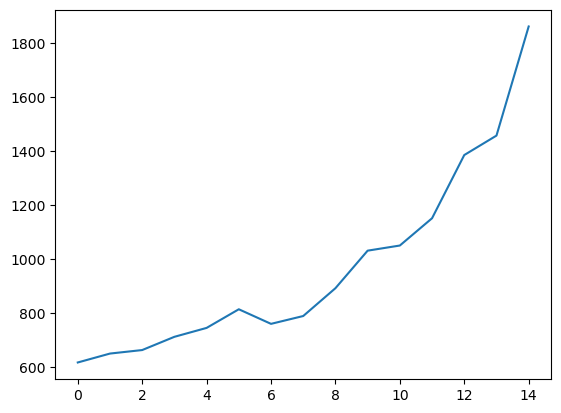

In [11]:
plt.plot(gt1.gt_xarr.data[0,:gt1.inpaintfrom_idx].sum(axis=-1))

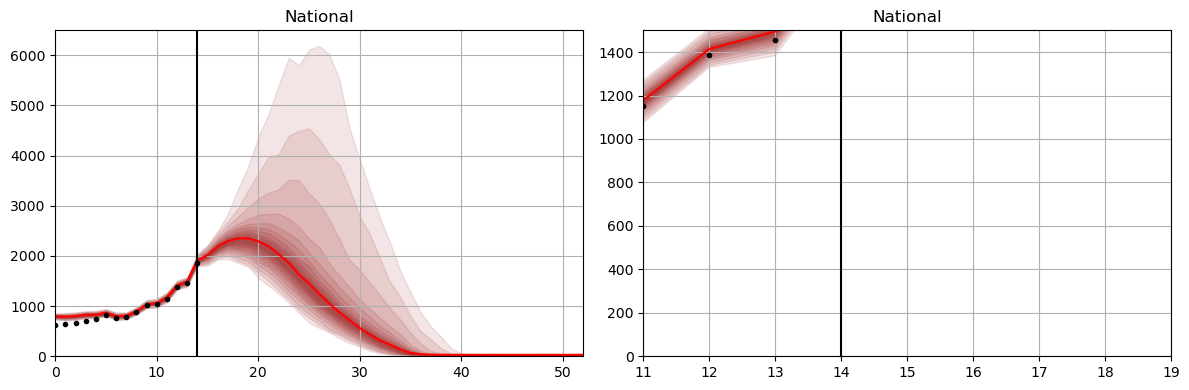

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), dpi=100)

for iax in range(2):
  ax = axes[iax]
  for iqt in range(11):
      #print(flusight_quantile_pairs[iqt,0], flusight_quantile_pairs[iqt,1])
      ax.fill_between(np.arange(64), 
                      np.quantile(forecasts_national, myutils.flusight_quantile_pairs[iqt,0], axis=0)[0], 
                      np.quantile(forecasts_national, myutils.flusight_quantile_pairs[iqt,1], axis=0)[0], alpha=.1, color='darkred')
      
  ax.plot(np.arange(64), 
          np.quantile(forecasts_national, myutils.flusight_quantiles[12], axis=0)[0], color='r')
  #ax.plot(np.arange(64), fluforecasts_ti[:,0].sum(axis=-1).T,lw=0.1, alpha=.1,  color='k')
  ax.plot(gt1.gt_xarr.data[0,:gt1.inpaintfrom_idx].sum(axis=1), color='k', marker='.', ls='')
  ax.axvline(gt1.inpaintfrom_idx-1, c='k')
  if iax==0:
    ax.set_xlim(0,52)
    ax.set_ylim(bottom=0, auto=True)
  if iax==1:
    ax.set_xlim(gt1.inpaintfrom_idx-4,gt1.inpaintfrom_idx+4)
    ax.set_ylim(bottom=0, top=1500)
  
  ax.grid(visible = True)
  ax.set_title("National")
fig.tight_layout()
plt.show()

In [13]:
forecast_date = datetime.date(2023,11,11) # saturday right after sub date
team_abbrv = "UNC_IDD-InfluPaint"
forecast_date_str=str(forecast_date)

In [ ]:
[f"{n}" for n in range(1,5)]

In [ ]:

gt1.export_forecasts(fluforecasts_ti=fluforecasts_ti,
                        forecasts_national=forecasts_national,
                        directory='output',
                        prefix=team_abbrv,
                        forecast_date=forecast_date,
                        save_plot=True)

In [14]:
gt1.export_forecasts_2023(fluforecasts_ti=fluforecasts_ti,
                        forecasts_national=forecasts_national,
                        directory='output',
                        prefix=team_abbrv,
                        forecast_date=forecast_date,
                        save_plot=True)

DatetimeIndex(['2023-11-11', '2023-11-18', '2023-11-25', '2023-12-02'], dtype='datetime64[ns]', freq='W-SAT')
reference_date
['2023-11-11']
target
['wk inc flu hosp']
horizon
['0' '1' '2' '3']
target_end_date
<DatetimeArray>
['2023-11-11 00:00:00', '2023-11-18 00:00:00', '2023-11-25 00:00:00',
 '2023-12-02 00:00:00']
Length: 4, dtype: datetime64[ns]
location
['01' '02' '04' '05' '06' '08' '09' '10' '11' '12' '13' '15' '16' '17'
 '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '44' '45' '46'
 '47' '48' '49' '50' '51' '53' '54' '55' '56' 'US']
output_type
['quantile']
output_type_id
['0.010' '0.025' '0.050' '0.100' '0.150' '0.200' '0.250' '0.300' '0.350'
 '0.400' '0.450' '0.500' '0.550' '0.600' '0.650' '0.700' '0.750' '0.800'
 '0.850' '0.900' '0.950' '0.975' '0.990']
value
[  19.46372845   21.88850571   15.46724115 ... 2493.57094984 2833.23065278
 3333.42673349]


In [ ]:
plt.savefig(f"output/UNC_IDD-InfluPaint-2023-11-01-plot50-95_2.pdf")

## Data Export

In [ ]:
import requests
requests.post("https://ntfy.sh/chadi_modeling",
     data="Notebook finshed running !",
     headers={
         "Title": "Inpainting-diffusion",
         "Priority": "urgent",
         "Tags": "warning,tada"
     })